In [ ]:
import numpy as np
import pandas as pd
import random
import csv

import matplotlib.pylab as plt
import seaborn as sns
sns.despine()

from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV, cross_val_score, \
                                    cross_validate, GridSearchCV

from sklearn.metrics import make_scorer
from imblearn.metrics import specificity_score, classification_report_imbalanced, \
                                sensitivity_specificity_support, sensitivity_score, \
                                geometric_mean_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, \
            classification_report, recall_score, precision_recall_curve, roc_auc_score, \
            precision_score, accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

# Define random state
random_state = 2018
np.random.seed(random_state)

### 1. all running

In [2]:
# Reading the Dataset
lebaledCSVFilePath = '/home/mirwais/notebooks/paper_3/data/single_channel/lebaled/all_time_freq_segments.csv'
df = pd.read_csv(lebaledCSVFilePath)
df.columns.size

43

In [3]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 0.1', 'recordingID', 'time',
       'max', 'mean', 'std', 'rms', 'kurtosis', 'cov', 'skewness',
       'delta_mean', 'theta_mean', 'alpha_mean', 'beta_mean', 'all_mean',
       'delta_std', 'theta_std', 'alpha_std', 'beta_std', 'all_std',
       'delta_cov', 'theta_cov', 'alpha_cov', 'beta_cov', 'all_cov',
       'delta_kurtosis', 'theta_kurtosis', 'alpha_kurtosis', 'beta_kurtosis',
       'all_kurtosis', 'delta_skew', 'theta_skew', 'alpha_skew', 'beta_skew',
       'all_skew', 'delta_rms', 'theta_rms', 'alpha_rms', 'beta_rms',
       'all_rms', 'sz'],
      dtype='object')

In [4]:
normal, seizure = df["sz"].value_counts()
print('Normal = {}\n Seziure = {}'.format(normal, seizure))

Normal = 331033
 Seziure = 5562


In [5]:
# Feature Selection before MLP
# Feature selection using anova F score and p score values

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def select_kbest_clf(data_frame, target, k):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    feat_selector = SelectKBest(f_classif, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores

features = df.drop(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 0.1', 'recordingID', 'time',], axis=1)
# for 1% => k=30 (remove 7 features), for 50% => k=33 (remove 4 features)
res = pd.DataFrame(select_kbest_clf(features, 'sz', 30))
f = res.loc[res['Support'] != True]
a=[]
for i in f['Attribute']:
    a.append(i)
    
res

F Score       P Value  Support       Attribute
0   3191.603739  0.000000e+00     True             max
1   5119.503641  0.000000e+00     True            mean
2   3842.007237  0.000000e+00     True             std
3   4634.465228  0.000000e+00     True             rms
4      2.195156  1.384461e-01    False        kurtosis
5      4.250777  3.923314e-02    False             cov
6      4.749891  2.930083e-02    False        skewness
7   3862.418994  0.000000e+00     True      delta_mean
8   7539.958931  0.000000e+00     True      theta_mean
9   4482.252919  0.000000e+00     True      alpha_mean
10  4415.198336  0.000000e+00     True       beta_mean
11  7313.580864  0.000000e+00     True        all_mean
12  3538.168885  0.000000e+00     True       delta_std
13  7019.673799  0.000000e+00     True       theta_std
14  2995.107051  0.000000e+00     True       alpha_std
15  1895.314060  0.000000e+00     True        beta_std
16  5813.481141  0.000000e+00     True         all_std
17    27.045830  1.988043e-07     True       delta_cov
18    27.510797  1.563141e-07     True       theta_cov
19    24.688792  6.740779e-07     True       alpha_cov
20   297.656418  1.140563e-66     True        beta_cov
21    76.531758  2.176691e-18     True         all_cov
22     0.464000  4.957609e-01    False  delta_kurtosis
23     0.035058  8.514751e-01    False  theta_kurtosis
24    15.504268  8.233575e-05     True  alpha_kurtosis
25   167.814655  2.268163e-38     True   beta_kurtosis
26    24.838026  6.238600e-07     True    all_kurtosis
27     0.896607  3.436938e-01    False      delta_skew
28    15.129551  1.003989e-04     True      theta_skew
29     4.504463  3.380723e-02    False      alpha_skew
30   190.628557  2.382165e-43     True       beta_skew
31    30.353090  3.603954e-08     True        all_skew
32  3817.454581  0.000000e+00     True       delta_rms
33  7713.214291  0.000000e+00     True       theta_rms
34  4217.412081  0.000000e+00     True       alpha_rms
35  3187.454465  0.000000e+00     True        beta_rms
36  5977.649671  0.000000e+00     True         all_rms

In [6]:
a

['kurtosis',
 'cov',
 'skewness',
 'delta_kurtosis',
 'theta_kurtosis',
 'delta_skew',
 'alpha_skew']

In [9]:
# Without oversampling of Smothe method
x = df.drop(['sz','Unnamed: 0', 'Unnamed: 1', 'Unnamed: 0.1', 'recordingID', 'time',], axis=1)
x = x.drop(a, axis=1)
y = df['sz']

#dissimilar scales of data, normalization (0,1) should be used
sc = MinMaxScaler(feature_range=(0, 1))
sc.fit(x)
x_std = sc.transform(x)

# Apply StratifiedKFold with GridSearchCV on MPL Classifier

# Splitting 
x_train, x_test, y_train, y_test = train_test_split(x_std, y, train_size=0.7, test_size=0.3, random_state=random_state)

#Cross validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state = random_state)

def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units = 19, kernel_initializer = 'uniform', activation = 'relu', input_dim = 30))
    classifier.add(Dense(units = 19, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn = build_classifier)

params = {'batch_size': [50],
              'epochs': [100],
              'optimizer': ['adam', 'sgd'],
             'class_weight' : [{0: 1., 1: 50.}]
         }

grid_sclf = GridSearchCV(estimator = classifier, param_grid = params, cv = cv, n_jobs=-1, scoring='f1_weighted', verbose=4)

grid_sclf.fit(x_train, y_train)


Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] batch_size=50, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=adam 
[CV] batch_size=50, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=adam 
[CV] batch_size=50, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=adam 
[CV] batch_size=50, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=adam 
[CV] batch_size=50, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=adam 
Epoch 1/100
Epoch 1/100
[CV] batch_size=50, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=adam 
 12900/212053 [>.............................] - ETA: 12s - loss: 1.2639 - acc: 0.9829Epoch 1/100
Epoch 1/100
212054/212054 [==============================] - 12s 58us/step - loss: 1.1869 - acc: 0.8540
Epoch 2/100
212054/212054 [==============================] - 14s 64us/step - loss: 1.1817 - acc: 0.8476
Epoch 2/100
212055/212055 [==============================] - 13s 62us/step - loss: 1.1777 - acc: 0.8496
Epoch 2/100
212055/212055

212055/212055 [==============================] - 13s 59us/step - loss: 1.1301 - acc: 0.8643
Epoch 15/100
212055/212055 [==============================] - 13s 60us/step - loss: 1.1362 - acc: 0.8766
Epoch 16/100
212053/212053 [==============================] - 13s 62us/step - loss: 1.1267 - acc: 0.8601
Epoch 16/100
212055/212055 [==============================] - 13s 60us/step - loss: 1.1347 - acc: 0.8721
Epoch 16/100
212055/212055 [==============================] - 13s 61us/step - loss: 1.1285 - acc: 0.8712
Epoch 16/100
212054/212054 [==============================] - 13s 62us/step - loss: 1.1266 - acc: 0.8798
Epoch 16/100
212053/212053 [==============================] - 13s 61us/step - loss: 1.1249 - acc: 0.8781
Epoch 17/100
212054/212054 [==============================] - 12s 58us/step - loss: 1.1299 - acc: 0.8791
Epoch 17/100
212053/212053 [==============================] - 14s 64us/step - loss: 1.1252 - acc: 0.8628
Epoch 17/100
212055/212055 [==============================] - 13s 59

212053/212053 [==============================] - 13s 59us/step - loss: 1.1123 - acc: 0.8739
Epoch 29/100
212053/212053 [==============================] - 13s 61us/step - loss: 1.1155 - acc: 0.8271
Epoch 29/100
212055/212055 [==============================] - 13s 61us/step - loss: 1.1112 - acc: 0.8841
Epoch 29/100
212055/212055 [==============================] - 13s 61us/step - loss: 1.1225 - acc: 0.8620
Epoch 30/100
212054/212054 [==============================] - 13s 61us/step - loss: 1.1071 - acc: 0.8994
Epoch 30/100
212055/212055 [==============================] - 14s 64us/step - loss: 1.1116 - acc: 0.8788
Epoch 30/100
212055/212055 [==============================] - 13s 61us/step - loss: 1.1116 - acc: 0.8808
Epoch 30/100
212054/212054 [==============================] - 13s 63us/step - loss: 1.1168 - acc: 0.8550
Epoch 31/100
212055/212055 [==============================] - 13s 61us/step - loss: 1.1220 - acc: 0.8695
Epoch 31/100
212053/212053 [==============================] - 13s 62

212054/212054 [==============================] - 13s 62us/step - loss: 1.1011 - acc: 0.8915
Epoch 43/100
212053/212053 [==============================] - 13s 62us/step - loss: 1.1023 - acc: 0.7782
Epoch 43/100
212055/212055 [==============================] - 12s 59us/step - loss: 1.0989 - acc: 0.8036
Epoch 43/100
212055/212055 [==============================] - 13s 61us/step - loss: 1.1094 - acc: 0.8552
Epoch 44/100
212054/212054 [==============================] - 13s 61us/step - loss: 1.1049 - acc: 0.7988
Epoch 44/100
212054/212054 [==============================] - 13s 59us/step - loss: 1.1005 - acc: 0.8146
Epoch 44/100
212055/212055 [==============================] - 13s 61us/step - loss: 1.0996 - acc: 0.8613
Epoch 44/100
212055/212055 [==============================] - 13s 59us/step - loss: 1.0980 - acc: 0.7964
Epoch 44/100
212055/212055 [==============================] - 13s 61us/step - loss: 1.1079 - acc: 0.8212
Epoch 45/100
212053/212053 [==============================] - 13s 61

212055/212055 [==============================] - 13s 63us/step - loss: 1.0880 - acc: 0.8051
Epoch 57/100
212053/212053 [==============================] - 13s 61us/step - loss: 1.0911 - acc: 0.7792
Epoch 57/100
212055/212055 [==============================] - 13s 62us/step - loss: 1.0932 - acc: 0.7874
Epoch 58/100
212054/212054 [==============================] - 13s 60us/step - loss: 1.0895 - acc: 0.7388
Epoch 58/100
212055/212055 [==============================] - 13s 62us/step - loss: 1.0906 - acc: 0.7879
Epoch 59/100
212054/212054 [==============================] - 11s 54us/step - loss: 1.0910 - acc: 0.7461
Epoch 59/100
212053/212053 [==============================] - 13s 63us/step - loss: 1.0810 - acc: 0.7973
Epoch 59/100
212054/212054 [==============================] - 14s 66us/step - loss: 1.0918 - acc: 0.8012
Epoch 59/100
212053/212053 [==============================] - 13s 60us/step - loss: 1.0892 - acc: 0.7781
Epoch 59/100
212055/212055 [==============================] - 13s 63

212054/212054 [==============================] - 14s 66us/step - loss: 1.0809 - acc: 0.7978
Epoch 71/100
Epoch 71/100
212053/212053 [==============================] - 13s 59us/step - loss: 1.0743 - acc: 0.8053
Epoch 71/100
212055/212055 [==============================] - 13s 64us/step - loss: 1.0795 - acc: 0.7832
Epoch 71/100
212055/212055 [==============================] - 13s 62us/step - loss: 1.0814 - acc: 0.7604
Epoch 71/100
212055/212055 [==============================] - 13s 60us/step - loss: 1.0797 - acc: 0.7887
Epoch 72/100
212055/212055 [==============================] - 12s 59us/step - loss: 1.0813 - acc: 0.7894
Epoch 72/100
212055/212055 [==============================] - 13s 60us/step - loss: 1.0808 - acc: 0.7631
Epoch 72/100
212053/212053 [==============================] - 13s 61us/step - loss: 1.0824 - acc: 0.7909
Epoch 72/100
212054/212054 [==============================] - 13s 64us/step - loss: 1.0814 - acc: 0.7653
Epoch 73/100
212053/212053 [===========================

212054/212054 [==============================] - 13s 61us/step - loss: 1.0751 - acc: 0.8012
Epoch 85/100
212055/212055 [==============================] - 13s 63us/step - loss: 1.0755 - acc: 0.7851
Epoch 85/100
212055/212055 [==============================] - 13s 61us/step - loss: 1.0722 - acc: 0.7866
Epoch 85/100
212054/212054 [==============================] - 14s 64us/step - loss: 1.0730 - acc: 0.8061
Epoch 86/100
212055/212055 [==============================] - 12s 59us/step - loss: 1.0718 - acc: 0.7900
Epoch 86/100
212053/212053 [==============================] - 14s 64us/step - loss: 1.0773 - acc: 0.7971
Epoch 86/100
212055/212055 [==============================] - 12s 58us/step - loss: 1.0735 - acc: 0.7921
Epoch 87/100
212054/212054 [==============================] - 13s 63us/step - loss: 1.0762 - acc: 0.7664
Epoch 87/100
212053/212053 [==============================] - 13s 63us/step - loss: 1.0705 - acc: 0.8032
Epoch 87/100
212055/212055 [==============================] - 13s 63

212053/212053 [==============================] - 13s 61us/step - loss: 1.0639 - acc: 0.8056
Epoch 99/100
212054/212054 [==============================] - 13s 63us/step - loss: 1.0697 - acc: 0.8036
Epoch 99/100
212055/212055 [==============================] - 13s 61us/step - loss: 1.0694 - acc: 0.7855
Epoch 99/100
212055/212055 [==============================] - 13s 62us/step - loss: 1.0663 - acc: 0.7920
Epoch 99/100
212053/212053 [==============================] - 13s 61us/step - loss: 1.0739 - acc: 0.7990
Epoch 99/100
212055/212055 [==============================] - 13s 63us/step - loss: 1.0659 - acc: 0.7822
Epoch 100/100
212053/212053 [==============================] - 13s 60us/step - loss: 1.0655 - acc: 0.8037
Epoch 100/100
212054/212054 [==============================] - 12s 56us/step - loss: 1.0693 - acc: 0.8116
Epoch 100/100
212053/212053 [==============================] - 13s 61us/step - loss: 1.0739 - acc: 0.7964
Epoch 100/100
122850/212055 [================>.............] - ET

212054/212054 [==============================] - 11s 52us/step - loss: 1.1610 - acc: 0.8427
Epoch 11/100
212054/212054 [==============================] - 11s 53us/step - loss: 1.1639 - acc: 0.8022
Epoch 11/100
212055/212055 [==============================] - 12s 55us/step - loss: 1.1659 - acc: 0.8301
Epoch 11/100
212054/212054 [==============================] - 11s 51us/step - loss: 1.1596 - acc: 0.8020
Epoch 12/100
212054/212054 [==============================] - 11s 54us/step - loss: 1.1581 - acc: 0.8558
Epoch 12/100
212053/212053 [==============================] - 11s 50us/step - loss: 1.1543 - acc: 0.8391
Epoch 13/100
212055/212055 [==============================] - 11s 50us/step - loss: 1.1582 - acc: 0.8361
Epoch 12/100
212053/212053 [==============================] - 11s 53us/step - loss: 1.1539 - acc: 0.8552
Epoch 13/100
212053/212053 [==============================] - 11s 53us/step - loss: 1.1529 - acc: 0.8504
Epoch 14/100
212055/212055 [==============================] - 12s 55

212055/212055 [==============================] - 13s 61us/step - loss: 1.1313 - acc: 0.8617
Epoch 23/100
212054/212054 [==============================] - 11s 53us/step - loss: 1.1426 - acc: 0.8592
Epoch 25/100
212053/212053 [==============================] - 12s 56us/step - loss: 1.1475 - acc: 0.8743
Epoch 25/100
212053/212053 [==============================] - 11s 54us/step - loss: 1.1391 - acc: 0.8641
Epoch 26/100
212055/212055 [==============================] - 13s 62us/step - loss: 1.1231 - acc: 0.8806
Epoch 24/100
212054/212054 [==============================] - 12s 55us/step - loss: 1.1375 - acc: 0.8730
Epoch 26/100
212054/212054 [==============================] - 12s 55us/step - loss: 1.1420 - acc: 0.8511
Epoch 26/100
212055/212055 [==============================] - 12s 54us/step - loss: 1.1409 - acc: 0.8653
Epoch 26/100
212055/212055 [==============================] - 12s 55us/step - loss: 1.1406 - acc: 0.8762
Epoch 26/100
212054/212054 [==============================] - 11s 52

212055/212055 [==============================] - 13s 59us/step - loss: 1.0988 - acc: 0.8114
Epoch 37/100
212053/212053 [==============================] - 10s 49us/step - loss: 1.1278 - acc: 0.8536
Epoch 40/100
212055/212055 [==============================] - 11s 54us/step - loss: 1.1347 - acc: 0.8629
Epoch 40/100
212054/212054 [==============================] - 11s 50us/step - loss: 1.1297 - acc: 0.8704
Epoch 41/100
212055/212055 [==============================] - 12s 55us/step - loss: 1.1324 - acc: 0.8691
Epoch 40/100
212055/212055 [==============================] - 12s 55us/step - loss: 1.1011 - acc: 0.8089
Epoch 38/100
212055/212055 [==============================] - 12s 57us/step - loss: 1.1150 - acc: 0.8525
Epoch 38/100
212055/212055 [==============================] - 12s 57us/step - loss: 1.0968 - acc: 0.8048
Epoch 39/100
212053/212053 [==============================] - 12s 56us/step - loss: 1.1248 - acc: 0.8528
Epoch 42/100
212053/212053 [==============================] - 12s 56

212053/212053 [==============================] - 12s 57us/step - loss: 1.1185 - acc: 0.8187
Epoch 54/100
212055/212055 [==============================] - 13s 61us/step - loss: 1.1013 - acc: 0.7744
Epoch 50/100
212055/212055 [==============================] - 12s 58us/step - loss: 1.1248 - acc: 0.8378
Epoch 54/100
212055/212055 [==============================] - 12s 55us/step - loss: 1.1320 - acc: 0.8634
Epoch 54/100
212054/212054 [==============================] - 11s 54us/step - loss: 1.1239 - acc: 0.8435
Epoch 55/100
212055/212055 [==============================] - 12s 57us/step - loss: 1.0823 - acc: 0.8118
Epoch 51/100
212053/212053 [==============================] - 11s 51us/step - loss: 1.1200 - acc: 0.8510
Epoch 55/100
212055/212055 [==============================] - 12s 58us/step - loss: 1.1022 - acc: 0.7804
Epoch 51/100
212055/212055 [==============================] - 11s 53us/step - loss: 1.1317 - acc: 0.8559
Epoch 55/100
212055/212055 [==============================] - 13s 59

212055/212055 [==============================] - 12s 54us/step - loss: 1.1184 - acc: 0.8154
Epoch 68/100
212055/212055 [==============================] - 12s 55us/step - loss: 1.1267 - acc: 0.8636
Epoch 69/100
212055/212055 [==============================] - 13s 59us/step - loss: 1.0927 - acc: 0.7744
Epoch 64/100
212054/212054 [==============================] - 11s 53us/step - loss: 1.1192 - acc: 0.7886
Epoch 70/100
212055/212055 [==============================] - 11s 53us/step - loss: 1.1229 - acc: 0.8645
Epoch 70/100
212055/212055 [==============================] - 13s 59us/step - loss: 1.0717 - acc: 0.8075
Epoch 66/100
212055/212055 [==============================] - 13s 59us/step - loss: 1.0904 - acc: 0.7749
Epoch 65/100
212054/212054 [==============================] - 11s 54us/step - loss: 1.1189 - acc: 0.7861
Epoch 71/100
212053/212053 [==============================] - 11s 52us/step - loss: 1.1131 - acc: 0.7974
Epoch 71/100
212054/212054 [==============================] - 12s 55

212053/212053 [==============================] - 11s 53us/step - loss: 1.1037 - acc: 0.7887
Epoch 84/100
212055/212055 [==============================] - 11s 53us/step - loss: 1.1138 - acc: 0.7840
Epoch 83/100
212053/212053 [==============================] - 11s 51us/step - loss: 1.1077 - acc: 0.7943
Epoch 84/100
212055/212055 [==============================] - 12s 56us/step - loss: 1.0636 - acc: 0.8079
Epoch 79/100
212053/212053 [==============================] - 11s 52us/step - loss: 1.1069 - acc: 0.7979
Epoch 85/100
212054/212054 [==============================] - 11s 53us/step - loss: 1.1075 - acc: 0.7883
Epoch 86/100
212055/212055 [==============================] - 11s 52us/step - loss: 1.1187 - acc: 0.7962
Epoch 85/100
212053/212053 [==============================] - 11s 51us/step - loss: 1.1033 - acc: 0.7766
Epoch 86/100
212055/212055 [==============================] - 12s 55us/step - loss: 1.1136 - acc: 0.7779
Epoch 85/100
212055/212055 [==============================] - 12s 59

212054/212054 [==============================] - 12s 55us/step - loss: 1.1126 - acc: 0.7664
Epoch 98/100
212053/212053 [==============================] - 11s 53us/step - loss: 1.0971 - acc: 0.7728
Epoch 99/100
212055/212055 [==============================] - 12s 56us/step - loss: 1.1095 - acc: 0.7759
Epoch 98/100
212055/212055 [==============================] - 13s 60us/step - loss: 1.0730 - acc: 0.7980
Epoch 91/100
212055/212055 [==============================] - 12s 54us/step - loss: 1.1134 - acc: 0.7898
Epoch 99/100
212054/212054 [==============================] - 12s 54us/step - loss: 1.1090 - acc: 0.7701
Epoch 99/100
212053/212053 [==============================] - 11s 52us/step - loss: 1.0970 - acc: 0.7828
Epoch 100/100
212055/212055 [==============================] - 12s 58us/step - loss: 1.0717 - acc: 0.7865
Epoch 92/100
212055/212055 [==============================] - 12s 55us/step - loss: 1.1151 - acc: 0.8075
Epoch 100/100
212053/212053 [==============================] - 12s 

[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed: 40.9min remaining: 33.5min


212055/212055 [==============================] - 12s 56us/step - loss: 1.2545 - acc: 0.9686
Epoch 2/100
212055/212055 [==============================] - 12s 56us/step - loss: 1.0708 - acc: 0.7936
Epoch 94/100
212055/212055 [==============================] - 11s 51us/step - loss: 1.0562 - acc: 0.8083
Epoch 96/100
212055/212055 [==============================] - 10s 49us/step - loss: 1.2550 - acc: 0.9825
Epoch 2/100
212055/212055 [==============================] - 10s 49us/step - loss: 1.2545 - acc: 0.9767
Epoch 2/100
212055/212055 [==============================] - 9s 44us/step - loss: 1.2547 - acc: 0.9833
Epoch 3/100
212055/212055 [==============================] - 10s 48us/step - loss: 1.0712 - acc: 0.7922
Epoch 95/100
212055/212055 [==============================] - 9s 43us/step - loss: 1.2547 - acc: 0.9833
Epoch 3/100
Epoch 4/100
212055/212055 [==============================] - 10s 45us/step - loss: 1.2548 - acc: 0.9833
Epoch 3/100
212055/212055 [==============================] - 10

Epoch 30/100
212055/212055 [==============================] - 7s 33us/step - loss: 1.1390 - acc: 0.8753
Epoch 31/100
212055/212055 [==============================] - 7s 32us/step - loss: 1.1360 - acc: 0.8733
Epoch 31/100
212055/212055 [==============================] - 8s 36us/step - loss: 1.1362 - acc: 0.8729
Epoch 31/100
212055/212055 [==============================] - 7s 32us/step - loss: 1.1381 - acc: 0.8656
Epoch 32/100
212055/212055 [==============================] - 8s 35us/step - loss: 1.1401 - acc: 0.8711
Epoch 31/100
212055/212055 [==============================] - 7s 35us/step - loss: 1.1361 - acc: 0.8691
Epoch 32/100
212055/212055 [==============================] - 7s 34us/step - loss: 1.1371 - acc: 0.8835
Epoch 32/100
212055/212055 [==============================] - 7s 32us/step - loss: 1.1384 - acc: 0.8723
Epoch 33/100
212055/212055 [==============================] - 7s 35us/step - loss: 1.1404 - acc: 0.8779
Epoch 32/100
212055/212055 [==============================] - 8s

212055/212055 [==============================] - 7s 33us/step - loss: 1.1217 - acc: 0.8723
Epoch 67/100
212055/212055 [==============================] - 7s 32us/step - loss: 1.1184 - acc: 0.8151
Epoch 66/100
212055/212055 [==============================] - 7s 35us/step - loss: 1.1231 - acc: 0.8533
Epoch 67/100
212055/212055 [==============================] - 7s 35us/step - loss: 1.1200 - acc: 0.8768
Epoch 68/100
212055/212055 [==============================] - 7s 35us/step - loss: 1.1206 - acc: 0.8080
Epoch 67/100
212055/212055 [==============================] - 7s 33us/step - loss: 1.1211 - acc: 0.8538
Epoch 68/100
212055/212055 [==============================] - 8s 36us/step - loss: 1.1211 - acc: 0.8709
Epoch 69/100
212055/212055 [==============================] - 8s 37us/step - loss: 1.1185 - acc: 0.7931
Epoch 69/100
212055/212055 [==============================] - 7s 33us/step - loss: 1.1192 - acc: 0.8051
Epoch 68/100
212055/212055 [==============================] - 8s 36us/step - 

198700/212055 [===========================>..] - ETA: 0s - loss: 1.1082 - acc: 0.7899

[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed: 53.2min remaining:  9.4min


212055/212055 [==============================] - 7s 32us/step - loss: 1.1087 - acc: 0.7875
Epoch 100/100
212055/212055 [==============================] - 7s 32us/step - loss: 1.1088 - acc: 0.7879
Epoch 100/100
212055/212055 [==============================] - 6s 28us/step - loss: 1.1051 - acc: 0.7880
[CV]  batch_size=50, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=sgd, score=0.883565439099982, total=12.4min
[CV]  batch_size=50, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=sgd, score=0.9314975807800274, total=12.4min


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 53.3min finished


Epoch 1/100
235616/235616 [==============================] - 5s 21us/step - loss: 1.2547 - acc: 0.9833
Epoch 2/100
235616/235616 [==============================] - 5s 21us/step - loss: 1.2549 - acc: 0.9833
Epoch 3/100
235616/235616 [==============================] - 5s 21us/step - loss: 1.2543 - acc: 0.9833
Epoch 4/100
235616/235616 [==============================] - 5s 21us/step - loss: 1.2546 - acc: 0.9833
Epoch 5/100
235616/235616 [==============================] - 5s 21us/step - loss: 1.2540 - acc: 0.9832
Epoch 6/100
235616/235616 [==============================] - 5s 21us/step - loss: 1.2526 - acc: 0.9809
Epoch 7/100
235616/235616 [==============================] - 5s 21us/step - loss: 1.2355 - acc: 0.9252
Epoch 8/100
235616/235616 [==============================] - 5s 21us/step - loss: 1.1833 - acc: 0.7726
Epoch 9/100
235616/235616 [==============================] - 5s 21us/step - loss: 1.1680 - acc: 0.8345
Epoch 10/100
235616/235616 [==============================] - 5s 22us/ste

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2018, shuffle=True),
       error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f8e937db710>,
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'batch_size': [50], 'epochs': [100], 'optimizer': ['adam', 'sgd'], 'class_weight': [{0: 1.0, 1: 50.0}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=4)

{'batch_size': 50, 'class_weight': {0: 1.0, 1: 50.0}, 'epochs': 100, 'optimizer': 'sgd'}
...................................................................


Accuracy of MLP Model: 0.83012309490092


Confusion matrix, without normalization
[[83050 16299]
 [  855   775]]
Normalized confusion matrix
[[0.84 0.16]
 [0.52 0.48]]


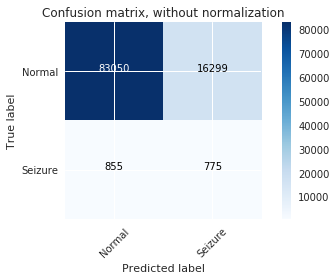

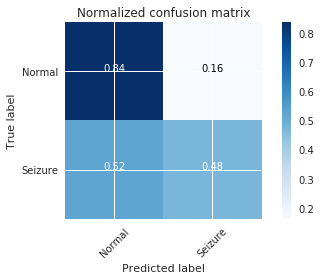

             precision    recall  f1-score   support

     Normal     0.9898    0.8359    0.9064     99349
    Seizure     0.0454    0.4755    0.0829      1630

avg / total     0.9746    0.8301    0.8931    100979

....................................................................


sensitivity_specificity None: (array([0.84, 0.48]), array([0.48, 0.84]), array([99349,  1630]))
sensitivity_specificity micro: (0.83012309490092, 0.83012309490092, None)
sensitivity_specificity macro: (0.6557010525020954, 0.6557010525020954, None)
sensitivity_specificity weighted: (0.83012309490092, 0.48127901010327073, None)




F1 None: [0.91 0.08]


F1 micro: 0.83012309490092


F1 macro: 0.49463109748534817


F1 weighted: 0.8930989491468768




precision None: 0.83012309490092


precision micro: 0.83012309490092


precision macro: 0.83012309490092


precision weighted: 0.83012309490092




recall None: 0.83012309490092


recall micro: 0.83012309490092


recall macro: 0.83012309490092


recall weighted:

In [11]:
import itertools

print(grid_sclf.best_estimator_)
print(grid_sclf.best_params_)
print('...................................................................\n\n')

#Prediction
y_predict = grid_sclf.predict(x_test)

print('Accuracy of MLP Model: {}\n\n' .format((accuracy_score(y_test,y_predict))))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
#generate and plot confusion matrix
target_names = ['Normal', 'Seizure']

cnf_matrix = confusion_matrix(y_test,y_predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#Classification Report

print(classification_report(y_test, y_predict, digits=4, target_names=target_names))
#print(classification_report_imbalanced(y_test, y_predict, target_names=target_names, digits=4))

print('....................................................................\n\n')

#micro recall, precesion, specificity
for i in [None, 'micro', 'macro', 'weighted']:
    print('sensitivity_specificity {}: {}'.format(i, sensitivity_specificity_support(y_test, y_predict, average=i)))
print('\n')
for i in [None, 'micro', 'macro', 'weighted']:
    print('\n\nF1 {}: {}'.format(i, f1_score(y_test, y_predict, average=i)))
print('\n')
for i in [None, 'micro', 'macro', 'weighted']:
    print('\n\nprecision {}: {}'.format(i,precision_score(y_test, y_predict, average='micro')))
print('\n')
for i in [None, 'micro', 'macro', 'weighted']:
    print('\n\nrecall {}: {}'.format(i, recall_score(y_test, y_predict, average='micro')))

In [9]:
# Over-sampling using SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE 

x = df.drop(['sz','Unnamed: 0', 'Unnamed: 1', 'Unnamed: 0.1', 'recordingID', 'time',], axis=1)
x = x.drop(a, axis=1)
y = df['sz']

#dissimilar scales of data, normalization (0,1) should be used
sc = MinMaxScaler(feature_range=(0, 1))
sc.fit(x)
x_std = sc.transform(x)

upsampling_rate = (normal*80)/100

sm = SMOTE(random_state=random_state, ratio={2:int(upsampling_rate)})
x_res, y_res = sm.fit_sample(x_std, y)

print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({0: 331033, 2: 264826})


In [10]:
# Apply StratifiedKFold with GridSearchCV on MPL Classifier

# Splitting 
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, train_size=0.7, test_size=0.3, random_state=random_state)

#Cross validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state = random_state)

def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu', input_dim = 30))
    classifier.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn = build_classifier)

params = {'batch_size': [50, 100],
              'epochs': [300],
              'optimizer': ['adam', 'rmsprop', 'sgd']
         }

grid_sclf = GridSearchCV(estimator = classifier, param_grid = params, cv = cv, n_jobs=-1, scoring='f1_weighted', verbose=4)

grid_sclf.fit(x_train, y_train)


Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] batch_size=50, epochs=300, optimizer=adam .......................
[CV] batch_size=50, epochs=300, optimizer=adam .......................
[CV] batch_size=50, epochs=300, optimizer=adam .......................
Epoch 1/300
[CV] batch_size=50, epochs=300, optimizer=adam .......................
375390/375390 [==============================] - 23s 62us/step - loss: 0.6252 - acc: 0.6308
Epoch 2/300
375391/375391 [==============================] - 23s 61us/step - loss: 0.6314 - acc: 0.6235
Epoch 2/300
375391/375391 [==============================] - 23s 61us/step - loss: 0.6287 - acc: 0.6277
Epoch 2/300
375390/375390 [==============================] - 24s 63us/step - loss: 0.6329 - acc: 0.6208
Epoch 2/300
375392/375392 [==============================] - 23s 62us/step - loss: 0.6328 - acc: 0.6212
Epoch 2/300
375390/375390 [==============================] - 23s 60us/step - loss: 0.6089 - acc: 0.6545
Epoch 3/300
375391/375391 [====

375390/375390 [==============================] - 22s 59us/step - loss: 0.5374 - acc: 0.7236
Epoch 15/300
375392/375392 [==============================] - 23s 60us/step - loss: 0.5366 - acc: 0.7226
Epoch 15/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.5375 - acc: 0.7221
Epoch 15/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.5424 - acc: 0.7195
Epoch 16/300
375391/375391 [==============================] - 23s 61us/step - loss: 0.5591 - acc: 0.7018
Epoch 16/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.5391 - acc: 0.7233
Epoch 16/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.5373 - acc: 0.7242
Epoch 16/300
375390/375390 [==============================] - 24s 63us/step - loss: 0.5379 - acc: 0.7214
Epoch 16/300
375392/375392 [==============================] - 23s 61us/step - loss: 0.5343 - acc: 0.7247
Epoch 16/300
375390/375390 [==============================] - 23s 61

375391/375391 [==============================] - 23s 61us/step - loss: 0.5239 - acc: 0.7343
Epoch 23/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.5262 - acc: 0.7322
Epoch 23/300
375392/375392 [==============================] - 22s 60us/step - loss: 0.5242 - acc: 0.7338
Epoch 23/300
375390/375390 [==============================] - 22s 60us/step - loss: 0.5249 - acc: 0.7314
Epoch 23/300
375391/375391 [==============================] - 22s 59us/step - loss: 0.5479 - acc: 0.7119
Epoch 24/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.5218 - acc: 0.7364
Epoch 24/300
375390/375390 [==============================] - 22s 60us/step - loss: 0.5245 - acc: 0.7335
Epoch 24/300
375390/375390 [==============================] - 22s 60us/step - loss: 0.5238 - acc: 0.7317
Epoch 24/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.5466 - acc: 0.7130
Epoch 25/300
375391/375391 [==============================] - 23s 61

375392/375392 [==============================] - 22s 59us/step - loss: 0.5122 - acc: 0.7412
Epoch 37/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.5135 - acc: 0.7413
Epoch 37/300
375390/375390 [==============================] - 23s 62us/step - loss: 0.5153 - acc: 0.7382
Epoch 37/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.5191 - acc: 0.7381
Epoch 38/300
375390/375390 [==============================] - 22s 60us/step - loss: 0.5105 - acc: 0.7428
Epoch 38/300
375391/375391 [==============================] - 23s 62us/step - loss: 0.5342 - acc: 0.7261
Epoch 38/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.5112 - acc: 0.7418
Epoch 38/300
375390/375390 [==============================] - 22s 60us/step - loss: 0.5133 - acc: 0.7410
Epoch 38/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.5188 - acc: 0.7383
Epoch 39/300
375390/375390 [==============================] - 22s 60

375391/375391 [==============================] - 23s 60us/step - loss: 0.5278 - acc: 0.7321
Epoch 52/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.5075 - acc: 0.7444
Epoch 52/300
375390/375390 [==============================] - 23s 60us/step - loss: 0.5105 - acc: 0.7412
Epoch 52/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.5137 - acc: 0.7419
Epoch 53/300
375391/375391 [==============================] - 22s 59us/step - loss: 0.5129 - acc: 0.7420
Epoch 53/300
375391/375391 [==============================] - 22s 60us/step - loss: 0.5045 - acc: 0.7450
Epoch 53/300
375391/375391 [==============================] - 23s 61us/step - loss: 0.5267 - acc: 0.7331
Epoch 53/300
375390/375390 [==============================] - 23s 60us/step - loss: 0.5103 - acc: 0.7419
Epoch 53/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.5137 - acc: 0.7406
Epoch 54/300
375391/375391 [==============================] - 22s 59

375391/375391 [==============================] - 23s 62us/step - loss: 0.5014 - acc: 0.7469
Epoch 66/300
375390/375390 [==============================] - 24s 65us/step - loss: 0.5031 - acc: 0.7475
Epoch 66/300
375390/375390 [==============================] - 24s 63us/step - loss: 0.5067 - acc: 0.7439
Epoch 66/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.5102 - acc: 0.7431
Epoch 67/300
375391/375391 [==============================] - 24s 63us/step - loss: 0.5091 - acc: 0.7444
Epoch 67/300
375391/375391 [==============================] - 24s 63us/step - loss: 0.5015 - acc: 0.7468
Epoch 67/300
375391/375391 [==============================] - 24s 63us/step - loss: 0.5205 - acc: 0.7369
Epoch 67/300
375390/375390 [==============================] - 24s 64us/step - loss: 0.5067 - acc: 0.7439
Epoch 67/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.5101 - acc: 0.7435
Epoch 68/300
375392/375392 [==============================] - 24s 63

375390/375390 [==============================] - 24s 63us/step - loss: 0.5003 - acc: 0.7493
Epoch 80/300
375390/375390 [==============================] - 24s 64us/step - loss: 0.5032 - acc: 0.7459
Epoch 80/300
375390/375390 [==============================] - 24s 63us/step - loss: 0.4988 - acc: 0.7498
Epoch 81/300
375392/375392 [==============================] - 23s 61us/step - loss: 0.4966 - acc: 0.7508
Epoch 81/300
375390/375390 [==============================] - 24s 63us/step - loss: 0.5075 - acc: 0.7447
Epoch 81/300
375391/375391 [==============================] - 23s 63us/step - loss: 0.5062 - acc: 0.7460
Epoch 81/300
375391/375391 [==============================] - 24s 63us/step - loss: 0.5157 - acc: 0.7400
Epoch 81/300
375390/375390 [==============================] - 24s 65us/step - loss: 0.5005 - acc: 0.7491
Epoch 81/300
375392/375392 [==============================] - 24s 63us/step - loss: 0.4963 - acc: 0.7511
Epoch 82/300
375390/375390 [==============================] - 23s 62

375391/375391 [==============================] - 23s 62us/step - loss: 0.4977 - acc: 0.7491
Epoch 95/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.4981 - acc: 0.7505
Epoch 95/300
375392/375392 [==============================] - 22s 60us/step - loss: 0.4945 - acc: 0.7524
Epoch 96/300
375391/375391 [==============================] - 23s 62us/step - loss: 0.5041 - acc: 0.7476
Epoch 96/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.4999 - acc: 0.7481
Epoch 95/300
375390/375390 [==============================] - 24s 63us/step - loss: 0.5052 - acc: 0.7464
Epoch 96/300
375391/375391 [==============================] - 23s 62us/step - loss: 0.5110 - acc: 0.7427
Epoch 96/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.4965 - acc: 0.7512
Epoch 97/300
375390/375390 [==============================] - 23s 60us/step - loss: 0.5049 - acc: 0.7464
Epoch 97/300
375391/375391 [==============================] - 23s 61

375392/375392 [==============================] - 24s 63us/step - loss: 0.4926 - acc: 0.7547
Epoch 109/300
375391/375391 [==============================] - 23s 62us/step - loss: 0.5020 - acc: 0.7488
Epoch 109/300
375390/375390 [==============================] - 24s 63us/step - loss: 0.5031 - acc: 0.7474
Epoch 109/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.4958 - acc: 0.7523
Epoch 109/300
375391/375391 [==============================] - 23s 62us/step - loss: 0.5083 - acc: 0.7447
Epoch 109/300
375391/375391 [==============================] - 24s 63us/step - loss: 0.4965 - acc: 0.7505
Epoch 109/300
375391/375391 [==============================] - 23s 62us/step - loss: 0.5019 - acc: 0.7493
Epoch 110/300
375390/375390 [==============================] - 23s 62us/step - loss: 0.5031 - acc: 0.7480
Epoch 110/300
375390/375390 [==============================] - 24s 63us/step - loss: 0.4958 - acc: 0.7521
Epoch 110/300
375391/375391 [==============================]

375390/375390 [==============================] - 24s 64us/step - loss: 0.5014 - acc: 0.7478
Epoch 123/300
375391/375391 [==============================] - 23s 62us/step - loss: 0.5061 - acc: 0.7455
Epoch 123/300
375390/375390 [==============================] - 23s 62us/step - loss: 0.4941 - acc: 0.7533
Epoch 123/300
375391/375391 [==============================] - 23s 62us/step - loss: 0.4948 - acc: 0.7522
Epoch 123/300
375392/375392 [==============================] - 24s 64us/step - loss: 0.4910 - acc: 0.7548
Epoch 124/300
318650/375390 [========================>.....] - ETA: 3s - loss: 0.5012 - acc: 0.7482Epoch 123/300
Epoch 124/300
375390/375390 [==============================] - 24s 63us/step - loss: 0.4943 - acc: 0.7525
Epoch 124/300
375391/375391 [==============================] - 24s 63us/step - loss: 0.4949 - acc: 0.7518
Epoch 124/300
375392/375392 [==============================] - 24s 63us/step - loss: 0.4907 - acc: 0.7550
Epoch 125/300
375390/375390 [========================

375391/375391 [==============================] - 23s 63us/step - loss: 0.4942 - acc: 0.7526
Epoch 130/300
375390/375390 [==============================] - 24s 64us/step - loss: 0.4957 - acc: 0.7511
Epoch 130/300
375390/375390 [==============================] - 24s 65us/step - loss: 0.5001 - acc: 0.7486
Epoch 131/300
375390/375390 [==============================] - 23s 62us/step - loss: 0.4938 - acc: 0.7533
Epoch 131/300
375391/375391 [==============================] - 24s 63us/step - loss: 0.5047 - acc: 0.7472
Epoch 131/300
375391/375391 [==============================] - 23s 62us/step - loss: 0.4995 - acc: 0.7506
Epoch 132/300
375390/375390 [==============================] - 24s 64us/step - loss: 0.4957 - acc: 0.7506
Epoch 131/300
375390/375390 [==============================] - 23s 63us/step - loss: 0.5002 - acc: 0.7483
Epoch 132/300
375391/375391 [==============================] - 23s 62us/step - loss: 0.5044 - acc: 0.7469
Epoch 132/300
375390/375390 [==============================]

375392/375392 [==============================] - 23s 62us/step - loss: 0.4896 - acc: 0.7567
Epoch 138/300
375390/375390 [==============================] - 24s 64us/step - loss: 0.4996 - acc: 0.7494
Epoch 138/300
375390/375390 [==============================] - 23s 62us/step - loss: 0.4932 - acc: 0.7539
Epoch 138/300
375391/375391 [==============================] - 23s 62us/step - loss: 0.5030 - acc: 0.7485
Epoch 138/300
375392/375392 [==============================] - 23s 61us/step - loss: 0.4895 - acc: 0.7563
Epoch 139/300
375391/375391 [==============================] - 23s 61us/step - loss: 0.4993 - acc: 0.7505
Epoch 139/300
375390/375390 [==============================] - 24s 63us/step - loss: 0.4995 - acc: 0.7492
Epoch 139/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.5030 - acc: 0.7481
Epoch 139/300
375392/375392 [==============================] - 22s 59us/step - loss: 0.4892 - acc: 0.7566
Epoch 140/300
375390/375390 [==============================]

375390/375390 [==============================] - 23s 62us/step - loss: 0.4944 - acc: 0.7520
Epoch 151/300
375392/375392 [==============================] - 23s 61us/step - loss: 0.4883 - acc: 0.7568
Epoch 153/300
375391/375391 [==============================] - 23s 62us/step - loss: 0.4921 - acc: 0.7546
Epoch 152/300
375390/375390 [==============================] - 24s 64us/step - loss: 0.4915 - acc: 0.7547
Epoch 153/300
375391/375391 [==============================] - 23s 61us/step - loss: 0.4982 - acc: 0.7517
Epoch 153/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.4982 - acc: 0.7503
Epoch 153/300
375390/375390 [==============================] - 24s 64us/step - loss: 0.4921 - acc: 0.7538
Epoch 153/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.4882 - acc: 0.7568
Epoch 154/300
375390/375390 [==============================] - 24s 64us/step - loss: 0.4943 - acc: 0.7519
Epoch 152/300
375391/375391 [==============================]

375391/375391 [==============================] - 22s 58us/step - loss: 0.4972 - acc: 0.7526
Epoch 167/300
375390/375390 [==============================] - 23s 63us/step - loss: 0.4975 - acc: 0.7507
Epoch 167/300
375392/375392 [==============================] - 23s 60us/step - loss: 0.4874 - acc: 0.7575
Epoch 168/300
375390/375390 [==============================] - 24s 64us/step - loss: 0.4914 - acc: 0.7546
Epoch 167/300
375391/375391 [==============================] - 24s 63us/step - loss: 0.4909 - acc: 0.7556
Epoch 167/300
375390/375390 [==============================] - 25s 67us/step - loss: 0.4904 - acc: 0.7556
Epoch 168/300
375390/375390 [==============================] - 23s 62us/step - loss: 0.4933 - acc: 0.7518
Epoch 166/300
375390/375390 [==============================] - 23s 62us/step - loss: 0.4972 - acc: 0.7505
Epoch 168/300
375391/375391 [==============================] - 24s 64us/step - loss: 0.4907 - acc: 0.7556
Epoch 168/300
375390/375390 [==============================]

375390/375390 [==============================] - 24s 64us/step - loss: 0.4907 - acc: 0.7547
Epoch 181/300
375390/375390 [==============================] - 23s 62us/step - loss: 0.4892 - acc: 0.7564
Epoch 182/300
375391/375391 [==============================] - 24s 64us/step - loss: 0.4900 - acc: 0.7557
Epoch 181/300
375392/375392 [==============================] - 23s 62us/step - loss: 0.4863 - acc: 0.7581
Epoch 183/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.4962 - acc: 0.7517
Epoch 182/300
375390/375390 [==============================] - 24s 63us/step - loss: 0.4903 - acc: 0.7551
Epoch 182/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.4891 - acc: 0.7565
Epoch 183/300
375391/375391 [==============================] - 23s 62us/step - loss: 0.4936 - acc: 0.7549
Epoch 182/300
375391/375391 [==============================] - 24s 63us/step - loss: 0.4900 - acc: 0.7563
Epoch 182/300
375391/375391 [==============================]

375390/375390 [==============================] - 23s 61us/step - loss: 0.4884 - acc: 0.7579
Epoch 196/300
375391/375391 [==============================] - 23s 62us/step - loss: 0.4920 - acc: 0.7564
Epoch 195/300
375391/375391 [==============================] - 23s 62us/step - loss: 0.4894 - acc: 0.7566
Epoch 195/300
375390/375390 [==============================] - 24s 63us/step - loss: 0.4880 - acc: 0.7578
Epoch 197/300
375391/375391 [==============================] - 24s 63us/step - loss: 0.4892 - acc: 0.7566
Epoch 196/300
375390/375390 [==============================] - 24s 64us/step - loss: 0.4917 - acc: 0.7534
Epoch 196/300
375390/375390 [==============================] - 23s 60us/step - loss: 0.4878 - acc: 0.7578
Epoch 199/300
375390/375390 [==============================] - 24s 63us/step - loss: 0.4954 - acc: 0.7520
Epoch 198/300
375390/375390 [==============================] - 24s 64us/step - loss: 0.4891 - acc: 0.7559
Epoch 198/300
375391/375391 [==============================]

375391/375391 [==============================] - 22s 60us/step - loss: 0.4952 - acc: 0.7533
Epoch 209/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.4950 - acc: 0.7523
Epoch 209/300
375390/375390 [==============================] - 23s 60us/step - loss: 0.4886 - acc: 0.7568
Epoch 209/300
375390/375390 [==============================] - 22s 60us/step - loss: 0.4913 - acc: 0.7531
Epoch 208/300
375391/375391 [==============================] - 22s 59us/step - loss: 0.4949 - acc: 0.7536
Epoch 210/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.4870 - acc: 0.7585
Epoch 211/300
375390/375390 [==============================] - 23s 60us/step - loss: 0.4885 - acc: 0.7565
Epoch 210/300
375391/375391 [==============================] - 23s 62us/step - loss: 0.4886 - acc: 0.7564
Epoch 210/300
375392/375392 [==============================] - 22s 59us/step - loss: 0.4842 - acc: 0.7597
Epoch 212/300
375390/375390 [==============================]

375390/375390 [==============================] - 24s 63us/step - loss: 0.4866 - acc: 0.7589
Epoch 224/300
375390/375390 [==============================] - 24s 63us/step - loss: 0.4948 - acc: 0.7521
Epoch 223/300
375390/375390 [==============================] - 23s 60us/step - loss: 0.4881 - acc: 0.7566
Epoch 223/300
375391/375391 [==============================] - 24s 64us/step - loss: 0.4898 - acc: 0.7578
Epoch 223/300
375392/375392 [==============================] - 23s 62us/step - loss: 0.4837 - acc: 0.7604
Epoch 225/300
375390/375390 [==============================] - 24s 63us/step - loss: 0.4907 - acc: 0.7540
Epoch 222/300
375390/375390 [==============================] - 24s 63us/step - loss: 0.4947 - acc: 0.7524
Epoch 224/300
375390/375390 [==============================] - 24s 63us/step - loss: 0.4875 - acc: 0.7573
Epoch 224/300
375392/375392 [==============================] - 23s 62us/step - loss: 0.4835 - acc: 0.7610
Epoch 226/300
375391/375391 [==============================]

375390/375390 [==============================] - 23s 62us/step - loss: 0.4872 - acc: 0.7580
Epoch 236/300
375391/375391 [==============================] - 23s 62us/step - loss: 0.4888 - acc: 0.7581
Epoch 236/300
375391/375391 [==============================] - 23s 61us/step - loss: 0.4938 - acc: 0.7539
Epoch 237/300
375390/375390 [==============================] - 23s 63us/step - loss: 0.4939 - acc: 0.7532
Epoch 237/300
375392/375392 [==============================] - 23s 62us/step - loss: 0.4834 - acc: 0.7610
Epoch 239/300
375390/375390 [==============================] - 24s 65us/step - loss: 0.4872 - acc: 0.7575
Epoch 237/300
375391/375391 [==============================] - 24s 64us/step - loss: 0.4890 - acc: 0.7580
Epoch 237/300
375390/375390 [==============================] - 24s 64us/step - loss: 0.4904 - acc: 0.7539
Epoch 236/300
375390/375390 [==============================] - 23s 62us/step - loss: 0.4863 - acc: 0.7592
Epoch 239/300
375390/375390 [==============================]

131800/375390 [=========>....................] - ETA: 13s - loss: 0.4897 - acc: 0.7560Epoch 248/300
Epoch 250/300
375392/375392 [==============================] - 22s 60us/step - loss: 0.4829 - acc: 0.7617
Epoch 252/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.4866 - acc: 0.7580
Epoch 250/300
375390/375390 [==============================] - 23s 62us/step - loss: 0.4856 - acc: 0.7596
Epoch 252/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.4935 - acc: 0.7533
Epoch 251/300
375392/375392 [==============================] - 22s 60us/step - loss: 0.4828 - acc: 0.7611
Epoch 253/300
375391/375391 [==============================] - 23s 62us/step - loss: 0.4873 - acc: 0.7578
Epoch 251/300
375390/375390 [==============================] - 23s 62us/step - loss: 0.4867 - acc: 0.7581
Epoch 251/300
375390/375390 [==============================] - 23s 62us/step - loss: 0.4900 - acc: 0.7540
Epoch 250/300
375391/375391 [=======================

375390/375390 [==============================] - 24s 63us/step - loss: 0.4929 - acc: 0.7542
Epoch 257/300
375392/375392 [==============================] - 23s 60us/step - loss: 0.4825 - acc: 0.7612
Epoch 259/300
375391/375391 [==============================] - 23s 62us/step - loss: 0.4868 - acc: 0.7584
Epoch 257/300
375390/375390 [==============================] - 23s 63us/step - loss: 0.4862 - acc: 0.7585
Epoch 257/300
375391/375391 [==============================] - 24s 63us/step - loss: 0.4876 - acc: 0.7590
Epoch 257/300
375390/375390 [==============================] - 24s 63us/step - loss: 0.4899 - acc: 0.7543
Epoch 256/300
375391/375391 [==============================] - 23s 61us/step - loss: 0.4927 - acc: 0.7548
Epoch 258/300
375390/375390 [==============================] - 23s 62us/step - loss: 0.4928 - acc: 0.7538
Epoch 258/300
375392/375392 [==============================] - 23s 61us/step - loss: 0.4822 - acc: 0.7620
Epoch 260/300
375390/375390 [==============================]

375390/375390 [==============================] - 24s 65us/step - loss: 0.4859 - acc: 0.7584
Epoch 271/300
375390/375390 [==============================] - 24s 65us/step - loss: 0.4835 - acc: 0.7607
Epoch 273/300
375390/375390 [==============================] - 24s 65us/step - loss: 0.4894 - acc: 0.7548
Epoch 270/300
375390/375390 [==============================] - 24s 65us/step - loss: 0.4927 - acc: 0.7538
Epoch 272/300
375392/375392 [==============================] - 23s 61us/step - loss: 0.4816 - acc: 0.7622
Epoch 274/300
375391/375391 [==============================] - 24s 63us/step - loss: 0.4863 - acc: 0.7588
Epoch 272/300
375390/375390 [==============================] - 23s 62us/step - loss: 0.4927 - acc: 0.7546
Epoch 273/300
375391/375391 [==============================] - 23s 61us/step - loss: 0.4865 - acc: 0.7602
Epoch 273/300
375390/375390 [==============================] - 23s 62us/step - loss: 0.4894 - acc: 0.7545
Epoch 272/300
375392/375392 [==============================]

375390/375390 [==============================] - 23s 62us/step - loss: 0.4891 - acc: 0.7550
Epoch 283/300
375391/375391 [==============================] - 23s 61us/step - loss: 0.4858 - acc: 0.7586
Epoch 285/300
375391/375391 [==============================] - 24s 63us/step - loss: 0.4864 - acc: 0.7602
Epoch 285/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.4828 - acc: 0.7613
Epoch 287/300
375392/375392 [==============================] - 23s 62us/step - loss: 0.4811 - acc: 0.7631
Epoch 288/300
375390/375390 [==============================] - 23s 62us/step - loss: 0.4923 - acc: 0.7545
Epoch 286/300
375391/375391 [==============================] - 22s 60us/step - loss: 0.4859 - acc: 0.7591
Epoch 286/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.4855 - acc: 0.7587
Epoch 286/300
375391/375391 [==============================] - 23s 60us/step - loss: 0.4916 - acc: 0.7552
Epoch 287/300
375392/375392 [==============================]

375391/375391 [==============================] - 24s 63us/step - loss: 0.4856 - acc: 0.7586
Epoch 299/300
375391/375391 [==============================] - 24s 65us/step - loss: 0.4909 - acc: 0.7561
Epoch 300/300
375391/375391 [==============================] - 24s 63us/step - loss: 0.4855 - acc: 0.7605
Epoch 299/300
375390/375390 [==============================] - 24s 64us/step - loss: 0.4888 - acc: 0.7549
Epoch 298/300
375391/375391 [==============================] - 23s 61us/step - loss: 0.4855 - acc: 0.7593
Epoch 300/300
101950/375391 [=======>......................] - ETA: 15s - loss: 0.4865 - acc: 0.7596[CV]  batch_size=50, epochs=300, optimizer=adam, score=0.7536034550328258, total=116.2min
[CV] batch_size=50, epochs=300, optimizer=rmsprop ....................
375390/375390 [==============================] - 23s 61us/step - loss: 0.4888 - acc: 0.7553
Epoch 299/300
375392/375392 [==============================] - 23s 60us/step - loss: 0.6246 - acc: 0.6286
Epoch 3/300
375390/375390

375390/375390 [==============================] - 21s 57us/step - loss: 0.5404 - acc: 0.7242
Epoch 11/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.5515 - acc: 0.7100
Epoch 10/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.5586 - acc: 0.7070
Epoch 9/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.5522 - acc: 0.7122
Epoch 11/300
375392/375392 [==============================] - 23s 62us/step - loss: 0.5529 - acc: 0.7110
Epoch 12/300
375392/375392 [==============================] - 23s 61us/step - loss: 0.5425 - acc: 0.7187
Epoch 13/300
375390/375390 [==============================] - 24s 64us/step - loss: 0.5383 - acc: 0.7256
Epoch 12/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.5480 - acc: 0.7155
Epoch 11/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.5499 - acc: 0.7136
Epoch 12/300
375392/375392 [==============================] - 23s 60u

375391/375391 [==============================] - 21s 57us/step - loss: 0.5373 - acc: 0.7266
Epoch 16/300
375390/375390 [==============================] - 22s 60us/step - loss: 0.5397 - acc: 0.7215
Epoch 18/300
375390/375390 [==============================] - 22s 57us/step - loss: 0.5298 - acc: 0.7322
Epoch 19/300
375392/375392 [==============================] - 23s 62us/step - loss: 0.5335 - acc: 0.7271
Epoch 19/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.5315 - acc: 0.7303
Epoch 18/300
375392/375392 [==============================] - 24s 64us/step - loss: 0.5301 - acc: 0.7278
Epoch 20/300
375391/375391 [==============================] - 22s 60us/step - loss: 0.5301 - acc: 0.7310
Epoch 18/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.5351 - acc: 0.7282
Epoch 17/300
375392/375392 [==============================] - 23s 61us/step - loss: 0.5314 - acc: 0.7284
Epoch 20/300
375390/375390 [==============================] - 21s 56

375390/375390 [==============================] - 22s 58us/step - loss: 0.5173 - acc: 0.7398
Epoch 32/300
375391/375391 [==============================] - 22s 59us/step - loss: 0.5225 - acc: 0.7391
Epoch 31/300
375392/375392 [==============================] - 23s 61us/step - loss: 0.5165 - acc: 0.7387
Epoch 33/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5232 - acc: 0.7368
Epoch 34/300
375392/375392 [==============================] - 23s 61us/step - loss: 0.5129 - acc: 0.7404
Epoch 34/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.5139 - acc: 0.7429
Epoch 33/300
375391/375391 [==============================] - 21s 56us/step - loss: 0.5221 - acc: 0.7392
Epoch 32/300
375392/375392 [==============================] - 23s 60us/step - loss: 0.5160 - acc: 0.7396
Epoch 34/300
375390/375390 [==============================] - 22s 60us/step - loss: 0.5197 - acc: 0.7376
Epoch 34/300
375390/375390 [==============================] - 21s 57

375390/375390 [==============================] - 22s 58us/step - loss: 0.5140 - acc: 0.7416
Epoch 47/300
375392/375392 [==============================] - 23s 61us/step - loss: 0.5063 - acc: 0.7444
Epoch 47/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.5180 - acc: 0.7402
Epoch 48/300
375391/375391 [==============================] - 22s 59us/step - loss: 0.5167 - acc: 0.7439
Epoch 46/300
375391/375391 [==============================] - 22s 59us/step - loss: 0.5093 - acc: 0.7461
Epoch 47/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.5139 - acc: 0.7420
Epoch 48/300
375392/375392 [==============================] - 24s 63us/step - loss: 0.5094 - acc: 0.7442
Epoch 47/300
375390/375390 [==============================] - 22s 60us/step - loss: 0.5135 - acc: 0.7423
Epoch 48/300
375391/375391 [==============================] - 22s 59us/step - loss: 0.5163 - acc: 0.7440
Epoch 47/300
375390/375390 [==============================] - 22s 60

375390/375390 [==============================] - 22s 58us/step - loss: 0.5099 - acc: 0.7450
Epoch 54/300
375390/375390 [==============================] - 22s 60us/step - loss: 0.5133 - acc: 0.7426
Epoch 55/300
375391/375391 [==============================] - 22s 59us/step - loss: 0.5085 - acc: 0.7461
Epoch 54/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.5145 - acc: 0.7435
Epoch 56/300
375392/375392 [==============================] - 23s 61us/step - loss: 0.5034 - acc: 0.7464
Epoch 55/300
375390/375390 [==============================] - 23s 62us/step - loss: 0.5120 - acc: 0.7425
Epoch 55/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.5084 - acc: 0.7475
Epoch 55/300
375390/375390 [==============================] - 21s 57us/step - loss: 0.5142 - acc: 0.7438
Epoch 57/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.5089 - acc: 0.7454
Epoch 56/300
375390/375390 [==============================] - 22s 59

375390/375390 [==============================] - 22s 59us/step - loss: 0.5108 - acc: 0.7466
Epoch 69/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.5065 - acc: 0.7465
Epoch 68/300
375391/375391 [==============================] - 20s 54us/step - loss: 0.5098 - acc: 0.7483
Epoch 67/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.5105 - acc: 0.7431
Epoch 68/300
375391/375391 [==============================] - 23s 60us/step - loss: 0.5068 - acc: 0.7482
Epoch 68/300
375392/375392 [==============================] - 24s 64us/step - loss: 0.5057 - acc: 0.7472
Epoch 67/300
375390/375390 [==============================] - 23s 60us/step - loss: 0.5064 - acc: 0.7468
Epoch 69/300
375391/375391 [==============================] - 21s 57us/step - loss: 0.5099 - acc: 0.7481
Epoch 68/300
375391/375391 [==============================] - 22s 59us/step - loss: 0.5065 - acc: 0.7487
Epoch 69/300
375392/375392 [==============================] - 22s 60

375390/375390 [==============================] - 20s 54us/step - loss: 0.5069 - acc: 0.7472
Epoch 83/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.5103 - acc: 0.7441
Epoch 84/300
375392/375392 [==============================] - 23s 60us/step - loss: 0.4972 - acc: 0.7496
Epoch 82/300
375391/375391 [==============================] - 21s 57us/step - loss: 0.5057 - acc: 0.7480
Epoch 83/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5080 - acc: 0.7450
Epoch 83/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.5104 - acc: 0.7444
Epoch 85/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.5079 - acc: 0.7442
Epoch 84/300
375391/375391 [==============================] - 21s 57us/step - loss: 0.5065 - acc: 0.7490
Epoch 84/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5102 - acc: 0.7443
Epoch 86/300
375392/375392 [==============================] - 22s 60

375391/375391 [==============================] - 21s 55us/step - loss: 0.5049 - acc: 0.7505
Epoch 96/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.5086 - acc: 0.7477
Epoch 97/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.5064 - acc: 0.7452
Epoch 96/300
375392/375392 [==============================] - 22s 60us/step - loss: 0.5019 - acc: 0.7501
Epoch 94/300
375391/375391 [==============================] - 22s 60us/step - loss: 0.5026 - acc: 0.7504
Epoch 97/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.5050 - acc: 0.7497
Epoch 97/300
375390/375390 [==============================] - 22s 60us/step - loss: 0.5085 - acc: 0.7478
Epoch 98/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5108 - acc: 0.7452
Epoch 99/300
375392/375392 [==============================] - 24s 63us/step - loss: 0.5017 - acc: 0.7495
Epoch 95/300
375390/375390 [==============================] - 21s 56

375390/375390 [==============================] - 22s 58us/step - loss: 0.5067 - acc: 0.7492
Epoch 112/300
375391/375391 [==============================] - 22s 60us/step - loss: 0.5009 - acc: 0.7521
Epoch 110/300
375390/375390 [==============================] - 22s 60us/step - loss: 0.5099 - acc: 0.7456
Epoch 112/300
375391/375391 [==============================] - 21s 57us/step - loss: 0.5038 - acc: 0.7513
Epoch 111/300
375392/375392 [==============================] - 23s 61us/step - loss: 0.4930 - acc: 0.7535
Epoch 109/300
375391/375391 [==============================] - 23s 61us/step - loss: 0.5007 - acc: 0.7519
Epoch 111/300
375390/375390 [==============================] - 22s 60us/step - loss: 0.5111 - acc: 0.7473
Epoch 112/300
375392/375392 [==============================] - 23s 62us/step - loss: 0.5003 - acc: 0.7502
Epoch 108/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.5102 - acc: 0.7456
Epoch 113/300
375390/375390 [==============================]

375390/375390 [==============================] - 22s 59us/step - loss: 0.5045 - acc: 0.7465
Epoch 124/300
375392/375392 [==============================] - 23s 62us/step - loss: 0.4994 - acc: 0.7506
Epoch 121/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.5109 - acc: 0.7475
Epoch 126/300
375390/375390 [==============================] - 22s 60us/step - loss: 0.5040 - acc: 0.7466
Epoch 125/300
375392/375392 [==============================] - 22s 59us/step - loss: 0.4913 - acc: 0.7540
Epoch 123/300
375391/375391 [==============================] - 22s 57us/step - loss: 0.5026 - acc: 0.7527
Epoch 126/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.5104 - acc: 0.7474
Epoch 127/300
375390/375390 [==============================] - 22s 60us/step - loss: 0.5089 - acc: 0.7464
Epoch 128/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5048 - acc: 0.7505
Epoch 129/300
375391/375391 [==============================]

375391/375391 [==============================] - 21s 56us/step - loss: 0.5016 - acc: 0.7541
Epoch 139/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.5071 - acc: 0.7492
Epoch 140/300
375391/375391 [==============================] - 22s 59us/step - loss: 0.4981 - acc: 0.7544
Epoch 139/300
375392/375392 [==============================] - 23s 61us/step - loss: 0.4902 - acc: 0.7548
Epoch 136/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.5080 - acc: 0.7470
Epoch 141/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.5036 - acc: 0.7477
Epoch 139/300
375390/375390 [==============================] - 22s 60us/step - loss: 0.5045 - acc: 0.7506
Epoch 142/300
375392/375392 [==============================] - 24s 63us/step - loss: 0.4903 - acc: 0.7540
Epoch 137/300
375392/375392 [==============================] - 24s 63us/step - loss: 0.4904 - acc: 0.7551
Epoch 138/300
375390/375390 [==============================]

375392/375392 [==============================] - 23s 62us/step - loss: 0.4972 - acc: 0.7520
Epoch 148/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5074 - acc: 0.7481
Epoch 155/300
375390/375390 [==============================] - 22s 57us/step - loss: 0.5023 - acc: 0.7477
Epoch 153/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.5045 - acc: 0.7505
Epoch 155/300
375391/375391 [==============================] - 22s 59us/step - loss: 0.4973 - acc: 0.7556
Epoch 154/300
375391/375391 [==============================] - 22s 60us/step - loss: 0.5003 - acc: 0.7546
Epoch 155/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.5026 - acc: 0.7484
Epoch 154/300
375392/375392 [==============================] - 22s 60us/step - loss: 0.4893 - acc: 0.7555
Epoch 151/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5075 - acc: 0.7478
Epoch 157/300
375391/375391 [==============================]

375391/375391 [==============================] - 22s 58us/step - loss: 0.4968 - acc: 0.7552
Epoch 168/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.4994 - acc: 0.7554
Epoch 169/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.5034 - acc: 0.7510
Epoch 171/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.5006 - acc: 0.7521
Epoch 170/300
375390/375390 [==============================] - 23s 62us/step - loss: 0.5016 - acc: 0.7491
Epoch 168/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5036 - acc: 0.7504
Epoch 172/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.5014 - acc: 0.7487
Epoch 169/300
375392/375392 [==============================] - 22s 59us/step - loss: 0.4966 - acc: 0.7527
Epoch 164/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.4968 - acc: 0.7558
Epoch 170/300
375390/375390 [==============================]

375392/375392 [==============================] - 23s 61us/step - loss: 0.4961 - acc: 0.7521
Epoch 175/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.4985 - acc: 0.7557
Epoch 182/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.4991 - acc: 0.7527
Epoch 183/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.5033 - acc: 0.7508
Epoch 185/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.4988 - acc: 0.7554
Epoch 183/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.5069 - acc: 0.7482
Epoch 185/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.4992 - acc: 0.7528
Epoch 185/300
375390/375390 [==============================] - 21s 57us/step - loss: 0.5009 - acc: 0.7493
Epoch 183/300
375392/375392 [==============================] - 23s 62us/step - loss: 0.4880 - acc: 0.7567
Epoch 179/300
375390/375390 [==============================]

375391/375391 [==============================] - 21s 55us/step - loss: 0.4977 - acc: 0.7561
Epoch 196/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.4986 - acc: 0.7535
Epoch 197/300
375392/375392 [==============================] - 22s 59us/step - loss: 0.4876 - acc: 0.7565
Epoch 190/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5009 - acc: 0.7498
Epoch 195/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.5026 - acc: 0.7510
Epoch 199/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.5056 - acc: 0.7495
Epoch 199/300
375392/375392 [==============================] - 23s 62us/step - loss: 0.4874 - acc: 0.7561
Epoch 191/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5026 - acc: 0.7513
Epoch 200/300
375392/375392 [==============================] - 23s 61us/step - loss: 0.4954 - acc: 0.7534
Epoch 190/300
375391/375391 [==============================]

375390/375390 [==============================] - 21s 56us/step - loss: 0.5005 - acc: 0.7507
Epoch 209/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.4976 - acc: 0.7563
Epoch 211/300
375390/375390 [==============================] - 22s 57us/step - loss: 0.5049 - acc: 0.7499
Epoch 213/300
375392/375392 [==============================] - 23s 62us/step - loss: 0.4870 - acc: 0.7571
Epoch 204/300
375392/375392 [==============================] - 22s 59us/step - loss: 0.4951 - acc: 0.7531
Epoch 203/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.5005 - acc: 0.7502
Epoch 210/300
375392/375392 [==============================] - 23s 61us/step - loss: 0.4868 - acc: 0.7572
Epoch 205/300
375392/375392 [==============================] - 23s 62us/step - loss: 0.4950 - acc: 0.7540
Epoch 204/300
375391/375391 [==============================] - 22s 59us/step - loss: 0.4956 - acc: 0.7579
Epoch 212/300
375390/375390 [==============================]

375392/375392 [==============================] - 24s 63us/step - loss: 0.4947 - acc: 0.7540
Epoch 215/300
375391/375391 [==============================] - 21s 56us/step - loss: 0.4949 - acc: 0.7582
Epoch 224/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.5017 - acc: 0.7523
Epoch 227/300
375391/375391 [==============================] - 21s 57us/step - loss: 0.4970 - acc: 0.7576
Epoch 225/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.4972 - acc: 0.7546
Epoch 226/300
375391/375391 [==============================] - 21s 57us/step - loss: 0.4948 - acc: 0.7587
Epoch 225/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.5016 - acc: 0.7519
Epoch 228/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.4967 - acc: 0.7574
Epoch 226/300
375392/375392 [==============================] - 23s 62us/step - loss: 0.4861 - acc: 0.7582
Epoch 218/300
375390/375390 [==============================]

375391/375391 [==============================] - 22s 59us/step - loss: 0.4937 - acc: 0.7592
Epoch 238/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.4968 - acc: 0.7551
Epoch 240/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.4995 - acc: 0.7512
Epoch 237/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.4940 - acc: 0.7593
Epoch 239/300
375390/375390 [==============================] - 23s 61us/step - loss: 0.5018 - acc: 0.7514
Epoch 242/300
375392/375392 [==============================] - 23s 60us/step - loss: 0.4943 - acc: 0.7541
Epoch 230/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.4964 - acc: 0.7550
Epoch 241/300
375390/375390 [==============================] - 23s 62us/step - loss: 0.5022 - acc: 0.7522
Epoch 242/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.4941 - acc: 0.7586
Epoch 240/300
375391/375391 [==============================]

375390/375390 [==============================] - 21s 57us/step - loss: 0.4989 - acc: 0.7514
Epoch 244/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5018 - acc: 0.7532
Epoch 249/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.4990 - acc: 0.7511
Epoch 245/300
375392/375392 [==============================] - 23s 62us/step - loss: 0.4937 - acc: 0.7545
Epoch 237/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.4967 - acc: 0.7560
Epoch 249/300
375392/375392 [==============================] - 23s 60us/step - loss: 0.4938 - acc: 0.7548
Epoch 238/300
375391/375391 [==============================] - 22s 59us/step - loss: 0.4963 - acc: 0.7574
Epoch 249/300
375390/375390 [==============================] - 22s 57us/step - loss: 0.5016 - acc: 0.7531
Epoch 251/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.4964 - acc: 0.7552
Epoch 250/300
375390/375390 [==============================]

375392/375392 [==============================] - 22s 58us/step - loss: 0.4935 - acc: 0.7546
Epoch 242/300
375392/375392 [==============================] - 23s 60us/step - loss: 0.4844 - acc: 0.7597
Epoch 244/300
375391/375391 [==============================] - 21s 56us/step - loss: 0.4933 - acc: 0.7590
Epoch 253/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.4989 - acc: 0.7517
Epoch 251/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5017 - acc: 0.7527
Epoch 256/300
375392/375392 [==============================] - 23s 60us/step - loss: 0.4936 - acc: 0.7544
Epoch 243/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.4962 - acc: 0.7558
Epoch 255/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.4936 - acc: 0.7590
Epoch 254/300
375392/375392 [==============================] - 23s 62us/step - loss: 0.4847 - acc: 0.7593
Epoch 245/300
375390/375390 [==============================]

375391/375391 [==============================] - 20s 54us/step - loss: 0.4930 - acc: 0.7592
Epoch 267/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.4960 - acc: 0.7577
Epoch 268/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.4834 - acc: 0.7605
Epoch 258/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.5017 - acc: 0.7538
Epoch 270/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.4963 - acc: 0.7554
Epoch 269/300
375391/375391 [==============================] - 22s 59us/step - loss: 0.4930 - acc: 0.7596
Epoch 268/300
375392/375392 [==============================] - 23s 61us/step - loss: 0.4928 - acc: 0.7549
Epoch 257/300
375391/375391 [==============================] - 22s 57us/step - loss: 0.4960 - acc: 0.7583
Epoch 269/300
375390/375390 [==============================] - 22s 57us/step - loss: 0.4981 - acc: 0.7524
Epoch 266/300
375390/375390 [==============================]

375390/375390 [==============================] - 21s 56us/step - loss: 0.5012 - acc: 0.7539
Epoch 284/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5005 - acc: 0.7536
Epoch 285/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.4955 - acc: 0.7562
Epoch 283/300
375390/375390 [==============================] - 22s 57us/step - loss: 0.4979 - acc: 0.7521
Epoch 280/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5001 - acc: 0.7538
Epoch 286/300
375392/375392 [==============================] - 22s 59us/step - loss: 0.4918 - acc: 0.7554
Epoch 271/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.4953 - acc: 0.7563
Epoch 284/300
375392/375392 [==============================] - 22s 59us/step - loss: 0.4824 - acc: 0.7610
Epoch 273/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.5010 - acc: 0.7536
Epoch 286/300
375390/375390 [==============================]

375391/375391 [==============================] - 21s 56us/step - loss: 0.4919 - acc: 0.7597
Epoch 296/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.4820 - acc: 0.7613
Epoch 285/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.5002 - acc: 0.7534
Epoch 300/300
375390/375390 [==============================] - 21s 57us/step - loss: 0.4971 - acc: 0.7527
Epoch 294/300
375391/375391 [==============================] - 21s 56us/step - loss: 0.4924 - acc: 0.7600
Epoch 297/300
375392/375392 [==============================] - 22s 60us/step - loss: 0.4821 - acc: 0.7618
Epoch 286/300
375391/375391 [==============================] - 20s 54us/step - loss: 0.4919 - acc: 0.7603
Epoch 298/300
 97850/375391 [======>.......................] - ETA: 15s - loss: 0.4926 - acc: 0.7581

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 224.2min


375392/375392 [==============================] - 22s 59us/step - loss: 0.4819 - acc: 0.7620
Epoch 287/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.4962 - acc: 0.7578
Epoch 299/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.4913 - acc: 0.7554
Epoch 286/300
375391/375391 [==============================] - 20s 54us/step - loss: 0.4921 - acc: 0.7600
Epoch 299/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.4966 - acc: 0.7578
Epoch 300/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.4819 - acc: 0.7615
Epoch 288/300
375392/375392 [==============================] - 22s 57us/step - loss: 0.4913 - acc: 0.7559
Epoch 287/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.6340 - acc: 0.6201
Epoch 2/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.4819 - acc: 0.7617
Epoch 289/300
375392/375392 [==============================] -

375392/375392 [==============================] - 22s 58us/step - loss: 0.4811 - acc: 0.7623
Epoch 299/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.6369 - acc: 0.6199
Epoch 11/300
375390/375390 [==============================] - 20s 53us/step - loss: 0.6839 - acc: 0.5560
Epoch 8/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5417 - acc: 0.7228
Epoch 13/300
375392/375392 [==============================] - 22s 59us/step - loss: 0.4907 - acc: 0.7561
Epoch 298/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.6357 - acc: 0.6209
Epoch 12/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5393 - acc: 0.7247
Epoch 14/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.4906 - acc: 0.7558
Epoch 299/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5467 - acc: 0.7170
Epoch 13/300
375390/375390 [==============================] - 19s 

375390/375390 [==============================] - 21s 55us/step - loss: 0.6361 - acc: 0.6203
Epoch 13/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.5245 - acc: 0.7352
Epoch 27/300
375392/375392 [==============================] - 21s 57us/step - loss: 0.5363 - acc: 0.7259
Epoch 26/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.6258 - acc: 0.6276
Epoch 23/300
375390/375390 [==============================] - 21s 57us/step - loss: 0.6345 - acc: 0.6210
Epoch 14/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.5240 - acc: 0.7362
Epoch 28/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.6126 - acc: 0.6431
Epoch 27/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.6256 - acc: 0.6280
Epoch 24/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.6330 - acc: 0.6216
Epoch 15/300
375392/375392 [==============================] - 23s 61

375390/375390 [==============================] - 20s 54us/step - loss: 0.6075 - acc: 0.6507
Epoch 26/300
375391/375391 [==============================] - 21s 56us/step - loss: 0.5176 - acc: 0.7399
Epoch 42/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.5113 - acc: 0.7432
Epoch 40/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.6116 - acc: 0.6455
Epoch 28/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.6008 - acc: 0.6599
Epoch 41/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.6061 - acc: 0.6523
Epoch 27/300
375392/375392 [==============================] - 21s 57us/step - loss: 0.5156 - acc: 0.7405
Epoch 42/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.5170 - acc: 0.7406
Epoch 43/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.5110 - acc: 0.7438
Epoch 41/300
375390/375390 [==============================] - 21s 56

375390/375390 [==============================] - 22s 59us/step - loss: 0.5893 - acc: 0.6734
Epoch 41/300
375390/375390 [==============================] - 22s 59us/step - loss: 0.6180 - acc: 0.6373
Epoch 52/300
375390/375390 [==============================] - 21s 57us/step - loss: 0.5899 - acc: 0.6705
Epoch 43/300
375392/375392 [==============================] - 21s 57us/step - loss: 0.5109 - acc: 0.7441
Epoch 56/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5172 - acc: 0.7406
Epoch 55/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.5886 - acc: 0.6741
Epoch 42/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.6165 - acc: 0.6387
Epoch 53/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.5104 - acc: 0.7438
Epoch 57/300
375392/375392 [==============================] - 21s 57us/step - loss: 0.5173 - acc: 0.7410
Epoch 56/300
375390/375390 [==============================] - 21s 57

375390/375390 [==============================] - 21s 56us/step - loss: 0.5675 - acc: 0.6941
Epoch 69/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.5846 - acc: 0.6760
Epoch 56/300
375390/375390 [==============================] - 19s 52us/step - loss: 0.5935 - acc: 0.6674
Epoch 66/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5059 - acc: 0.7473
Epoch 68/300
375391/375391 [==============================] - 21s 56us/step - loss: 0.5069 - acc: 0.7469
Epoch 70/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.5183 - acc: 0.7407
Epoch 68/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5843 - acc: 0.6769
Epoch 58/300
375390/375390 [==============================] - 20s 53us/step - loss: 0.5798 - acc: 0.6808
Epoch 57/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.5073 - acc: 0.7455
Epoch 71/300
375390/375390 [==============================] - 21s 56

375391/375391 [==============================] - 22s 59us/step - loss: 0.5061 - acc: 0.7483
Epoch 76/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.5064 - acc: 0.7459
Epoch 76/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5639 - acc: 0.6986
Epoch 77/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.5056 - acc: 0.7474
Epoch 75/300
375390/375390 [==============================] - 21s 57us/step - loss: 0.5824 - acc: 0.6785
Epoch 64/300
375392/375392 [==============================] - 21s 57us/step - loss: 0.5200 - acc: 0.7404
Epoch 75/300
375390/375390 [==============================] - 21s 57us/step - loss: 0.5777 - acc: 0.6831
Epoch 63/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5824 - acc: 0.6794
Epoch 74/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.5063 - acc: 0.7466
Epoch 77/300
375392/375392 [==============================] - 21s 57

375390/375390 [==============================] - 21s 55us/step - loss: 0.5577 - acc: 0.7036
Epoch 91/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5746 - acc: 0.6863
Epoch 78/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.5740 - acc: 0.6868
Epoch 77/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5572 - acc: 0.7036
Epoch 92/300
375392/375392 [==============================] - 21s 57us/step - loss: 0.5038 - acc: 0.7489
Epoch 91/300
375392/375392 [==============================] - 20s 54us/step - loss: 0.5048 - acc: 0.7482
Epoch 90/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.5216 - acc: 0.7402
Epoch 90/300
375390/375390 [==============================] - 21s 57us/step - loss: 0.5739 - acc: 0.6864
Epoch 78/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5749 - acc: 0.6853
Epoch 89/300
375390/375390 [==============================] - 22s 59

375390/375390 [==============================] - 21s 55us/step - loss: 0.5702 - acc: 0.6903
Epoch 102/300
375390/375390 [==============================] - 20s 52us/step - loss: 0.5524 - acc: 0.7088
Epoch 106/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.5174 - acc: 0.7418
Epoch 103/300
375390/375390 [==============================] - 20s 53us/step - loss: 0.5721 - acc: 0.6884
Epoch 92/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5698 - acc: 0.6911
Epoch 103/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.5519 - acc: 0.7093
Epoch 107/300
375390/375390 [==============================] - 20s 53us/step - loss: 0.5686 - acc: 0.6949
Epoch 94/300
375392/375392 [==============================] - 20s 54us/step - loss: 0.5019 - acc: 0.7502
Epoch 106/300
375392/375392 [==============================] - 20s 54us/step - loss: 0.5036 - acc: 0.7489
Epoch 105/300
375390/375390 [==============================] -

375390/375390 [==============================] - 20s 53us/step - loss: 0.5482 - acc: 0.7124
Epoch 121/300
375390/375390 [==============================] - 22s 57us/step - loss: 0.5643 - acc: 0.6996
Epoch 108/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.5137 - acc: 0.7449
Epoch 118/300
375390/375390 [==============================] - 20s 53us/step - loss: 0.5637 - acc: 0.7003
Epoch 109/300
375392/375392 [==============================] - 20s 54us/step - loss: 0.5004 - acc: 0.7523
Epoch 120/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5664 - acc: 0.6956
Epoch 118/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.5029 - acc: 0.7494
Epoch 119/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.5132 - acc: 0.7450
Epoch 119/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.5636 - acc: 0.7008
Epoch 110/300
375392/375392 [==============================]

375391/375391 [==============================] - 22s 58us/step - loss: 0.5009 - acc: 0.7517
Epoch 132/300
375392/375392 [==============================] - 21s 57us/step - loss: 0.5136 - acc: 0.7448
Epoch 131/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.5634 - acc: 0.6991
Epoch 131/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5601 - acc: 0.7037
Epoch 122/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5005 - acc: 0.7527
Epoch 133/300
375390/375390 [==============================] - 20s 55us/step - loss: 0.5672 - acc: 0.6937
Epoch 121/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.5024 - acc: 0.7498
Epoch 132/300
375391/375391 [==============================] - 23s 60us/step - loss: 0.5009 - acc: 0.7512
Epoch 133/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.5134 - acc: 0.7452
Epoch 132/300
375390/375390 [==============================]

375392/375392 [==============================] - 22s 58us/step - loss: 0.5127 - acc: 0.7461
Epoch 146/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.5637 - acc: 0.6987
Epoch 136/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5007 - acc: 0.7532
Epoch 148/300
375390/375390 [==============================] - 20s 53us/step - loss: 0.5600 - acc: 0.7018
Epoch 147/300
375390/375390 [==============================] - 20s 53us/step - loss: 0.5411 - acc: 0.7186
Epoch 152/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5016 - acc: 0.7509
Epoch 148/300
375392/375392 [==============================] - 22s 57us/step - loss: 0.5128 - acc: 0.7457
Epoch 148/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5633 - acc: 0.6990
Epoch 138/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.5558 - acc: 0.7067
Epoch 140/300
375390/375390 [==============================]

375392/375392 [==============================] - 21s 57us/step - loss: 0.5117 - acc: 0.7485
Epoch 160/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5570 - acc: 0.7048
Epoch 161/300
375392/375392 [==============================] - 20s 54us/step - loss: 0.5006 - acc: 0.7540
Epoch 162/300
375390/375390 [==============================] - 21s 57us/step - loss: 0.5522 - acc: 0.7100
Epoch 152/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.5390 - acc: 0.7207
Epoch 166/300
375392/375392 [==============================] - 22s 57us/step - loss: 0.5012 - acc: 0.7504
Epoch 161/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5599 - acc: 0.7017
Epoch 151/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.5565 - acc: 0.7052
Epoch 162/300
375392/375392 [==============================] - 21s 57us/step - loss: 0.5118 - acc: 0.7474
Epoch 161/300
375391/375391 [==============================]

375392/375392 [==============================] - 22s 58us/step - loss: 0.5121 - acc: 0.7474
Epoch 167/300
375390/375390 [==============================] - 20s 53us/step - loss: 0.5589 - acc: 0.7029
Epoch 158/300
375391/375391 [==============================] - 20s 54us/step - loss: 0.4979 - acc: 0.7544
Epoch 169/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.5001 - acc: 0.7542
Epoch 170/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5503 - acc: 0.7110
Epoch 160/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.5381 - acc: 0.7216
Epoch 174/300
375392/375392 [==============================] - 20s 54us/step - loss: 0.5004 - acc: 0.7513
Epoch 169/300
375391/375391 [==============================] - 21s 57us/step - loss: 0.4977 - acc: 0.7541
Epoch 170/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.5000 - acc: 0.7536
Epoch 171/300
375390/375390 [==============================]

375390/375390 [==============================] - 21s 56us/step - loss: 0.5516 - acc: 0.7100
Epoch 182/300
375392/375392 [==============================] - 21s 57us/step - loss: 0.4999 - acc: 0.7516
Epoch 181/300
375390/375390 [==============================] - 20s 53us/step - loss: 0.5367 - acc: 0.7220
Epoch 187/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.4970 - acc: 0.7548
Epoch 182/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.4995 - acc: 0.7544
Epoch 183/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.5513 - acc: 0.7099
Epoch 183/300
375392/375392 [==============================] - 20s 55us/step - loss: 0.5102 - acc: 0.7493
Epoch 182/300
375392/375392 [==============================] - 20s 54us/step - loss: 0.4993 - acc: 0.7546
Epoch 184/300
375390/375390 [==============================] - 20s 53us/step - loss: 0.5571 - acc: 0.7052
Epoch 174/300
375390/375390 [==============================]

375390/375390 [==============================] - 21s 57us/step - loss: 0.5483 - acc: 0.7113
Epoch 196/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.5355 - acc: 0.7236
Epoch 201/300
375392/375392 [==============================] - 21s 57us/step - loss: 0.4985 - acc: 0.7545
Epoch 196/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.4994 - acc: 0.7512
Epoch 195/300
375392/375392 [==============================] - 21s 57us/step - loss: 0.5101 - acc: 0.7492
Epoch 195/300
375390/375390 [==============================] - 21s 57us/step - loss: 0.5483 - acc: 0.7118
Epoch 197/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.4984 - acc: 0.7556
Epoch 197/300
375390/375390 [==============================] - 21s 57us/step - loss: 0.5557 - acc: 0.7058
Epoch 187/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.4957 - acc: 0.7559
Epoch 196/300
375392/375392 [==============================]

375390/375390 [==============================] - 20s 55us/step - loss: 0.5552 - acc: 0.7062
Epoch 193/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5456 - acc: 0.7142
Epoch 194/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5468 - acc: 0.7122
Epoch 204/300
375390/375390 [==============================] - 21s 57us/step - loss: 0.5551 - acc: 0.7064
Epoch 194/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.5451 - acc: 0.7155
Epoch 195/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5463 - acc: 0.7131
Epoch 206/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5342 - acc: 0.7243
Epoch 211/300
375390/375390 [==============================] - 22s 58us/step - loss: 0.5448 - acc: 0.7159
Epoch 197/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.4981 - acc: 0.7557
Epoch 206/300
375391/375391 [==============================]

375390/375390 [==============================] - 21s 57us/step - loss: 0.5333 - acc: 0.7253
Epoch 222/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.5443 - acc: 0.7133
Epoch 217/300
375391/375391 [==============================] - 22s 59us/step - loss: 0.4944 - acc: 0.7562
Epoch 215/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5530 - acc: 0.7087
Epoch 207/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5330 - acc: 0.7255
Epoch 223/300
375391/375391 [==============================] - 21s 57us/step - loss: 0.4942 - acc: 0.7563
Epoch 216/300
375392/375392 [==============================] - 22s 59us/step - loss: 0.4985 - acc: 0.7523
Epoch 216/300
375392/375392 [==============================] - 22s 59us/step - loss: 0.4973 - acc: 0.7557
Epoch 218/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.5442 - acc: 0.7139
Epoch 219/300
375391/375391 [==============================]

375390/375390 [==============================] - 21s 56us/step - loss: 0.5515 - acc: 0.7103
Epoch 221/300
375391/375391 [==============================] - 21s 57us/step - loss: 0.4937 - acc: 0.7574
Epoch 229/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.4977 - acc: 0.7534
Epoch 230/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.4937 - acc: 0.7577
Epoch 230/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.5424 - acc: 0.7156
Epoch 233/300
375390/375390 [==============================] - 21s 57us/step - loss: 0.5514 - acc: 0.7103
Epoch 223/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.4968 - acc: 0.7567
Epoch 232/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.5407 - acc: 0.7188
Epoch 224/300
375390/375390 [==============================] - 22s 60us/step - loss: 0.5423 - acc: 0.7151
Epoch 234/300
375390/375390 [==============================]

375392/375392 [==============================] - 22s 58us/step - loss: 0.4963 - acc: 0.7573
Epoch 237/300
375392/375392 [==============================] - 21s 57us/step - loss: 0.4977 - acc: 0.7531
Epoch 236/300
375390/375390 [==============================] - 20s 52us/step - loss: 0.5507 - acc: 0.7113
Epoch 229/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.5419 - acc: 0.7157
Epoch 239/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5319 - acc: 0.7268
Epoch 244/300
375391/375391 [==============================] - 22s 59us/step - loss: 0.4934 - acc: 0.7569
Epoch 236/300
375392/375392 [==============================] - 21s 57us/step - loss: 0.5088 - acc: 0.7506
Epoch 236/300
375392/375392 [==============================] - 22s 59us/step - loss: 0.4962 - acc: 0.7577
Epoch 238/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.4977 - acc: 0.7528
Epoch 237/300
375390/375390 [==============================]

375392/375392 [==============================] - 20s 54us/step - loss: 0.4952 - acc: 0.7582
Epoch 244/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.4974 - acc: 0.7534
Epoch 243/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.5498 - acc: 0.7114
Epoch 236/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.5085 - acc: 0.7513
Epoch 243/300
375391/375391 [==============================] - 22s 59us/step - loss: 0.4932 - acc: 0.7579
Epoch 243/300
375392/375392 [==============================] - 21s 57us/step - loss: 0.4975 - acc: 0.7529
Epoch 244/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.5313 - acc: 0.7267
Epoch 252/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5413 - acc: 0.7157
Epoch 247/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5389 - acc: 0.7204
Epoch 238/300
375392/375392 [==============================]

375390/375390 [==============================] - 21s 56us/step - loss: 0.5402 - acc: 0.7165
Epoch 259/300
375392/375392 [==============================] - 23s 60us/step - loss: 0.4969 - acc: 0.7542
Epoch 256/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.5303 - acc: 0.7279
Epoch 265/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.5378 - acc: 0.7220
Epoch 251/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.4968 - acc: 0.7539
Epoch 257/300
375392/375392 [==============================] - 22s 57us/step - loss: 0.5084 - acc: 0.7513
Epoch 257/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5475 - acc: 0.7140
Epoch 251/300
375392/375392 [==============================] - 22s 59us/step - loss: 0.4967 - acc: 0.7584
Epoch 259/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.4966 - acc: 0.7537
Epoch 258/300
375390/375390 [==============================]

375390/375390 [==============================] - 22s 59us/step - loss: 0.5357 - acc: 0.7212
Epoch 274/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.4964 - acc: 0.7592
Epoch 272/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.5457 - acc: 0.7152
Epoch 265/300
375392/375392 [==============================] - 21s 57us/step - loss: 0.4964 - acc: 0.7546
Epoch 271/300
375390/375390 [==============================] - 21s 55us/step - loss: 0.5357 - acc: 0.7213
Epoch 275/300
375392/375392 [==============================] - 22s 57us/step - loss: 0.4966 - acc: 0.7588
Epoch 273/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.4920 - acc: 0.7593
Epoch 271/300
375390/375390 [==============================] - 20s 55us/step - loss: 0.5292 - acc: 0.7282
Epoch 281/300
375392/375392 [==============================] - 22s 59us/step - loss: 0.4962 - acc: 0.7542
Epoch 272/300
375390/375390 [==============================]

375390/375390 [==============================] - 21s 56us/step - loss: 0.5285 - acc: 0.7288
Epoch 293/300
375391/375391 [==============================] - 22s 59us/step - loss: 0.4912 - acc: 0.7593
Epoch 283/300
375390/375390 [==============================] - 21s 57us/step - loss: 0.5343 - acc: 0.7236
Epoch 279/300
375390/375390 [==============================] - 21s 57us/step - loss: 0.5427 - acc: 0.7175
Epoch 279/300
375392/375392 [==============================] - 21s 57us/step - loss: 0.5086 - acc: 0.7516
Epoch 284/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.5283 - acc: 0.7291
Epoch 294/300
375390/375390 [==============================] - 21s 56us/step - loss: 0.5338 - acc: 0.7233
Epoch 289/300
375390/375390 [==============================] - 20s 55us/step - loss: 0.5341 - acc: 0.7237
Epoch 280/300
375391/375391 [==============================] - 21s 57us/step - loss: 0.4912 - acc: 0.7587
Epoch 284/300
375390/375390 [==============================]

375390/375390 [==============================] - 20s 54us/step - loss: 0.5400 - acc: 0.7192
Epoch 293/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.4956 - acc: 0.7555
Epoch 298/300
375391/375391 [==============================] - 20s 53us/step - loss: 0.6861 - acc: 0.5560
Epoch 8/300
375391/375391 [==============================] - 20s 53us/step - loss: 0.6869 - acc: 0.5560
Epoch 3/300
375390/375390 [==============================] - 20s 54us/step - loss: 0.5397 - acc: 0.7194
Epoch 294/300
375391/375391 [==============================] - 21s 56us/step - loss: 0.4905 - acc: 0.7596
Epoch 298/300
375392/375392 [==============================] - 22s 57us/step - loss: 0.4954 - acc: 0.7552
Epoch 299/300
375390/375390 [==============================] - 19s 52us/step - loss: 0.5318 - acc: 0.7248
Epoch 295/300
375391/375391 [==============================] - 19s 50us/step - loss: 0.6809 - acc: 0.5598
Epoch 9/300
375391/375391 [==============================] - 19s

375392/375392 [==============================] - 21s 55us/step - loss: 0.6808 - acc: 0.5602
Epoch 9/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5899 - acc: 0.6765
Epoch 8/300
375391/375391 [==============================] - 22s 59us/step - loss: 0.6290 - acc: 0.6267
Epoch 20/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5876 - acc: 0.6785
Epoch 9/300
375392/375392 [==============================] - 20s 55us/step - loss: 0.6539 - acc: 0.6090
Epoch 10/300
375391/375391 [==============================] - 20s 53us/step - loss: 0.6366 - acc: 0.6204
Epoch 12/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5717 - acc: 0.6954
Epoch 10/300
375392/375392 [==============================] - 20s 53us/step - loss: 0.6538 - acc: 0.6089
Epoch 10/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.6267 - acc: 0.6298
Epoch 21/300
375390/375390 [==============================] - 11s 30us/

375391/375391 [==============================] - 21s 56us/step - loss: 0.6016 - acc: 0.6586
Epoch 31/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.6262 - acc: 0.6296
Epoch 21/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.6190 - acc: 0.6379
Epoch 23/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.6265 - acc: 0.6303
Epoch 21/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5624 - acc: 0.7011
Epoch 29/300
375391/375391 [==============================] - 21s 56us/step - loss: 0.6130 - acc: 0.6451
Epoch 26/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5337 - acc: 0.7259
Epoch 30/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5603 - acc: 0.7031
Epoch 30/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.6002 - acc: 0.6612
Epoch 32/300
375392/375392 [==============================] - 22s 58

375390/375390 [==============================] - 12s 31us/step - loss: 0.5278 - acc: 0.7306
Epoch 51/300
375391/375391 [==============================] - 20s 53us/step - loss: 0.6069 - acc: 0.6520
Epoch 36/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.6002 - acc: 0.6621
Epoch 33/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5272 - acc: 0.7310
Epoch 52/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.6080 - acc: 0.6506
Epoch 34/300
375391/375391 [==============================] - 20s 54us/step - loss: 0.5867 - acc: 0.6755
Epoch 44/300
375390/375390 [==============================] - 11s 31us/step - loss: 0.5192 - acc: 0.7355
Epoch 53/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5262 - acc: 0.7320
Epoch 53/300
375392/375392 [==============================] - 19s 52us/step - loss: 0.5994 - acc: 0.6626
Epoch 34/300
375392/375392 [==============================] - 20s 53

375391/375391 [==============================] - 21s 55us/step - loss: 0.6026 - acc: 0.6557
Epoch 50/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5169 - acc: 0.7387
Epoch 72/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5162 - acc: 0.7400
Epoch 73/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.6040 - acc: 0.6533
Epoch 46/300
375391/375391 [==============================] - 21s 56us/step - loss: 0.6022 - acc: 0.6552
Epoch 51/300
375391/375391 [==============================] - 21s 57us/step - loss: 0.5821 - acc: 0.6795
Epoch 56/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5158 - acc: 0.7398
Epoch 74/300
375391/375391 [==============================] - 21s 56us/step - loss: 0.6028 - acc: 0.6541
Epoch 49/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5134 - acc: 0.7397
Epoch 75/300
375392/375392 [==============================] - 22s 58

375392/375392 [==============================] - 21s 55us/step - loss: 0.5899 - acc: 0.6723
Epoch 56/300
375391/375391 [==============================] - 21s 56us/step - loss: 0.5783 - acc: 0.6832
Epoch 67/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.5914 - acc: 0.6694
Epoch 62/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.5096 - acc: 0.7419
Epoch 94/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5116 - acc: 0.7435
Epoch 94/300
375392/375392 [==============================] - 22s 60us/step - loss: 0.5936 - acc: 0.6667
Epoch 58/300
375392/375392 [==============================] - 22s 57us/step - loss: 0.5894 - acc: 0.6733
Epoch 57/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5118 - acc: 0.7436
Epoch 95/300
375391/375391 [==============================] - 21s 56us/step - loss: 0.5780 - acc: 0.6833
Epoch 68/300
375390/375390 [==============================] - 11s 30

375392/375392 [==============================] - 21s 55us/step - loss: 0.5874 - acc: 0.6734
Epoch 69/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5065 - acc: 0.7447
Epoch 115/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.5744 - acc: 0.6867
Epoch 79/300
375390/375390 [==============================] - 11s 31us/step - loss: 0.5095 - acc: 0.7455
Epoch 115/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.5870 - acc: 0.6734
Epoch 72/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.5841 - acc: 0.6785
Epoch 69/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.5738 - acc: 0.6872
Epoch 80/300
375391/375391 [==============================] - 21s 56us/step - loss: 0.5851 - acc: 0.6753
Epoch 75/300
375390/375390 [==============================] - 12s 33us/step - loss: 0.5090 - acc: 0.7450
Epoch 117/300
375392/375392 [==============================] - 21s

375390/375390 [==============================] - 11s 30us/step - loss: 0.5073 - acc: 0.7467
Epoch 134/300
375390/375390 [==============================] - 11s 31us/step - loss: 0.5035 - acc: 0.7468
Epoch 135/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.5716 - acc: 0.6894
Epoch 90/300
375391/375391 [==============================] - 20s 54us/step - loss: 0.5820 - acc: 0.6785
Epoch 85/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.5033 - acc: 0.7473
Epoch 136/300
375392/375392 [==============================] - 20s 54us/step - loss: 0.5800 - acc: 0.6822
Epoch 80/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5068 - acc: 0.7465
Epoch 136/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5033 - acc: 0.7472
Epoch 137/300
375391/375391 [==============================] - 22s 59us/step - loss: 0.5817 - acc: 0.6793
Epoch 86/300
375391/375391 [==============================] - 2

375392/375392 [==============================] - 21s 57us/step - loss: 0.5753 - acc: 0.6863
Epoch 92/300
375392/375392 [==============================] - 20s 53us/step - loss: 0.5766 - acc: 0.6849
Epoch 93/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5051 - acc: 0.7473
Epoch 157/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5009 - acc: 0.7489
Epoch 158/300
375391/375391 [==============================] - 20s 54us/step - loss: 0.5683 - acc: 0.6928
Epoch 103/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.5738 - acc: 0.6871
Epoch 96/300
375391/375391 [==============================] - 20s 52us/step - loss: 0.5757 - acc: 0.6862
Epoch 98/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5050 - acc: 0.7477
Epoch 158/300
375392/375392 [==============================] - 20s 53us/step - loss: 0.5749 - acc: 0.6865
Epoch 93/300
375391/375391 [==============================] - 20

375392/375392 [==============================] - 22s 58us/step - loss: 0.5648 - acc: 0.6974
Epoch 105/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5697 - acc: 0.6922
Epoch 104/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.4991 - acc: 0.7501
Epoch 180/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.5693 - acc: 0.6932
Epoch 105/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.5719 - acc: 0.6906
Epoch 106/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.4990 - acc: 0.7500
Epoch 181/300
375391/375391 [==============================] - 20s 54us/step - loss: 0.5646 - acc: 0.6961
Epoch 116/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5034 - acc: 0.7480
Epoch 181/300
375391/375391 [==============================] - 21s 57us/step - loss: 0.5654 - acc: 0.6964
Epoch 109/300
375390/375390 [==============================]

375391/375391 [==============================] - 21s 55us/step - loss: 0.5625 - acc: 0.6996
Epoch 121/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.5650 - acc: 0.6963
Epoch 116/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5645 - acc: 0.6983
Epoch 117/300
375390/375390 [==============================] - 12s 33us/step - loss: 0.4977 - acc: 0.7510
Epoch 200/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.4979 - acc: 0.7506
Epoch 201/300
375391/375391 [==============================] - 21s 56us/step - loss: 0.5615 - acc: 0.7007
Epoch 120/300
375391/375391 [==============================] - 21s 57us/step - loss: 0.5622 - acc: 0.6998
Epoch 122/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5018 - acc: 0.7496
Epoch 201/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.5646 - acc: 0.6969
Epoch 117/300
375391/375391 [==============================]

375391/375391 [==============================] - 20s 54us/step - loss: 0.5577 - acc: 0.7048
Epoch 131/300
375391/375391 [==============================] - 21s 57us/step - loss: 0.5585 - acc: 0.7033
Epoch 133/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5587 - acc: 0.7022
Epoch 129/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5001 - acc: 0.7506
Epoch 221/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.4963 - acc: 0.7518
Epoch 222/300
375391/375391 [==============================] - 21s 56us/step - loss: 0.5550 - acc: 0.7070
Epoch 139/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5580 - acc: 0.7040
Epoch 130/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.4959 - acc: 0.7526
Epoch 223/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.4999 - acc: 0.7506
Epoch 223/300
375391/375391 [==============================]

375390/375390 [==============================] - 11s 30us/step - loss: 0.4947 - acc: 0.7530
Epoch 242/300
375391/375391 [==============================] - 21s 57us/step - loss: 0.5510 - acc: 0.7103
Epoch 150/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.5545 - acc: 0.7080
Epoch 141/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5546 - acc: 0.7056
Epoch 141/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4954 - acc: 0.7530
Epoch 243/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.4988 - acc: 0.7508
Epoch 243/300
375391/375391 [==============================] - 21s 56us/step - loss: 0.5535 - acc: 0.7088
Epoch 144/300
375390/375390 [==============================] - 12s 33us/step - loss: 0.4948 - acc: 0.7531
Epoch 244/300
375391/375391 [==============================] - 20s 54us/step - loss: 0.5549 - acc: 0.7067
Epoch 146/300
375390/375390 [==============================]

375390/375390 [==============================] - 12s 32us/step - loss: 0.4973 - acc: 0.7522
Epoch 263/300
375391/375391 [==============================] - 21s 56us/step - loss: 0.5513 - acc: 0.7108
Epoch 155/300
375392/375392 [==============================] - 21s 57us/step - loss: 0.5586 - acc: 0.7016
Epoch 152/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4971 - acc: 0.7519
Epoch 264/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.5512 - acc: 0.7103
Epoch 156/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.4970 - acc: 0.7522
Epoch 265/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5584 - acc: 0.7016
Epoch 153/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.4937 - acc: 0.7540
Epoch 266/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4972 - acc: 0.7518
Epoch 266/300
375390/375390 [==============================]

375391/375391 [==============================] - 21s 57us/step - loss: 0.5517 - acc: 0.7096
Epoch 168/300
375390/375390 [==============================] - 11s 31us/step - loss: 0.4960 - acc: 0.7526
Epoch 284/300
375392/375392 [==============================] - 21s 57us/step - loss: 0.5493 - acc: 0.7107
Epoch 164/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.4963 - acc: 0.7528
Epoch 285/300
375392/375392 [==============================] - 20s 53us/step - loss: 0.5480 - acc: 0.7131
Epoch 165/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.4932 - acc: 0.7538
Epoch 286/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5492 - acc: 0.7100
Epoch 165/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4961 - acc: 0.7524
Epoch 286/300
375391/375391 [==============================] - 20s 54us/step - loss: 0.5495 - acc: 0.7107
Epoch 168/300
375391/375391 [==============================]

375390/375390 [==============================] - 12s 31us/step - loss: 0.6268 - acc: 0.6268
Epoch 4/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.5469 - acc: 0.7140
Epoch 176/300
375392/375392 [==============================] - 20s 55us/step - loss: 0.5476 - acc: 0.7123
Epoch 176/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.6259 - acc: 0.6287
Epoch 5/300
375390/375390 [==============================] - 11s 31us/step - loss: 0.6074 - acc: 0.6478
Epoch 6/300
375392/375392 [==============================] - 20s 52us/step - loss: 0.5527 - acc: 0.7074
Epoch 176/300
375391/375391 [==============================] - 20s 54us/step - loss: 0.5448 - acc: 0.7162
Epoch 186/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5979 - acc: 0.6663
Epoch 7/300
375392/375392 [==============================] - 20s 53us/step - loss: 0.5472 - acc: 0.7123
Epoch 177/300
375391/375391 [==============================] - 21s 5

375391/375391 [==============================] - 21s 56us/step - loss: 0.5469 - acc: 0.7135
Epoch 190/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5500 - acc: 0.7108
Epoch 187/300
375392/375392 [==============================] - 20s 54us/step - loss: 0.5460 - acc: 0.7142
Epoch 188/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5580 - acc: 0.7044
Epoch 26/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.5493 - acc: 0.7115
Epoch 192/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.5461 - acc: 0.7135
Epoch 188/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.5499 - acc: 0.7129
Epoch 27/300
375392/375392 [==============================] - 20s 54us/step - loss: 0.5500 - acc: 0.7105
Epoch 188/300
375390/375390 [==============================] - 13s 33us/step - loss: 0.5572 - acc: 0.7046
Epoch 27/300
375392/375392 [==============================] - 

375390/375390 [==============================] - 12s 31us/step - loss: 0.5401 - acc: 0.7185
Epoch 45/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.5484 - acc: 0.7126
Epoch 203/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5395 - acc: 0.7193
Epoch 46/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5365 - acc: 0.7209
Epoch 47/300
375392/375392 [==============================] - 20s 53us/step - loss: 0.5447 - acc: 0.7146
Epoch 200/300
375391/375391 [==============================] - 22s 57us/step - loss: 0.5404 - acc: 0.7197
Epoch 209/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5386 - acc: 0.7195
Epoch 47/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5363 - acc: 0.7211
Epoch 48/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.5378 - acc: 0.7203
Epoch 48/300
375392/375392 [==============================] - 21s

375391/375391 [==============================] - 22s 58us/step - loss: 0.5388 - acc: 0.7211
Epoch 220/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5254 - acc: 0.7303
Epoch 67/300
375391/375391 [==============================] - 21s 56us/step - loss: 0.5433 - acc: 0.7167
Epoch 214/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5232 - acc: 0.7347
Epoch 67/300
375391/375391 [==============================] - 20s 53us/step - loss: 0.5471 - acc: 0.7137
Epoch 215/300
375392/375392 [==============================] - 21s 57us/step - loss: 0.5438 - acc: 0.7159
Epoch 212/300
375391/375391 [==============================] - 22s 57us/step - loss: 0.5387 - acc: 0.7211
Epoch 221/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.5245 - acc: 0.7311
Epoch 69/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.5438 - acc: 0.7150
Epoch 212/300
375392/375392 [==============================] - 

375392/375392 [==============================] - 20s 54us/step - loss: 0.5429 - acc: 0.7164
Epoch 223/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5169 - acc: 0.7364
Epoch 88/300
375391/375391 [==============================] - 19s 52us/step - loss: 0.5409 - acc: 0.7185
Epoch 226/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.5146 - acc: 0.7409
Epoch 88/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.5370 - acc: 0.7225
Epoch 232/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5167 - acc: 0.7373
Epoch 89/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5448 - acc: 0.7151
Epoch 223/300
375392/375392 [==============================] - 20s 55us/step - loss: 0.5428 - acc: 0.7167
Epoch 224/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.5147 - acc: 0.7404
Epoch 89/300
375391/375391 [==============================] - 2

375391/375391 [==============================] - 22s 58us/step - loss: 0.5395 - acc: 0.7198
Epoch 238/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.5422 - acc: 0.7170
Epoch 235/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5140 - acc: 0.7395
Epoch 109/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5107 - acc: 0.7429
Epoch 109/300
375391/375391 [==============================] - 21s 57us/step - loss: 0.5356 - acc: 0.7235
Epoch 244/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5139 - acc: 0.7392
Epoch 110/300
375392/375392 [==============================] - 20s 54us/step - loss: 0.5419 - acc: 0.7172
Epoch 235/300
375392/375392 [==============================] - 20s 53us/step - loss: 0.5433 - acc: 0.7170
Epoch 235/300
375391/375391 [==============================] - 20s 53us/step - loss: 0.5396 - acc: 0.7193
Epoch 239/300
375390/375390 [==============================]

375390/375390 [==============================] - 12s 31us/step - loss: 0.5116 - acc: 0.7410
Epoch 130/300
375391/375391 [==============================] - 20s 54us/step - loss: 0.5455 - acc: 0.7151
Epoch 250/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5413 - acc: 0.7180
Epoch 247/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5078 - acc: 0.7449
Epoch 130/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.5346 - acc: 0.7243
Epoch 256/300
375392/375392 [==============================] - 20s 54us/step - loss: 0.5421 - acc: 0.7173
Epoch 247/300
375392/375392 [==============================] - 20s 54us/step - loss: 0.5413 - acc: 0.7178
Epoch 248/300
375391/375391 [==============================] - 22s 57us/step - loss: 0.5451 - acc: 0.7149
Epoch 251/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5110 - acc: 0.7413
Epoch 132/300
375390/375390 [==============================]

375390/375390 [==============================] - 11s 31us/step - loss: 0.5048 - acc: 0.7472
Epoch 140/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5103 - acc: 0.7424
Epoch 141/300
375390/375390 [==============================] - 11s 31us/step - loss: 0.5049 - acc: 0.7471
Epoch 141/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5100 - acc: 0.7427
Epoch 142/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.5414 - acc: 0.7183
Epoch 253/300
375391/375391 [==============================] - 21s 57us/step - loss: 0.5339 - acc: 0.7251
Epoch 262/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.5381 - acc: 0.7203
Epoch 257/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5407 - acc: 0.7184
Epoch 254/300
375391/375391 [==============================] - 20s 54us/step - loss: 0.5448 - acc: 0.7162
Epoch 257/300
375390/375390 [==============================]

375391/375391 [==============================] - 20s 54us/step - loss: 0.5374 - acc: 0.7206
Epoch 268/300
375392/375392 [==============================] - 22s 58us/step - loss: 0.5401 - acc: 0.7191
Epoch 265/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.5084 - acc: 0.7442
Epoch 163/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.5326 - acc: 0.7256
Epoch 274/300
375392/375392 [==============================] - 21s 57us/step - loss: 0.5389 - acc: 0.7205
Epoch 265/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5402 - acc: 0.7192
Epoch 266/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5023 - acc: 0.7493
Epoch 163/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5080 - acc: 0.7442
Epoch 165/300
375391/375391 [==============================] - 20s 54us/step - loss: 0.5372 - acc: 0.7212
Epoch 270/300
375391/375391 [==============================]

375392/375392 [==============================] - 21s 55us/step - loss: 0.5382 - acc: 0.7207
Epoch 275/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.5315 - acc: 0.7261
Epoch 284/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5014 - acc: 0.7493
Epoch 181/300
375390/375390 [==============================] - 13s 34us/step - loss: 0.5072 - acc: 0.7438
Epoch 182/300
375391/375391 [==============================] - 22s 58us/step - loss: 0.5435 - acc: 0.7163
Epoch 279/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.5381 - acc: 0.7206
Epoch 276/300
375391/375391 [==============================] - 21s 56us/step - loss: 0.5315 - acc: 0.7265
Epoch 285/300
375392/375392 [==============================] - 22s 59us/step - loss: 0.5396 - acc: 0.7193
Epoch 277/300
375392/375392 [==============================] - 21s 55us/step - loss: 0.5389 - acc: 0.7197
Epoch 277/300
375391/375391 [==============================]

375390/375390 [==============================] - 11s 30us/step - loss: 0.5059 - acc: 0.7453
Epoch 203/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5006 - acc: 0.7497
Epoch 202/300
375391/375391 [==============================] - 20s 54us/step - loss: 0.5428 - acc: 0.7170
Epoch 291/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.5355 - acc: 0.7217
Epoch 292/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.5007 - acc: 0.7497
Epoch 204/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5057 - acc: 0.7453
Epoch 206/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5003 - acc: 0.7498
Epoch 205/300
375392/375392 [==============================] - 20s 52us/step - loss: 0.5389 - acc: 0.7195
Epoch 290/300
375391/375391 [==============================] - 21s 55us/step - loss: 0.5305 - acc: 0.7265
Epoch 298/300
375390/375390 [==============================]

375390/375390 [==============================] - 11s 30us/step - loss: 0.5048 - acc: 0.7455
Epoch 222/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5791 - acc: 0.6844
Epoch 10/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5001 - acc: 0.7497
Epoch 221/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.6171 - acc: 0.6377
Epoch 3/300
375392/375392 [==============================] - 20s 54us/step - loss: 0.5360 - acc: 0.7236
Epoch 298/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5762 - acc: 0.6874
Epoch 11/300
375391/375391 [==============================] - 12s 33us/step - loss: 0.6353 - acc: 0.6188
Epoch 2/300
375392/375392 [==============================] - 21s 56us/step - loss: 0.5385 - acc: 0.7201
Epoch 300/300
375391/375391 [==============================] - 12s 33us/step - loss: 0.5736 - acc: 0.6905
Epoch 12/300
375391/375391 [==============================] - 12s 

375392/375392 [==============================] - 11s 29us/step - loss: 0.5902 - acc: 0.6732
Epoch 11/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5847 - acc: 0.6762
Epoch 10/300
375392/375392 [==============================] - 12s 33us/step - loss: 0.5956 - acc: 0.6659
Epoch 9/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5494 - acc: 0.7103
Epoch 25/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5929 - acc: 0.6699
Epoch 16/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5550 - acc: 0.7095
Epoch 18/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5800 - acc: 0.6814
Epoch 11/300
375390/375390 [==============================] - 12s 33us/step - loss: 0.5047 - acc: 0.7457
Epoch 238/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5538 - acc: 0.7104
Epoch 19/300
375392/375392 [==============================] - 12s 32

375391/375391 [==============================] - 13s 34us/step - loss: 0.5380 - acc: 0.7198
Epoch 39/300
375392/375392 [==============================] - 12s 33us/step - loss: 0.5612 - acc: 0.7043
Epoch 26/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5613 - acc: 0.7021
Epoch 30/300
375392/375392 [==============================] - 12s 32us/step - loss: 0.5569 - acc: 0.7077
Epoch 25/300
375390/375390 [==============================] - 12s 33us/step - loss: 0.5040 - acc: 0.7464
Epoch 252/300
375392/375392 [==============================] - 13s 34us/step - loss: 0.5735 - acc: 0.6904
Epoch 24/300
375392/375392 [==============================] - 13s 33us/step - loss: 0.5601 - acc: 0.7043
Epoch 27/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5375 - acc: 0.7243
Epoch 33/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5601 - acc: 0.7026
Epoch 31/300
375392/375392 [==============================] - 12s 3

 18700/375392 [>.............................] - ETA: 15s - loss: 0.5534 - acc: 0.7067Epoch 46/300
Epoch 265/300
375392/375392 [==============================] - 13s 34us/step - loss: 0.5462 - acc: 0.7166
Epoch 39/300
375390/375390 [==============================] - 13s 33us/step - loss: 0.4982 - acc: 0.7514
Epoch 265/300
375392/375392 [==============================] - 12s 32us/step - loss: 0.5417 - acc: 0.7204
Epoch 41/300
375391/375391 [==============================] - 12s 33us/step - loss: 0.5289 - acc: 0.7300
Epoch 47/300
375392/375392 [==============================] - 12s 32us/step - loss: 0.5460 - acc: 0.7169
Epoch 40/300
375392/375392 [==============================] - 13s 34us/step - loss: 0.5410 - acc: 0.7205
Epoch 42/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5037 - acc: 0.7464
Epoch 267/300
375391/375391 [==============================] - 12s 33us/step - loss: 0.5298 - acc: 0.7272
Epoch 55/300
375392/375392 [==============================

375391/375391 [==============================] - 12s 31us/step - loss: 0.5422 - acc: 0.7153
Epoch 59/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5035 - acc: 0.7467
Epoch 280/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5262 - acc: 0.7297
Epoch 68/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5384 - acc: 0.7234
Epoch 54/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5236 - acc: 0.7338
Epoch 62/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5421 - acc: 0.7199
Epoch 53/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5413 - acc: 0.7157
Epoch 60/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5378 - acc: 0.7233
Epoch 55/300
375392/375392 [==============================] - 12s 32us/step - loss: 0.5306 - acc: 0.7285
Epoch 57/300
375391/375391 [==============================] - 11s 3

375390/375390 [==============================] - 12s 33us/step - loss: 0.4975 - acc: 0.7517
Epoch 294/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5337 - acc: 0.7263
Epoch 69/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5195 - acc: 0.7361
Epoch 77/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5252 - acc: 0.7323
Epoch 71/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5310 - acc: 0.7248
Epoch 75/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5030 - acc: 0.7471
Epoch 296/300
375392/375392 [==============================] - 12s 33us/step - loss: 0.5334 - acc: 0.7266
Epoch 70/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5222 - acc: 0.7324
Epoch 84/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5192 - acc: 0.7365
Epoch 78/300
375390/375390 [==============================] - 11s 

375391/375391 [==============================] - 12s 33us/step - loss: 0.5164 - acc: 0.7386
Epoch 90/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.6174 - acc: 0.6393
Epoch 7/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5794 - acc: 0.6835
Epoch 8/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5242 - acc: 0.7351
Epoch 81/300
375391/375391 [==============================] - 12s 33us/step - loss: 0.5196 - acc: 0.7343
Epoch 97/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5752 - acc: 0.6876
Epoch 9/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5246 - acc: 0.7353
Epoch 82/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5274 - acc: 0.7276
Epoch 89/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.5707 - acc: 0.6925
Epoch 10/300
375391/375391 [==============================] - 13s 33us/

375392/375392 [==============================] - 11s 30us/step - loss: 0.5288 - acc: 0.7297
Epoch 96/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5251 - acc: 0.7296
Epoch 102/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5413 - acc: 0.7194
Epoch 22/300
375392/375392 [==============================] - 12s 32us/step - loss: 0.5191 - acc: 0.7401
Epoch 95/300
375391/375391 [==============================] - 11s 31us/step - loss: 0.5125 - acc: 0.7404
Epoch 105/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5175 - acc: 0.7348
Epoch 111/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5189 - acc: 0.7365
Epoch 99/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5326 - acc: 0.7271
Epoch 24/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5395 - acc: 0.7209
Epoch 23/300
375392/375392 [==============================] - 12s

Epoch 36/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5172 - acc: 0.7374
Epoch 112/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5163 - acc: 0.7357
Epoch 124/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.5174 - acc: 0.7391
Epoch 38/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5258 - acc: 0.7314
Epoch 111/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5101 - acc: 0.7420
Epoch 119/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5153 - acc: 0.7433
Epoch 109/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.5268 - acc: 0.7320
Epoch 37/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5175 - acc: 0.7366
Epoch 113/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5159 - acc: 0.7358
Epoch 125/300
375392/375392 [====================

Epoch 45/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5140 - acc: 0.7441
Epoch 116/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5224 - acc: 0.7317
Epoch 124/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5113 - acc: 0.7425
Epoch 46/300
375391/375391 [==============================] - 11s 31us/step - loss: 0.5091 - acc: 0.7426
Epoch 127/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5219 - acc: 0.7316
Epoch 125/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5112 - acc: 0.7431
Epoch 47/300
375391/375391 [==============================] - 11s 31us/step - loss: 0.5089 - acc: 0.7428
Epoch 128/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5242 - acc: 0.7329
Epoch 120/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5167 - acc: 0.7368
Epoch 122/300
375390/375390 [====================

375392/375392 [==============================] - 11s 30us/step - loss: 0.5157 - acc: 0.7372
Epoch 133/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5227 - acc: 0.7340
Epoch 132/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5049 - acc: 0.7458
Epoch 60/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5074 - acc: 0.7442
Epoch 140/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5140 - acc: 0.7367
Epoch 145/300
375392/375392 [==============================] - 12s 33us/step - loss: 0.5112 - acc: 0.7456
Epoch 130/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5208 - acc: 0.7325
Epoch 138/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5153 - acc: 0.7381
Epoch 134/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5045 - acc: 0.7462
Epoch 61/300
375392/375392 [==============================] -

375391/375391 [==============================] - 11s 30us/step - loss: 0.5059 - acc: 0.7447
Epoch 154/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5131 - acc: 0.7378
Epoch 159/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5088 - acc: 0.7476
Epoch 144/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5189 - acc: 0.7347
Epoch 152/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5210 - acc: 0.7350
Epoch 147/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5057 - acc: 0.7452
Epoch 155/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5130 - acc: 0.7380
Epoch 160/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.5007 - acc: 0.7490
Epoch 76/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5141 - acc: 0.7389
Epoch 149/300
375391/375391 [==============================] 

375392/375392 [==============================] - 11s 30us/step - loss: 0.5195 - acc: 0.7361
Epoch 161/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5048 - acc: 0.7455
Epoch 169/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5128 - acc: 0.7424
Epoch 89/300
375392/375392 [==============================] - 12s 32us/step - loss: 0.5193 - acc: 0.7365
Epoch 162/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5072 - acc: 0.7479
Epoch 159/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.4982 - acc: 0.7505
Epoch 91/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5131 - acc: 0.7395
Epoch 164/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5121 - acc: 0.7384
Epoch 175/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5124 - acc: 0.7429
Epoch 91/300
375392/375392 [==============================] - 

375390/375390 [==============================] - 11s 29us/step - loss: 0.4967 - acc: 0.7509
Epoch 104/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5164 - acc: 0.7362
Epoch 180/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5170 - acc: 0.7391
Epoch 175/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5115 - acc: 0.7390
Epoch 187/300
375391/375391 [==============================] - 11s 31us/step - loss: 0.5031 - acc: 0.7469
Epoch 183/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5061 - acc: 0.7483
Epoch 172/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.4967 - acc: 0.7507
Epoch 105/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5105 - acc: 0.7442
Epoch 104/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5166 - acc: 0.7361
Epoch 181/300
375392/375392 [==============================]

375391/375391 [==============================] - 11s 30us/step - loss: 0.5159 - acc: 0.7363
Epoch 195/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.4957 - acc: 0.7524
Epoch 120/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5149 - acc: 0.7413
Epoch 190/300
375391/375391 [==============================] - 11s 31us/step - loss: 0.5109 - acc: 0.7396
Epoch 202/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5022 - acc: 0.7478
Epoch 198/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5083 - acc: 0.7461
Epoch 119/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.4955 - acc: 0.7521
Epoch 121/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5047 - acc: 0.7496
Epoch 187/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5155 - acc: 0.7372
Epoch 196/300
375392/375392 [==============================]

375390/375390 [==============================] - 12s 31us/step - loss: 0.5065 - acc: 0.7468
Epoch 132/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5003 - acc: 0.7492
Epoch 211/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5105 - acc: 0.7399
Epoch 215/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5140 - acc: 0.7421
Epoch 204/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5148 - acc: 0.7377
Epoch 209/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5062 - acc: 0.7475
Epoch 133/300
375392/375392 [==============================] - 12s 32us/step - loss: 0.5034 - acc: 0.7504
Epoch 200/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.4944 - acc: 0.7529
Epoch 135/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5105 - acc: 0.7396
Epoch 216/300
375392/375392 [==============================]

375391/375391 [==============================] - 12s 32us/step - loss: 0.5102 - acc: 0.7396
Epoch 222/300
375392/375392 [==============================] - 11s 31us/step - loss: 0.5135 - acc: 0.7425
Epoch 211/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.5059 - acc: 0.7468
Epoch 140/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4943 - acc: 0.7534
Epoch 142/300
375392/375392 [==============================] - 12s 33us/step - loss: 0.5087 - acc: 0.7429
Epoch 212/300
375391/375391 [==============================] - 13s 34us/step - loss: 0.5001 - acc: 0.7494
Epoch 219/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5102 - acc: 0.7395
Epoch 223/300
375392/375392 [==============================] - 12s 32us/step - loss: 0.5136 - acc: 0.7419
Epoch 212/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5058 - acc: 0.7470
Epoch 141/300
375390/375390 [==============================]

375392/375392 [==============================] - 12s 31us/step - loss: 0.5131 - acc: 0.7432
Epoch 224/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.5050 - acc: 0.7479
Epoch 154/300
375391/375391 [==============================] - 13s 34us/step - loss: 0.4992 - acc: 0.7498
Epoch 232/300
375392/375392 [==============================] - 12s 33us/step - loss: 0.5128 - acc: 0.7429
Epoch 225/300
375391/375391 [==============================] - 12s 33us/step - loss: 0.4990 - acc: 0.7505
Epoch 233/300
375391/375391 [==============================] - 12s 33us/step - loss: 0.5098 - acc: 0.7399
Epoch 237/300
375392/375392 [==============================] - 13s 34us/step - loss: 0.5128 - acc: 0.7429
Epoch 226/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5136 - acc: 0.7380
Epoch 231/300
375392/375392 [==============================] - 12s 33us/step - loss: 0.5024 - acc: 0.7511
Epoch 222/300
375390/375390 [==============================]

375391/375391 [==============================] - 11s 30us/step - loss: 0.4983 - acc: 0.7509
Epoch 245/300
375392/375392 [==============================] - 12s 33us/step - loss: 0.5075 - acc: 0.7440
Epoch 238/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5095 - acc: 0.7407
Epoch 249/300
375392/375392 [==============================] - 13s 35us/step - loss: 0.5124 - acc: 0.7429
Epoch 238/300
375392/375392 [==============================] - 12s 32us/step - loss: 0.5020 - acc: 0.7507
Epoch 234/300
375390/375390 [==============================] - 11s 31us/step - loss: 0.4920 - acc: 0.7553
Epoch 170/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.4984 - acc: 0.7505
Epoch 246/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5095 - acc: 0.7406
Epoch 250/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5124 - acc: 0.7431
Epoch 239/300
375392/375392 [==============================]

375392/375392 [==============================] - 12s 31us/step - loss: 0.5070 - acc: 0.7441
Epoch 253/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5034 - acc: 0.7496
Epoch 183/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5118 - acc: 0.7440
Epoch 253/300
375390/375390 [==============================] - 12s 33us/step - loss: 0.4914 - acc: 0.7556
Epoch 185/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5092 - acc: 0.7404
Epoch 264/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5130 - acc: 0.7392
Epoch 258/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5017 - acc: 0.7512
Epoch 249/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5032 - acc: 0.7494
Epoch 184/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.4976 - acc: 0.7512
Epoch 261/300
375392/375392 [==============================]

375392/375392 [==============================] - 12s 32us/step - loss: 0.5012 - acc: 0.7514
Epoch 261/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5110 - acc: 0.7441
Epoch 266/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.4971 - acc: 0.7518
Epoch 273/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.4910 - acc: 0.7560
Epoch 198/300
375392/375392 [==============================] - 12s 33us/step - loss: 0.5064 - acc: 0.7450
Epoch 266/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5121 - acc: 0.7395
Epoch 271/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5031 - acc: 0.7498
Epoch 197/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5089 - acc: 0.7408
Epoch 277/300
375392/375392 [==============================] - 12s 32us/step - loss: 0.5110 - acc: 0.7444
Epoch 267/300
375390/375390 [==============================]

375390/375390 [==============================] - 11s 30us/step - loss: 0.5027 - acc: 0.7501
Epoch 203/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5089 - acc: 0.7413
Epoch 283/300
375391/375391 [==============================] - 13s 35us/step - loss: 0.5123 - acc: 0.7400
Epoch 278/300
375392/375392 [==============================] - 12s 33us/step - loss: 0.5062 - acc: 0.7447
Epoch 273/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.5028 - acc: 0.7508
Epoch 204/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5089 - acc: 0.7414
Epoch 284/300
375392/375392 [==============================] - 12s 32us/step - loss: 0.5010 - acc: 0.7514
Epoch 269/300
375392/375392 [==============================] - 13s 34us/step - loss: 0.5107 - acc: 0.7445
Epoch 274/300
375391/375391 [==============================] - 12s 33us/step - loss: 0.4965 - acc: 0.7521
Epoch 281/300
375392/375392 [==============================]

375392/375392 [==============================] - 12s 33us/step - loss: 0.5059 - acc: 0.7448
Epoch 279/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4906 - acc: 0.7556
Epoch 212/300
375392/375392 [==============================] - 12s 33us/step - loss: 0.5009 - acc: 0.7517
Epoch 275/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.4962 - acc: 0.7520
Epoch 287/300
375392/375392 [==============================] - 12s 32us/step - loss: 0.5059 - acc: 0.7450
Epoch 280/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4905 - acc: 0.7560
Epoch 213/300
375391/375391 [==============================] - 13s 34us/step - loss: 0.5086 - acc: 0.7412
Epoch 291/300
375392/375392 [==============================] - 12s 32us/step - loss: 0.5106 - acc: 0.7444
Epoch 281/300
375392/375392 [==============================] - 12s 32us/step - loss: 0.5009 - acc: 0.7516
Epoch 276/300
375391/375391 [==============================]

375390/375390 [==============================] - 12s 32us/step - loss: 0.5013 - acc: 0.7509
Epoch 225/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.4900 - acc: 0.7566
Epoch 227/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.6270 - acc: 0.6268
Epoch 4/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5053 - acc: 0.7456
Epoch 289/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5014 - acc: 0.7514
Epoch 226/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4900 - acc: 0.7568
Epoch 228/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5054 - acc: 0.7450
Epoch 295/300
375392/375392 [==============================] - 12s 32us/step - loss: 0.5002 - acc: 0.7519
Epoch 290/300
375390/375390 [==============================] - 12s 33us/step - loss: 0.6255 - acc: 0.6294
Epoch 5/300
375390/375390 [==============================] - 1

375390/375390 [==============================] - 11s 30us/step - loss: 0.4898 - acc: 0.7562
Epoch 240/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.5473 - acc: 0.7163
Epoch 17/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5529 - acc: 0.7106
Epoch 14/300
375390/375390 [==============================] - 11s 31us/step - loss: 0.5008 - acc: 0.7525
Epoch 239/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5649 - acc: 0.7016
Epoch 12/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5873 - acc: 0.6769
Epoch 7/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.4897 - acc: 0.7565
Epoch 241/300
375392/375392 [==============================] - 12s 32us/step - loss: 0.6358 - acc: 0.6192
Epoch 2/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.5443 - acc: 0.7189
Epoch 18/300
375391/375391 [==============================] - 11s 3

375391/375391 [==============================] - 11s 28us/step - loss: 0.5465 - acc: 0.7155
Epoch 20/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5243 - acc: 0.7333
Epoch 31/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.4893 - acc: 0.7568
Epoch 254/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5363 - acc: 0.7255
Epoch 21/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5369 - acc: 0.7263
Epoch 26/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5000 - acc: 0.7524
Epoch 253/300
375390/375390 [==============================] - 12s 32us/step - loss: 0.5234 - acc: 0.7341
Epoch 32/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5351 - acc: 0.7268
Epoch 22/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5354 - acc: 0.7266
Epoch 27/300
375390/375390 [==============================] - 11s 

375390/375390 [==============================] - 12s 32us/step - loss: 0.4888 - acc: 0.7571
Epoch 268/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5274 - acc: 0.7313
Epoch 34/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5249 - acc: 0.7346
Epoch 35/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5221 - acc: 0.7368
Epoch 40/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.5264 - acc: 0.7316
Epoch 35/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5210 - acc: 0.7363
Epoch 43/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5240 - acc: 0.7344
Epoch 36/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.5208 - acc: 0.7375
Epoch 41/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5140 - acc: 0.7413
Epoch 47/300
375390/375390 [==============================] - 11s 3

375390/375390 [==============================] - 11s 29us/step - loss: 0.4884 - acc: 0.7568
Epoch 282/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5140 - acc: 0.7420
Epoch 56/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5120 - acc: 0.7430
Epoch 54/300
375392/375392 [==============================] - 11s 28us/step - loss: 0.5174 - acc: 0.7382
Epoch 44/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.4886 - acc: 0.7565
Epoch 283/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.4992 - acc: 0.7532
Epoch 282/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4886 - acc: 0.7578
Epoch 284/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5155 - acc: 0.7405
Epoch 51/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.5167 - acc: 0.7385
Epoch 50/300
375390/375390 [==============================] - 11

375390/375390 [==============================] - 11s 28us/step - loss: 0.5091 - acc: 0.7461
Epoch 70/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.5116 - acc: 0.7414
Epoch 62/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5055 - acc: 0.7476
Epoch 68/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5120 - acc: 0.7413
Epoch 58/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.4986 - acc: 0.7532
Epoch 295/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5116 - acc: 0.7429
Epoch 64/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5087 - acc: 0.7466
Epoch 71/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5110 - acc: 0.7408
Epoch 63/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5056 - acc: 0.7473
Epoch 69/300
375390/375390 [==============================] - 12s 3

375390/375390 [==============================] - 11s 29us/step - loss: 0.5042 - acc: 0.7491
Epoch 87/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5015 - acc: 0.7494
Epoch 82/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5868 - acc: 0.6769
Epoch 10/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5081 - acc: 0.7449
Epoch 72/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5041 - acc: 0.7485
Epoch 88/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5061 - acc: 0.7484
Epoch 85/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.5074 - acc: 0.7435
Epoch 77/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5013 - acc: 0.7495
Epoch 83/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5839 - acc: 0.6797
Epoch 11/300
375392/375392 [==============================] - 11s 30

375392/375392 [==============================] - 11s 30us/step - loss: 0.5361 - acc: 0.7272
Epoch 21/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.5035 - acc: 0.7503
Epoch 98/300
375391/375391 [==============================] - 11s 31us/step - loss: 0.4987 - acc: 0.7511
Epoch 96/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5048 - acc: 0.7458
Epoch 90/300
375392/375392 [==============================] - 10s 28us/step - loss: 0.5050 - acc: 0.7481
Epoch 86/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5496 - acc: 0.7134
Epoch 24/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5018 - acc: 0.7501
Epoch 102/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.4982 - acc: 0.7517
Epoch 97/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5051 - acc: 0.7487
Epoch 93/300
375390/375390 [==============================] - 11s 3

375392/375392 [==============================] - 11s 30us/step - loss: 0.5298 - acc: 0.7319
Epoch 28/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.4978 - acc: 0.7518
Epoch 103/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5044 - acc: 0.7490
Epoch 99/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5009 - acc: 0.7510
Epoch 109/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5015 - acc: 0.7505
Epoch 106/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5033 - acc: 0.7484
Epoch 94/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.5040 - acc: 0.7491
Epoch 100/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5284 - acc: 0.7328
Epoch 30/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5014 - acc: 0.7505
Epoch 107/300
375391/375391 [==============================] - 1

375391/375391 [==============================] - 11s 29us/step - loss: 0.5008 - acc: 0.7490
Epoch 111/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5228 - acc: 0.7338
Epoch 45/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5017 - acc: 0.7507
Epoch 113/300
375391/375391 [==============================] - 10s 28us/step - loss: 0.4957 - acc: 0.7526
Epoch 118/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5009 - acc: 0.7493
Epoch 112/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5224 - acc: 0.7347
Epoch 46/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.4992 - acc: 0.7525
Epoch 121/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5226 - acc: 0.7360
Epoch 44/300
375391/375391 [==============================] - 10s 28us/step - loss: 0.5003 - acc: 0.7501
Epoch 113/300
375391/375391 [==============================] - 

375390/375390 [==============================] - 11s 29us/step - loss: 0.4974 - acc: 0.7530
Epoch 133/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5192 - acc: 0.7377
Epoch 56/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4982 - acc: 0.7530
Epoch 137/300
375392/375392 [==============================] - 11s 31us/step - loss: 0.5174 - acc: 0.7378
Epoch 59/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.4990 - acc: 0.7502
Epoch 125/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4974 - acc: 0.7532
Epoch 134/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.4982 - acc: 0.7530
Epoch 138/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.4997 - acc: 0.7522
Epoch 128/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5175 - acc: 0.7382
Epoch 60/300
375391/375391 [==============================] - 

375392/375392 [==============================] - 12s 31us/step - loss: 0.5148 - acc: 0.7395
Epoch 73/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.4930 - acc: 0.7547
Epoch 145/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.4972 - acc: 0.7525
Epoch 135/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4964 - acc: 0.7531
Epoch 148/300
375392/375392 [==============================] - 12s 32us/step - loss: 0.5162 - acc: 0.7399
Epoch 71/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.4984 - acc: 0.7524
Epoch 142/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.4930 - acc: 0.7543
Epoch 146/300
375392/375392 [==============================] - 11s 31us/step - loss: 0.4970 - acc: 0.7526
Epoch 136/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.4965 - acc: 0.7526
Epoch 140/300
375391/375391 [==============================] -

375391/375391 [==============================] - 11s 30us/step - loss: 0.4952 - acc: 0.7529
Epoch 153/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.4957 - acc: 0.7553
Epoch 166/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5147 - acc: 0.7408
Epoch 85/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5126 - acc: 0.7406
Epoch 88/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4951 - acc: 0.7541
Epoch 163/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.4924 - acc: 0.7549
Epoch 160/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.4968 - acc: 0.7536
Epoch 157/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5146 - acc: 0.7407
Epoch 86/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.4958 - acc: 0.7534
Epoch 151/300
375392/375392 [==============================] - 

375390/375390 [==============================] - 11s 30us/step - loss: 0.4943 - acc: 0.7546
Epoch 177/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5130 - acc: 0.7418
Epoch 99/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.4919 - acc: 0.7551
Epoch 174/300
375391/375391 [==============================] - 10s 28us/step - loss: 0.4962 - acc: 0.7543
Epoch 171/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.4943 - acc: 0.7546
Epoch 165/300
375390/375390 [==============================] - 10s 27us/step - loss: 0.4944 - acc: 0.7552
Epoch 178/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5131 - acc: 0.7417
Epoch 100/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5104 - acc: 0.7423
Epoch 103/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.4963 - acc: 0.7544
Epoch 172/300
375390/375390 [==============================] 

375392/375392 [==============================] - 11s 30us/step - loss: 0.5092 - acc: 0.7429
Epoch 116/300
375391/375391 [==============================] - 10s 28us/step - loss: 0.4951 - acc: 0.7550
Epoch 185/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.4941 - acc: 0.7567
Epoch 195/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.4921 - acc: 0.7552
Epoch 182/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.4927 - acc: 0.7552
Epoch 179/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5112 - acc: 0.7425
Epoch 114/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.4912 - acc: 0.7561
Epoch 189/300
375392/375392 [==============================] - 11s 31us/step - loss: 0.5094 - acc: 0.7434
Epoch 117/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.4949 - acc: 0.7556
Epoch 186/300
375390/375390 [==============================]

Epoch 192/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4936 - acc: 0.7574
Epoch 202/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.4923 - acc: 0.7560
Epoch 186/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4934 - acc: 0.7553
Epoch 199/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.4944 - acc: 0.7562
Epoch 193/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.4915 - acc: 0.7553
Epoch 190/300
375392/375392 [==============================] - 12s 32us/step - loss: 0.5104 - acc: 0.7427
Epoch 122/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4934 - acc: 0.7569
Epoch 204/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.4918 - acc: 0.7556
Epoch 191/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.4921 - acc: 0.7560
Epoch 188/300
375391/375391 [=================

375392/375392 [==============================] - 12s 31us/step - loss: 0.5088 - acc: 0.7436
Epoch 134/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5090 - acc: 0.7436
Epoch 135/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4930 - acc: 0.7573
Epoch 217/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.4936 - acc: 0.7561
Epoch 207/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4925 - acc: 0.7552
Epoch 214/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.4906 - acc: 0.7564
Epoch 204/300
375392/375392 [==============================] - 11s 28us/step - loss: 0.5079 - acc: 0.7440
Epoch 139/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.4926 - acc: 0.7580
Epoch 218/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.4936 - acc: 0.7564
Epoch 208/300
375390/375390 [==============================]

375391/375391 [==============================] - 11s 29us/step - loss: 0.4897 - acc: 0.7568
Epoch 223/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.4926 - acc: 0.7550
Epoch 227/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.4895 - acc: 0.7583
Epoch 214/300
375392/375392 [==============================] - 11s 31us/step - loss: 0.5068 - acc: 0.7441
Epoch 152/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.4901 - acc: 0.7565
Epoch 217/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5074 - acc: 0.7453
Epoch 149/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.4928 - acc: 0.7572
Epoch 221/300
 73400/375391 [====>.........................] - ETA: 8s - loss: 0.4889 - acc: 0.7576Epoch 224/300
Epoch 231/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.4924 - acc: 0.7560
Epoch 228/300
375392/375392 [========================

375390/375390 [==============================] - 11s 30us/step - loss: 0.4918 - acc: 0.7557
Epoch 242/300
375392/375392 [==============================] - 12s 32us/step - loss: 0.5066 - acc: 0.7457
Epoch 163/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.4889 - acc: 0.7574
Epoch 231/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.4883 - acc: 0.7584
Epoch 229/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4916 - acc: 0.7581
Epoch 245/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5059 - acc: 0.7447
Epoch 167/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5067 - acc: 0.7457
Epoch 164/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.4892 - acc: 0.7575
Epoch 239/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4917 - acc: 0.7582
Epoch 246/300
375392/375392 [==============================]

375391/375391 [==============================] - 11s 30us/step - loss: 0.4913 - acc: 0.7583
Epoch 249/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5053 - acc: 0.7465
Epoch 177/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.4913 - acc: 0.7583
Epoch 259/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.4883 - acc: 0.7584
Epoch 245/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.4916 - acc: 0.7563
Epoch 257/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.4885 - acc: 0.7580
Epoch 253/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5054 - acc: 0.7468
Epoch 178/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.4868 - acc: 0.7603
Epoch 244/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.4915 - acc: 0.7560
Epoch 258/300
375391/375391 [==============================]

375391/375391 [==============================] - 11s 31us/step - loss: 0.4907 - acc: 0.7581
Epoch 263/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5044 - acc: 0.7469
Epoch 194/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.4874 - acc: 0.7590
Epoch 259/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5046 - acc: 0.7466
Epoch 195/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5041 - acc: 0.7475
Epoch 192/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.4859 - acc: 0.7609
Epoch 258/300
375391/375391 [==============================] - 12s 32us/step - loss: 0.4906 - acc: 0.7581
Epoch 265/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.4882 - acc: 0.7581
Epoch 268/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5043 - acc: 0.7473
Epoch 193/300
375392/375392 [==============================]

Epoch 208/300
375391/375391 [==============================] - 10s 27us/step - loss: 0.4882 - acc: 0.7582
Epoch 280/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.4900 - acc: 0.7594
Epoch 287/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.4905 - acc: 0.7566
Epoch 285/300
375392/375392 [==============================] - 10s 28us/step - loss: 0.5038 - acc: 0.7471
Epoch 209/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.4862 - acc: 0.7598
Epoch 273/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.4883 - acc: 0.7583
Epoch 281/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5037 - acc: 0.7472
Epoch 206/300
375390/375390 [==============================] - 10s 28us/step - loss: 0.4906 - acc: 0.7568
Epoch 286/300
375392/375392 [==============================] - 11s 28us/step - loss: 0.5038 - acc: 0.7466
Epoch 210/300
375391/375391 [=================

375392/375392 [==============================] - 11s 29us/step - loss: 0.4847 - acc: 0.7620
Epoch 285/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5032 - acc: 0.7481
Epoch 219/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5035 - acc: 0.7472
Epoch 223/300
375390/375390 [==============================] - 10s 27us/step - loss: 0.6872 - acc: 0.5559
Epoch 2/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.4859 - acc: 0.7600
Epoch 288/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.4878 - acc: 0.7591
Epoch 296/300
375392/375392 [==============================] - 11s 28us/step - loss: 0.4848 - acc: 0.7627
Epoch 287/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.6869 - acc: 0.5560
Epoch 3/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5033 - acc: 0.7471
Epoch 225/300
375391/375391 [==============================] - 1

375390/375390 [==============================] - 11s 30us/step - loss: 0.6867 - acc: 0.5560
Epoch 11/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5026 - acc: 0.7477
Epoch 231/300
375390/375390 [==============================] - 11s 31us/step - loss: 0.6869 - acc: 0.5560
Epoch 4/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.4859 - acc: 0.7610
Epoch 299/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.6867 - acc: 0.5560
Epoch 12/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.6869 - acc: 0.5560
Epoch 7/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.4858 - acc: 0.7606
Epoch 300/300
375390/375390 [==============================] - 10s 27us/step - loss: 0.6861 - acc: 0.5560
Epoch 14/300
279200/375390 [=====================>........] - ETA: 2s - loss: 0.6868 - acc: 0.5560[CV]  batch_size=100, epochs=300, optimizer=rmsprop, score=0.7604259525608

375391/375391 [==============================] - 11s 29us/step - loss: 0.6869 - acc: 0.5560
Epoch 3/300
375390/375390 [==============================] - 10s 28us/step - loss: 0.6868 - acc: 0.5560
Epoch 10/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.6379 - acc: 0.6186
Epoch 20/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.6869 - acc: 0.5560
Epoch 5/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5025 - acc: 0.7475
Epoch 238/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.6867 - acc: 0.5560
Epoch 11/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.6370 - acc: 0.6193
Epoch 21/300
375390/375390 [==============================] - 10s 28us/step - loss: 0.6862 - acc: 0.5560
Epoch 14/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.6869 - acc: 0.5560
Epoch 5/300
375390/375390 [==============================] - 11s 28us

375390/375390 [==============================] - 11s 29us/step - loss: 0.6679 - acc: 0.5932
Epoch 17/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5023 - acc: 0.7478
Epoch 244/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5021 - acc: 0.7479
Epoch 248/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.6327 - acc: 0.6235
Epoch 27/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.6378 - acc: 0.6185
Epoch 20/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.6868 - acc: 0.5560
Epoch 11/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5023 - acc: 0.7480
Epoch 249/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.6336 - acc: 0.6221
Epoch 26/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.6316 - acc: 0.6239
Epoch 28/300
375390/375390 [==============================] - 10s

375391/375391 [==============================] - 11s 28us/step - loss: 0.6334 - acc: 0.6228
Epoch 26/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.6111 - acc: 0.6440
Epoch 40/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5015 - acc: 0.7486
Epoch 263/300
375390/375390 [==============================] - 10s 27us/step - loss: 0.6212 - acc: 0.6351
Epoch 35/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.6326 - acc: 0.6233
Epoch 27/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.6362 - acc: 0.6203
Epoch 26/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.6063 - acc: 0.6515
Epoch 43/300
375392/375392 [==============================] - 11s 28us/step - loss: 0.5018 - acc: 0.7476
Epoch 260/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5015 - acc: 0.7480
Epoch 264/300
375391/375391 [==============================] - 11s

375392/375392 [==============================] - 11s 30us/step - loss: 0.5009 - acc: 0.7487
Epoch 276/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.6021 - acc: 0.6572
Epoch 46/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5014 - acc: 0.7482
Epoch 272/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.6268 - acc: 0.6299
Epoch 39/300
375390/375390 [==============================] - 10s 28us/step - loss: 0.5994 - acc: 0.6602
Epoch 49/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.6007 - acc: 0.6589
Epoch 47/300
375392/375392 [==============================] - 12s 31us/step - loss: 0.5011 - acc: 0.7484
Epoch 277/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.6254 - acc: 0.6312
Epoch 40/300
375391/375391 [==============================] - 10s 26us/step - loss: 0.6081 - acc: 0.6484
Epoch 42/300
375392/375392 [==============================] - 11s

375390/375390 [==============================] - 11s 29us/step - loss: 0.5911 - acc: 0.6697
Epoch 62/300
375390/375390 [==============================] - 12s 31us/step - loss: 0.5892 - acc: 0.6715
Epoch 68/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5885 - acc: 0.6721
Epoch 70/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.6092 - acc: 0.6504
Epoch 53/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5890 - acc: 0.6714
Epoch 69/300
375390/375390 [==============================] - 10s 27us/step - loss: 0.5883 - acc: 0.6720
Epoch 71/300
375390/375390 [==============================] - 10s 27us/step - loss: 0.5906 - acc: 0.6707
Epoch 64/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.6086 - acc: 0.6508
Epoch 54/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5938 - acc: 0.6674
Epoch 56/300
375390/375390 [==============================] - 11s 29

375391/375391 [==============================] - 11s 29us/step - loss: 0.5912 - acc: 0.6701
Epoch 61/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5871 - acc: 0.6743
Epoch 77/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5001 - acc: 0.7497
Epoch 297/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5891 - acc: 0.6712
Epoch 70/300
375391/375391 [==============================] - 10s 27us/step - loss: 0.5907 - acc: 0.6703
Epoch 62/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5006 - acc: 0.7490
Epoch 293/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5888 - acc: 0.6726
Epoch 68/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5875 - acc: 0.6742
Epoch 76/300
375390/375390 [==============================] - 10s 27us/step - loss: 0.5867 - acc: 0.6742
Epoch 78/300
375392/375392 [==============================] - 11s 

375391/375391 [==============================] - 11s 29us/step - loss: 0.5876 - acc: 0.6730
Epoch 75/300
375391/375391 [==============================] - 10s 28us/step - loss: 0.6868 - acc: 0.5560
Epoch 10/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5971 - acc: 0.6638
Epoch 73/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5857 - acc: 0.6760
Epoch 81/300
375390/375390 [==============================] - 10s 28us/step - loss: 0.5836 - acc: 0.6785
Epoch 91/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5850 - acc: 0.6766
Epoch 89/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5855 - acc: 0.6758
Epoch 84/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.5875 - acc: 0.6732
Epoch 76/300
375390/375390 [==============================] - 10s 25us/step - loss: 0.5837 - acc: 0.6789
Epoch 92/300
375390/375390 [==============================] - 10s 28

375391/375391 [==============================] - 10s 27us/step - loss: 0.5848 - acc: 0.6769
Epoch 89/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5830 - acc: 0.6794
Epoch 97/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.5823 - acc: 0.6803
Epoch 95/300
375390/375390 [==============================] - 10s 28us/step - loss: 0.5828 - acc: 0.6797
Epoch 98/300
375391/375391 [==============================] - 12s 31us/step - loss: 0.5848 - acc: 0.6772
Epoch 90/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.5809 - acc: 0.6815
Epoch 106/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5922 - acc: 0.6690
Epoch 88/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5824 - acc: 0.6800
Epoch 96/300
375390/375390 [==============================] - 10s 28us/step - loss: 0.5817 - acc: 0.6800
Epoch 104/300
375390/375390 [==============================] - 11s 

375391/375391 [==============================] - 11s 30us/step - loss: 0.5823 - acc: 0.6791
Epoch 103/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.5802 - acc: 0.6824
Epoch 109/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.6164 - acc: 0.6395
Epoch 33/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5870 - acc: 0.6747
Epoch 101/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5793 - acc: 0.6824
Epoch 117/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.5802 - acc: 0.6817
Epoch 112/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5800 - acc: 0.6819
Epoch 110/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.6137 - acc: 0.6428
Epoch 34/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.5788 - acc: 0.6836
Epoch 120/300
375390/375390 [==============================] -

375391/375391 [==============================] - 11s 28us/step - loss: 0.5954 - acc: 0.6659
Epoch 51/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5798 - acc: 0.6816
Epoch 117/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5782 - acc: 0.6848
Epoch 125/300
375390/375390 [==============================] - 10s 28us/step - loss: 0.5780 - acc: 0.6842
Epoch 123/300
375392/375392 [==============================] - 11s 28us/step - loss: 0.5981 - acc: 0.6625
Epoch 47/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5775 - acc: 0.6851
Epoch 133/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5773 - acc: 0.6850
Epoch 131/300
375390/375390 [==============================] - 10s 28us/step - loss: 0.5783 - acc: 0.6849
Epoch 126/300
375390/375390 [==============================] - 10s 28us/step - loss: 0.5778 - acc: 0.6850
Epoch 124/300
375392/375392 [==============================] -

375392/375392 [==============================] - 11s 29us/step - loss: 0.5934 - acc: 0.6684
Epoch 54/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5786 - acc: 0.6829
Epoch 122/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.5783 - acc: 0.6837
Epoch 125/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5774 - acc: 0.6860
Epoch 133/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.5765 - acc: 0.6858
Epoch 139/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5773 - acc: 0.6857
Epoch 131/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5928 - acc: 0.6683
Epoch 55/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5784 - acc: 0.6825
Epoch 123/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5895 - acc: 0.6720
Epoch 60/300
375391/375391 [==============================] - 

375390/375390 [==============================] - 12s 32us/step - loss: 0.5757 - acc: 0.6864
Epoch 154/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5764 - acc: 0.6841
Epoch 136/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5853 - acc: 0.6761
Epoch 73/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5753 - acc: 0.6871
Epoch 153/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5760 - acc: 0.6870
Epoch 145/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5761 - acc: 0.6870
Epoch 147/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5762 - acc: 0.6845
Epoch 137/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5765 - acc: 0.6861
Epoch 140/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.5760 - acc: 0.6877
Epoch 148/300
375391/375391 [==============================] 

375391/375391 [==============================] - 11s 28us/step - loss: 0.5741 - acc: 0.6867
Epoch 150/300
375391/375391 [==============================] - 10s 27us/step - loss: 0.5824 - acc: 0.6791
Epoch 87/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5740 - acc: 0.6876
Epoch 167/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.5746 - acc: 0.6888
Epoch 159/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5747 - acc: 0.6893
Epoch 161/300
375392/375392 [==============================] - 11s 28us/step - loss: 0.5832 - acc: 0.6778
Epoch 83/300
375391/375391 [==============================] - 10s 28us/step - loss: 0.5737 - acc: 0.6866
Epoch 151/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5755 - acc: 0.6864
Epoch 154/300
375390/375390 [==============================] - 10s 27us/step - loss: 0.5748 - acc: 0.6882
Epoch 160/300
375391/375391 [==============================] -

375390/375390 [==============================] - 10s 28us/step - loss: 0.5720 - acc: 0.6902
Epoch 181/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5737 - acc: 0.6894
Epoch 173/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5733 - acc: 0.6893
Epoch 183/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5817 - acc: 0.6792
Epoch 97/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5718 - acc: 0.6910
Epoch 182/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5809 - acc: 0.6798
Epoch 102/300
375391/375391 [==============================] - 10s 27us/step - loss: 0.5735 - acc: 0.6890
Epoch 169/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.5727 - acc: 0.6919
Epoch 176/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5815 - acc: 0.6792
Epoch 98/300
375391/375391 [==============================] -

375390/375390 [==============================] - 10s 27us/step - loss: 0.5726 - acc: 0.6910
Epoch 187/300
375391/375391 [==============================] - 10s 28us/step - loss: 0.5719 - acc: 0.6900
Epoch 182/300
375391/375391 [==============================] - 10s 27us/step - loss: 0.5692 - acc: 0.6909
Epoch 179/300
375390/375390 [==============================] - 10s 28us/step - loss: 0.5703 - acc: 0.6920
Epoch 196/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5706 - acc: 0.6944
Epoch 189/300
375392/375392 [==============================] - 10s 27us/step - loss: 0.5795 - acc: 0.6812
Epoch 111/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.5724 - acc: 0.6910
Epoch 188/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5795 - acc: 0.6813
Epoch 116/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5718 - acc: 0.6913
Epoch 198/300
375391/375391 [==============================]

375390/375390 [==============================] - 11s 29us/step - loss: 0.5695 - acc: 0.6929
Epoch 210/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5707 - acc: 0.6908
Epoch 196/300
375390/375390 [==============================] - 10s 26us/step - loss: 0.5691 - acc: 0.6963
Epoch 203/300
375390/375390 [==============================] - 10s 27us/step - loss: 0.5715 - acc: 0.6923
Epoch 202/300
375391/375391 [==============================] - 10s 27us/step - loss: 0.5671 - acc: 0.6935
Epoch 193/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.5768 - acc: 0.6835
Epoch 130/300
375391/375391 [==============================] - 10s 27us/step - loss: 0.5706 - acc: 0.6905
Epoch 197/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.5689 - acc: 0.6962
Epoch 204/300
375392/375392 [==============================] - 11s 28us/step - loss: 0.5773 - acc: 0.6833
Epoch 126/300
375390/375390 [==============================]

375390/375390 [==============================] - 11s 29us/step - loss: 0.5687 - acc: 0.6939
Epoch 224/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5653 - acc: 0.6952
Epoch 207/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5702 - acc: 0.6933
Epoch 226/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5688 - acc: 0.6929
Epoch 225/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5669 - acc: 0.6984
Epoch 218/300
375390/375390 [==============================] - 11s 30us/step - loss: 0.5702 - acc: 0.6939
Epoch 217/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5754 - acc: 0.6860
Epoch 140/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.5752 - acc: 0.6850
Epoch 145/300
375390/375390 [==============================] - 10s 26us/step - loss: 0.5688 - acc: 0.6933
Epoch 226/300
375390/375390 [==============================]

375390/375390 [==============================] - 10s 28us/step - loss: 0.5687 - acc: 0.6955
Epoch 230/300
375392/375392 [==============================] - 11s 28us/step - loss: 0.5743 - acc: 0.6869
Epoch 153/300
375391/375391 [==============================] - 10s 26us/step - loss: 0.5688 - acc: 0.6914
Epoch 225/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5685 - acc: 0.6952
Epoch 231/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.5619 - acc: 0.6996
Epoch 222/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.5687 - acc: 0.6915
Epoch 226/300
375390/375390 [==============================] - 11s 28us/step - loss: 0.5683 - acc: 0.6940
Epoch 240/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5640 - acc: 0.7009
Epoch 233/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.5732 - acc: 0.6885
Epoch 160/300
375392/375392 [==============================]

375391/375391 [==============================] - 11s 28us/step - loss: 0.5716 - acc: 0.6899
Epoch 171/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.5681 - acc: 0.6919
Epoch 238/300
375390/375390 [==============================] - 10s 27us/step - loss: 0.5675 - acc: 0.6947
Epoch 252/300
375390/375390 [==============================] - 10s 27us/step - loss: 0.5663 - acc: 0.6972
Epoch 244/300
375391/375391 [==============================] - 10s 27us/step - loss: 0.5713 - acc: 0.6898
Epoch 172/300
375391/375391 [==============================] - 10s 27us/step - loss: 0.5589 - acc: 0.7029
Epoch 235/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5681 - acc: 0.6919
Epoch 239/300
375390/375390 [==============================] - 10s 27us/step - loss: 0.5670 - acc: 0.6968
Epoch 254/300
375392/375392 [==============================] - 11s 29us/step - loss: 0.5711 - acc: 0.6911
Epoch 168/300
375391/375391 [==============================]

375391/375391 [==============================] - 11s 28us/step - loss: 0.5673 - acc: 0.6927
Epoch 252/300
375390/375390 [==============================] - 10s 28us/step - loss: 0.5669 - acc: 0.6955
Epoch 266/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5654 - acc: 0.6979
Epoch 267/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5634 - acc: 0.6999
Epoch 258/300
375392/375392 [==============================] - 11s 28us/step - loss: 0.5673 - acc: 0.6959
Epoch 181/300
375390/375390 [==============================] - 10s 28us/step - loss: 0.5667 - acc: 0.6955
Epoch 267/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5634 - acc: 0.6999
Epoch 259/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5671 - acc: 0.6957
Epoch 182/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5672 - acc: 0.6927
Epoch 254/300
375390/375390 [==============================]

375390/375390 [==============================] - 11s 28us/step - loss: 0.5663 - acc: 0.6958
Epoch 280/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5535 - acc: 0.7068
Epoch 262/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5675 - acc: 0.6941
Epoch 199/300
375390/375390 [==============================] - 10s 28us/step - loss: 0.5635 - acc: 0.6997
Epoch 281/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5554 - acc: 0.7058
Epoch 273/300
375390/375390 [==============================] - 10s 28us/step - loss: 0.5659 - acc: 0.6961
Epoch 281/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.5532 - acc: 0.7077
Epoch 263/300
375391/375391 [==============================] - 11s 29us/step - loss: 0.5676 - acc: 0.6944
Epoch 200/300
375390/375390 [==============================] - 10s 28us/step - loss: 0.5634 - acc: 0.6996
Epoch 282/300
375390/375390 [==============================]

375390/375390 [==============================] - 11s 28us/step - loss: 0.5584 - acc: 0.7033
Epoch 285/300
375390/375390 [==============================] - 10s 28us/step - loss: 0.5651 - acc: 0.6971
Epoch 294/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.5521 - acc: 0.7083
Epoch 276/300
375391/375391 [==============================] - 10s 28us/step - loss: 0.5658 - acc: 0.6941
Epoch 280/300
375391/375391 [==============================] - 10s 28us/step - loss: 0.5657 - acc: 0.6964
Epoch 213/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.5602 - acc: 0.7020
Epoch 208/300
375391/375391 [==============================] - 11s 28us/step - loss: 0.5656 - acc: 0.6938
Epoch 281/300
375391/375391 [==============================] - 10s 28us/step - loss: 0.5657 - acc: 0.6959
Epoch 214/300
375390/375390 [==============================] - 11s 29us/step - loss: 0.5606 - acc: 0.7013
Epoch 296/300
375390/375390 [==============================]

375392/375392 [==============================] - 11s 29us/step - loss: 0.6868 - acc: 0.5560
Epoch 7/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5631 - acc: 0.6984
Epoch 226/300
375392/375392 [==============================] - 11s 28us/step - loss: 0.6868 - acc: 0.5560
Epoch 8/300
375391/375391 [==============================] - 11s 30us/step - loss: 0.5504 - acc: 0.7109
Epoch 290/300
375390/375390 [==============================] - 10s 28us/step - loss: 0.5566 - acc: 0.7049
Epoch 300/300
375392/375392 [==============================] - 11s 28us/step - loss: 0.6868 - acc: 0.5560
Epoch 8/300
375391/375391 [==============================] - 10s 28us/step - loss: 0.5642 - acc: 0.6954
Epoch 294/300
375392/375392 [==============================] - 10s 28us/step - loss: 0.5583 - acc: 0.7040
Epoch 222/300
375392/375392 [==============================] - 11s 30us/step - loss: 0.6868 - acc: 0.5560
Epoch 9/300
375391/375391 [==============================] - 10s 2

375391/375391 [==============================] - 7s 19us/step - loss: 0.5571 - acc: 0.7042
Epoch 250/300
375392/375392 [==============================] - 7s 19us/step - loss: 0.6259 - acc: 0.6300
Epoch 32/300
375392/375392 [==============================] - 7s 19us/step - loss: 0.5561 - acc: 0.7060
Epoch 246/300
375391/375391 [==============================] - 7s 18us/step - loss: 0.5570 - acc: 0.7038
Epoch 251/300
375392/375392 [==============================] - 7s 18us/step - loss: 0.6243 - acc: 0.6313
Epoch 33/300
375392/375392 [==============================] - 7s 20us/step - loss: 0.6241 - acc: 0.6314
Epoch 33/300
375392/375392 [==============================] - 7s 19us/step - loss: 0.5556 - acc: 0.7064
Epoch 247/300
375392/375392 [==============================] - 7s 17us/step - loss: 0.6223 - acc: 0.6334
Epoch 34/300
375392/375392 [==============================] - 7s 17us/step - loss: 0.6221 - acc: 0.6331
Epoch 34/300
375392/375392 [==============================] - 7s 18us/ste

375391/375391 [==============================] - 7s 19us/step - loss: 0.5538 - acc: 0.7065
Epoch 285/300
375392/375392 [==============================] - 7s 19us/step - loss: 0.5956 - acc: 0.6657
Epoch 67/300
375392/375392 [==============================] - 7s 19us/step - loss: 0.5528 - acc: 0.7088
Epoch 281/300
375392/375392 [==============================] - 7s 18us/step - loss: 0.5951 - acc: 0.6657
Epoch 68/300
375391/375391 [==============================] - 7s 19us/step - loss: 0.5538 - acc: 0.7070
Epoch 286/300
375392/375392 [==============================] - 7s 19us/step - loss: 0.5951 - acc: 0.6666
Epoch 68/300
375392/375392 [==============================] - 7s 20us/step - loss: 0.5526 - acc: 0.7087
Epoch 282/300
375392/375392 [==============================] - 7s 18us/step - loss: 0.5951 - acc: 0.6655
Epoch 69/300
375391/375391 [==============================] - 7s 18us/step - loss: 0.5536 - acc: 0.7069
Epoch 287/300
375392/375392 [==============================] - 7s 19us/st

375392/375392 [==============================] - 6s 15us/step - loss: 0.5771 - acc: 0.6833
Epoch 123/300
375392/375392 [==============================] - 5s 13us/step - loss: 0.5746 - acc: 0.6854
Epoch 125/300
375392/375392 [==============================] - 6s 15us/step - loss: 0.5769 - acc: 0.6837
Epoch 124/300
375392/375392 [==============================] - 5s 13us/step - loss: 0.5746 - acc: 0.6857
Epoch 126/300
375392/375392 [==============================] - 5s 13us/step - loss: 0.5768 - acc: 0.6833
Epoch 125/300
375392/375392 [==============================] - 5s 12us/step - loss: 0.5741 - acc: 0.6856
Epoch 127/300
375392/375392 [==============================] - 5s 12us/step - loss: 0.5764 - acc: 0.6840
Epoch 126/300
375392/375392 [==============================] - 5s 12us/step - loss: 0.5740 - acc: 0.6856
Epoch 128/300
375392/375392 [==============================] - 5s 12us/step - loss: 0.5761 - acc: 0.6845
Epoch 127/300
375392/375392 [==============================] - 5s 12u

375392/375392 [==============================] - 5s 13us/step - loss: 0.5652 - acc: 0.6961
Epoch 200/300
375392/375392 [==============================] - 5s 13us/step - loss: 0.5657 - acc: 0.6956
Epoch 202/300
375392/375392 [==============================] - 5s 13us/step - loss: 0.5651 - acc: 0.6961
Epoch 201/300
375392/375392 [==============================] - 5s 13us/step - loss: 0.5657 - acc: 0.6960
Epoch 203/300
375392/375392 [==============================] - 5s 13us/step - loss: 0.5648 - acc: 0.6973
Epoch 202/300
375392/375392 [==============================] - 5s 13us/step - loss: 0.5653 - acc: 0.6965
Epoch 204/300
375392/375392 [==============================] - 5s 13us/step - loss: 0.5643 - acc: 0.6973
Epoch 203/300
375392/375392 [==============================] - 5s 13us/step - loss: 0.5652 - acc: 0.6960
Epoch 205/300
375392/375392 [==============================] - 5s 13us/step - loss: 0.5641 - acc: 0.6973
Epoch 204/300
375392/375392 [==============================] - 5s 13u

375392/375392 [==============================] - 5s 12us/step - loss: 0.5561 - acc: 0.7042
Epoch 276/300
375392/375392 [==============================] - 5s 12us/step - loss: 0.5551 - acc: 0.7063
Epoch 277/300
375392/375392 [==============================] - 5s 12us/step - loss: 0.5557 - acc: 0.7052
Epoch 277/300
375392/375392 [==============================] - 5s 12us/step - loss: 0.5551 - acc: 0.7064
Epoch 278/300
375392/375392 [==============================] - 5s 14us/step - loss: 0.5558 - acc: 0.7051
Epoch 278/300
375392/375392 [==============================] - 5s 13us/step - loss: 0.5549 - acc: 0.7068
Epoch 279/300
375392/375392 [==============================] - 5s 12us/step - loss: 0.5561 - acc: 0.7047
Epoch 279/300
375392/375392 [==============================] - 5s 12us/step - loss: 0.5548 - acc: 0.7063
Epoch 280/300
375392/375392 [==============================] - 5s 12us/step - loss: 0.5559 - acc: 0.7049
Epoch 280/300
375392/375392 [==============================] - 5s 12u

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 630.8min finished


Epoch 1/300
417101/417101 [==============================] - 10s 24us/step - loss: 0.6325 - acc: 0.6211
Epoch 2/300
417101/417101 [==============================] - 10s 24us/step - loss: 0.6272 - acc: 0.6261
Epoch 3/300
417101/417101 [==============================] - 10s 24us/step - loss: 0.6246 - acc: 0.6300
Epoch 4/300
417101/417101 [==============================] - 10s 24us/step - loss: 0.6042 - acc: 0.6543
Epoch 5/300
417101/417101 [==============================] - 10s 24us/step - loss: 0.5792 - acc: 0.6863
Epoch 6/300
417101/417101 [==============================] - 10s 24us/step - loss: 0.5656 - acc: 0.6996
Epoch 7/300
417101/417101 [==============================] - 10s 24us/step - loss: 0.5580 - acc: 0.7062
Epoch 8/300
417101/417101 [==============================] - 10s 23us/step - loss: 0.5521 - acc: 0.7110
Epoch 9/300
417101/417101 [==============================] - 10s 24us/step - loss: 0.5473 - acc: 0.7137
Epoch 10/300
417101/417101 [==============================] - 10

417101/417101 [==============================] - 10s 24us/step - loss: 0.4881 - acc: 0.7580
Epoch 156/300
417101/417101 [==============================] - 10s 23us/step - loss: 0.4883 - acc: 0.7575
Epoch 157/300
417101/417101 [==============================] - 10s 23us/step - loss: 0.4877 - acc: 0.7580
Epoch 158/300
417101/417101 [==============================] - 10s 23us/step - loss: 0.4879 - acc: 0.7579
Epoch 159/300
417101/417101 [==============================] - 10s 23us/step - loss: 0.4878 - acc: 0.7579
Epoch 160/300
417101/417101 [==============================] - 10s 23us/step - loss: 0.4874 - acc: 0.7588
Epoch 161/300
417101/417101 [==============================] - 10s 23us/step - loss: 0.4875 - acc: 0.7580
Epoch 162/300
417101/417101 [==============================] - 10s 23us/step - loss: 0.4876 - acc: 0.7581
Epoch 163/300
417101/417101 [==============================] - 10s 23us/step - loss: 0.4876 - acc: 0.7582
Epoch 164/300
417101/417101 [==============================]

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2018, shuffle=True),
       error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f86484cd128>,
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'batch_size': [50, 100], 'epochs': [300], 'optimizer': ['adam', 'rmsprop', 'sgd']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=4)

{'batch_size': 50, 'epochs': 300, 'optimizer': 'adam'}
...................................................................


Accuracy of MLP Model: 0.762891730719744


Confusion matrix, without normalization
[[79934 19202]
 [23183 56439]]
Normalized confusion matrix
[[0.81 0.19]
 [0.29 0.71]]


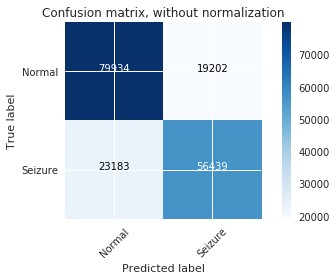

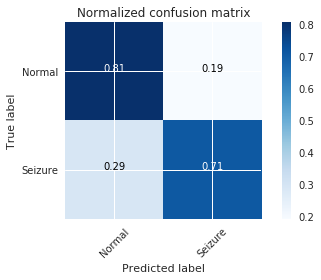

             precision    recall  f1-score   support

     Normal     0.7752    0.8063    0.7904     99136
    Seizure     0.7461    0.7088    0.7270     79622

avg / total     0.7622    0.7629    0.7622    178758

....................................................................


sensitivity_specificity None: (array([0.81, 0.71]), array([0.71, 0.81]), array([99136, 79622]))
sensitivity_specificity micro: (0.762891730719744, 0.762891730719744, None)
sensitivity_specificity macro: (0.7575716208589296, 0.7575716208589296, None)
sensitivity_specificity weighted: (0.762891730719744, 0.7522515109981152, None)




F1 None: [0.79 0.73]


F1 micro: 0.762891730719744


F1 macro: 0.7587236640824362


F1 weighted: 0.7621854922314221




precision None: 0.762891730719744


precision micro: 0.762891730719744


precision macro: 0.762891730719744


precision weighted: 0.762891730719744




recall None: 0.762891730719744


recall micro: 0.762891730719744


recall macro: 0.762891730719744


recall 

In [11]:
import itertools

print(grid_sclf.best_estimator_)
print(grid_sclf.best_params_)
print('...................................................................\n\n')

#Prediction
y_predict = grid_sclf.predict(x_test)

print('Accuracy of MLP Model: {}\n\n' .format((accuracy_score(y_test,y_predict))))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
#generate and plot confusion matrix
target_names = ['Normal', 'Seizure']

cnf_matrix = confusion_matrix(y_test,y_predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#Classification Report

print(classification_report(y_test, y_predict, digits=4, target_names=target_names))
#print(classification_report_imbalanced(y_test, y_predict, target_names=target_names, digits=4))

print('....................................................................\n\n')

#micro recall, precesion, specificity
for i in [None, 'micro', 'macro', 'weighted']:
    print('sensitivity_specificity {}: {}'.format(i, sensitivity_specificity_support(y_test, y_predict, average=i)))
print('\n')
for i in [None, 'micro', 'macro', 'weighted']:
    print('\n\nF1 {}: {}'.format(i, f1_score(y_test, y_predict, average=i)))
print('\n')
for i in [None, 'micro', 'macro', 'weighted']:
    print('\n\nprecision {}: {}'.format(i,precision_score(y_test, y_predict, average='micro')))
print('\n')
for i in [None, 'micro', 'macro', 'weighted']:
    print('\n\nrecall {}: {}'.format(i, recall_score(y_test, y_predict, average='micro')))

### Single patient test

In [2]:
# Reading the Dataset
lebaledCSVFilePath = '/home/mirwais/notebooks/paper_3/data/single_channel/lebaled/chb01_time_freq_segments.csv'
df = pd.read_csv(lebaledCSVFilePath)
df.columns.size

41

In [3]:
df.columns

Index(['Unnamed: 0', 'recordingID', 'time', 'max', 'mean', 'std', 'rms',
       'kurtosis', 'cov', 'skewness', 'delta_mean', 'theta_mean', 'alpha_mean',
       'beta_mean', 'all_mean', 'delta_std', 'theta_std', 'alpha_std',
       'beta_std', 'all_std', 'delta_cov', 'theta_cov', 'alpha_cov',
       'beta_cov', 'all_cov', 'delta_kurtosis', 'theta_kurtosis',
       'alpha_kurtosis', 'beta_kurtosis', 'all_kurtosis', 'delta_skew',
       'theta_skew', 'alpha_skew', 'beta_skew', 'all_skew', 'delta_rms',
       'theta_rms', 'alpha_rms', 'beta_rms', 'all_rms', 'sz'],
      dtype='object')

In [4]:
normal, seizure = df["sz"].value_counts()
print('Normal = {}\n Seziure = {}'.format(normal, seizure))

Normal = 12371
 Seziure = 229


In [5]:
# Feature Selection before MLP
# Feature selection using anova F score and p score values

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def select_kbest_clf(data_frame, target, k):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    feat_selector = SelectKBest(f_classif, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores

features = df.drop(['Unnamed: 0', 'recordingID', 'time',], axis=1)
# for 1% => k=30 (remove 7 features), for 50% => k=33 (remove 4 features)
res = pd.DataFrame(select_kbest_clf(features, 'sz', 30))
f = res.loc[res['Support'] != True]
a=[]
for i in f['Attribute']:
    a.append(i)
    
res

F Score        P Value  Support       Attribute
0   1168.996329  4.351381e-245     True             max
1   1179.813272  3.077692e-247     True            mean
2    920.636172  3.078402e-195     True             std
3   1099.882026  2.623869e-231     True             rms
4      5.100812   2.393168e-02     True        kurtosis
5     29.135977   6.869504e-08     True             cov
6     12.883211   3.328020e-04     True        skewness
7    433.060464   1.356111e-94     True      delta_mean
8   1899.840526   0.000000e+00     True      theta_mean
9   1022.668764  7.897176e-216     True      alpha_mean
10  1634.900000   0.000000e+00     True       beta_mean
11   855.083198  6.321062e-182     True        all_mean
12   375.693646   1.704873e-82     True       delta_std
13  1572.469951  4.940656e-324     True       theta_std
14   947.822356  9.696257e-201     True       alpha_std
15   809.939389  1.016312e-172     True        beta_std
16   482.496120  5.640472e-105     True         all_std
17     5.748437   1.651780e-02     True       delta_cov
18    96.749205   9.502300e-23     True       theta_cov
19    21.681273   3.252071e-06     True       alpha_cov
20   194.912474   5.721617e-44     True        beta_cov
21     3.166441   7.519016e-02    False         all_cov
22     0.544040   4.607768e-01    False  delta_kurtosis
23    11.244979   8.007397e-04     True  theta_kurtosis
24     0.307754   5.790714e-01    False  alpha_kurtosis
25    83.371312   7.826820e-20     True   beta_kurtosis
26     2.030081   1.542371e-01    False    all_kurtosis
27     0.701521   4.022888e-01    False      delta_skew
28    38.601782   5.360903e-10     True      theta_skew
29     0.076430   7.821992e-01    False      alpha_skew
30   148.631664   5.364130e-34     True       beta_skew
31     3.099874   7.832262e-02    False        all_skew
32   418.970762   1.255082e-91     True       delta_rms
33  1851.137364   0.000000e+00     True       theta_rms
34  1056.841549  1.086701e-222     True       alpha_rms
35  1274.853498  4.647537e-266     True        beta_rms
36   494.240952  1.954914e-107     True         all_rms

In [7]:
a

['all_cov',
 'delta_kurtosis',
 'alpha_kurtosis',
 'all_kurtosis',
 'delta_skew',
 'alpha_skew',
 'all_skew']

In [8]:
# Without oversampling of Smothe method
x = df.drop(['sz','Unnamed: 0', 'recordingID', 'time',], axis=1)
x = x.drop(a, axis=1)
y = df['sz']

#dissimilar scales of data, normalization (0,1) should be used
sc = MinMaxScaler(feature_range=(0, 1))
sc.fit(x)
x_std = sc.transform(x)

# Apply StratifiedKFold with GridSearchCV on MPL Classifier

# Splitting 
x_train, x_test, y_train, y_test = train_test_split(x_std, y, train_size=0.7, test_size=0.3, random_state=random_state)

#Cross validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state = random_state)

def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units = 19, kernel_initializer = 'uniform', activation = 'relu', input_dim = 30))
    classifier.add(Dense(units = 19, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn = build_classifier)

params = {'batch_size': [10, 20],
              'epochs': [100],
              'optimizer': ['adam', 'sgd'],
             'class_weight' : [{0: 1., 1: 50.}]
         }

grid_sclf = GridSearchCV(estimator = classifier, param_grid = params, cv = cv, n_jobs=-1, scoring='f1_weighted', verbose=4)

grid_sclf.fit(x_train, y_train)


Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] batch_size=10, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=adam 
[CV] batch_size=10, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=adam 
[CV] batch_size=10, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=adam 
[CV] batch_size=10, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=adam 
[CV] batch_size=10, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=adam 
[CV] batch_size=10, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=adam 
[CV] batch_size=10, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=adam 
[CV] batch_size=10, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=adam 
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
7937/7937 [==============================] - 2s 290us/step - loss: 1.1920 - acc: 0.9685
Epoch 2/100
7939/7939 [==============================] - 3s 317us/step - loss: 1.1945 - acc: 0.8574
Epoch 2/100
793

7937/7937 [==============================] - 2s 265us/step - loss: 0.7205 - acc: 0.8793
Epoch 9/100
7939/7939 [==============================] - 2s 297us/step - loss: 0.8672 - acc: 0.8738
Epoch 9/100
7937/7937 [==============================] - 2s 308us/step - loss: 0.8582 - acc: 0.8956
Epoch 9/100
7937/7937 [==============================] - 2s 269us/step - loss: 0.7158 - acc: 0.8919
Epoch 9/100
7937/7937 [==============================] - 2s 295us/step - loss: 0.6951 - acc: 0.8958
Epoch 10/100
7937/7937 [==============================] - 2s 303us/step - loss: 0.7272 - acc: 0.8885
Epoch 10/100
7939/7939 [==============================] - 2s 282us/step - loss: 0.8489 - acc: 0.8665
Epoch 10/100
7937/7937 [==============================] - 2s 296us/step - loss: 0.8306 - acc: 0.8842
Epoch 10/100
7939/7939 [==============================] - 2s 261us/step - loss: 0.7151 - acc: 0.8887
Epoch 10/100
7937/7937 [==============================] - 2s 302us/step - loss: 0.7154 - acc: 0.8890
Epoch 1

7939/7939 [==============================] - 3s 316us/step - loss: 0.6828 - acc: 0.8604
Epoch 24/100
7937/7937 [==============================] - 3s 325us/step - loss: 0.7299 - acc: 0.8704
Epoch 24/100
7937/7937 [==============================] - 2s 312us/step - loss: 0.7086 - acc: 0.8622
Epoch 24/100
7939/7939 [==============================] - 2s 294us/step - loss: 0.7283 - acc: 0.8551
Epoch 24/100
7937/7937 [==============================] - 3s 326us/step - loss: 0.6806 - acc: 0.8748
Epoch 24/100
7937/7937 [==============================] - 2s 273us/step - loss: 0.6853 - acc: 0.8700
Epoch 25/100
7937/7937 [==============================] - 2s 313us/step - loss: 0.7101 - acc: 0.8540
Epoch 25/100
7937/7937 [==============================] - 2s 315us/step - loss: 0.6651 - acc: 0.8714
Epoch 25/100
7939/7939 [==============================] - 2s 302us/step - loss: 0.6903 - acc: 0.8635
Epoch 26/100
7939/7939 [==============================] - 2s 292us/step - loss: 0.7258 - acc: 0.8517
Epo

7939/7939 [==============================] - 2s 297us/step - loss: 0.7133 - acc: 0.8443
Epoch 31/100
7937/7937 [==============================] - 3s 319us/step - loss: 0.6517 - acc: 0.8826
Epoch 31/100
7937/7937 [==============================] - 2s 312us/step - loss: 0.6973 - acc: 0.8510
Epoch 31/100
7939/7939 [==============================] - 3s 341us/step - loss: 0.6757 - acc: 0.8670
Epoch 32/100
7937/7937 [==============================] - 2s 312us/step - loss: 0.7040 - acc: 0.8578
Epoch 32/100
7937/7937 [==============================] - 2s 264us/step - loss: 0.6432 - acc: 0.8803
Epoch 32/100
7937/7937 [==============================] - 2s 291us/step - loss: 0.6549 - acc: 0.8683
Epoch 32/100
7939/7939 [==============================] - 2s 262us/step - loss: 0.6765 - acc: 0.8599
Epoch 32/100
7939/7939 [==============================] - 2s 305us/step - loss: 0.7036 - acc: 0.8556
Epoch 32/100
7939/7939 [==============================] - 2s 287us/step - loss: 0.6745 - acc: 0.8570
Epo

7937/7937 [==============================] - 2s 293us/step - loss: 0.6233 - acc: 0.8783
Epoch 47/100
7937/7937 [==============================] - 2s 209us/step - loss: 0.6412 - acc: 0.8649
Epoch 48/100
7939/7939 [==============================] - 3s 319us/step - loss: 0.6619 - acc: 0.8612
Epoch 47/100
7937/7937 [==============================] - 3s 335us/step - loss: 0.6819 - acc: 0.8516
Epoch 47/100
7939/7939 [==============================] - 3s 316us/step - loss: 0.6719 - acc: 0.8540
Epoch 47/100
7937/7937 [==============================] - 2s 288us/step - loss: 0.6238 - acc: 0.8827
Epoch 47/100
7939/7939 [==============================] - 3s 322us/step - loss: 0.6868 - acc: 0.8494
Epoch 47/100
7937/7937 [==============================] - 2s 225us/step - loss: 0.6293 - acc: 0.8661
Epoch 49/100
7937/7937 [==============================] - 2s 294us/step - loss: 0.6776 - acc: 0.8434
Epoch 48/100
7937/7937 [==============================] - 2s 310us/step - loss: 0.6120 - acc: 0.8785
Epo

7937/7937 [==============================] - 3s 345us/step - loss: 0.5810 - acc: 0.8920
Epoch 64/100
7937/7937 [==============================] - 2s 312us/step - loss: 0.6735 - acc: 0.8525
Epoch 64/100
7939/7939 [==============================] - 2s 313us/step - loss: 0.6520 - acc: 0.8563
Epoch 63/100
7939/7939 [==============================] - 2s 267us/step - loss: 0.6459 - acc: 0.8550
Epoch 63/100
7937/7937 [==============================] - 2s 301us/step - loss: 0.6616 - acc: 0.8561
Epoch 64/100
7937/7937 [==============================] - 3s 321us/step - loss: 0.6752 - acc: 0.8497
Epoch 65/100
7937/7937 [==============================] - 2s 312us/step - loss: 0.6688 - acc: 0.8607
Epoch 65/100
7937/7937 [==============================] - 2s 304us/step - loss: 0.5862 - acc: 0.8794
Epoch 66/100
7937/7937 [==============================] - 2s 283us/step - loss: 0.5504 - acc: 0.8887
Epoch 65/100
7937/7937 [==============================] - 2s 271us/step - loss: 0.5958 - acc: 0.8869
Epo

7937/7937 [==============================] - 2s 298us/step - loss: 0.6529 - acc: 0.8449
Epoch 78/100
7937/7937 [==============================] - 2s 285us/step - loss: 0.6558 - acc: 0.8569
Epoch 78/100
7937/7937 [==============================] - 2s 306us/step - loss: 0.5695 - acc: 0.9024
Epoch 78/100
7937/7937 [==============================] - 3s 320us/step - loss: 0.4970 - acc: 0.8881
Epoch 78/100
7939/7939 [==============================] - 2s 298us/step - loss: 0.6237 - acc: 0.8627
Epoch 78/100
7937/7937 [==============================] - 3s 320us/step - loss: 0.6553 - acc: 0.8550
Epoch 79/100
7937/7937 [==============================] - 2s 278us/step - loss: 0.6342 - acc: 0.8522
Epoch 79/100
7939/7939 [==============================] - 2s 304us/step - loss: 0.6378 - acc: 0.8691
Epoch 80/100
7939/7939 [==============================] - 3s 315us/step - loss: 0.6354 - acc: 0.8611
Epoch 79/100
7937/7937 [==============================] - 2s 313us/step - loss: 0.6550 - acc: 0.8521
Epo

7939/7939 [==============================] - 2s 295us/step - loss: 0.6153 - acc: 0.8626
Epoch 92/100
7937/7937 [==============================] - 2s 293us/step - loss: 0.4826 - acc: 0.8983
Epoch 91/100
7937/7937 [==============================] - 2s 284us/step - loss: 0.6356 - acc: 0.8609
Epoch 92/100
7937/7937 [==============================] - 2s 290us/step - loss: 0.6385 - acc: 0.8428
Epoch 92/100
7937/7937 [==============================] - 3s 322us/step - loss: 0.4848 - acc: 0.8967
Epoch 92/100
7937/7937 [==============================] - 2s 291us/step - loss: 0.5440 - acc: 0.9029
Epoch 92/100
7937/7937 [==============================] - 2s 278us/step - loss: 0.6270 - acc: 0.8528
Epoch 93/100
7939/7939 [==============================] - 2s 256us/step - loss: 0.6129 - acc: 0.8825
Epoch 92/100
7937/7937 [==============================] - 2s 304us/step - loss: 0.5439 - acc: 0.9026
Epoch 93/100
7937/7937 [==============================] - 2s 276us/step - loss: 0.6324 - acc: 0.8569
Epo

7937/7937 [==============================] - 2s 309us/step - loss: 0.5289 - acc: 0.8973
Epoch 99/100
7939/7939 [==============================] - 2s 292us/step - loss: 0.5956 - acc: 0.8768
Epoch 99/100
7939/7939 [==============================] - 2s 306us/step - loss: 0.5886 - acc: 0.8705
Epoch 100/100
7937/7937 [==============================] - 2s 298us/step - loss: 0.6069 - acc: 0.8630
Epoch 100/100
7937/7937 [==============================] - 3s 319us/step - loss: 0.5374 - acc: 0.8937
Epoch 100/100
7937/7937 [==============================] - 3s 319us/step - loss: 0.6199 - acc: 0.8585
Epoch 100/100
7937/7937 [==============================] - 2s 289us/step - loss: 0.4461 - acc: 0.9013
Epoch 100/100
7939/7939 [==============================] - 2s 303us/step - loss: 0.5968 - acc: 0.8836
Epoch 100/100
2340/7939 [=======>......................] - ETA: 1s - loss: 0.5847 - acc: 0.8850[CV]  batch_size=10, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=adam, score=0.9122369163651246

7937/7937 [==============================] - 2s 285us/step - loss: 0.7449 - acc: 0.8644
Epoch 13/100
7937/7937 [==============================] - 2s 234us/step - loss: 0.7449 - acc: 0.8662
Epoch 13/100
7937/7937 [==============================] - 2s 256us/step - loss: 0.7573 - acc: 0.8503
Epoch 14/100
7939/7939 [==============================] - 2s 263us/step - loss: 0.7166 - acc: 0.8936
Epoch 13/100
7937/7937 [==============================] - 2s 259us/step - loss: 0.7853 - acc: 0.8546
Epoch 14/100
7937/7937 [==============================] - 2s 295us/step - loss: 0.7450 - acc: 0.8607
Epoch 14/100
7937/7937 [==============================] - 2s 272us/step - loss: 0.7820 - acc: 0.8622
Epoch 14/100
7937/7937 [==============================] - 2s 243us/step - loss: 0.7511 - acc: 0.8525
Epoch 15/100
7937/7937 [==============================] - 2s 252us/step - loss: 0.7494 - acc: 0.8833
Epoch 15/100
7937/7937 [==============================] - 2s 247us/step - loss: 0.7383 - acc: 0.8578
Epo

7937/7937 [==============================] - 2s 296us/step - loss: 0.7214 - acc: 0.8589
Epoch 28/100
7939/7939 [==============================] - 2s 249us/step - loss: 0.7030 - acc: 0.8669
Epoch 27/100
7937/7937 [==============================] - 2s 274us/step - loss: 0.7042 - acc: 0.8760
Epoch 29/100
7939/7939 [==============================] - 2s 275us/step - loss: 0.6812 - acc: 0.8879
Epoch 27/100
7937/7937 [==============================] - 3s 319us/step - loss: 0.6615 - acc: 0.8814
Epoch 29/100
7937/7937 [==============================] - 2s 260us/step - loss: 0.6944 - acc: 0.8793
Epoch 29/100
7939/7939 [==============================] - 2s 264us/step - loss: 0.7180 - acc: 0.8671
Epoch 28/100
7939/7939 [==============================] - 2s 299us/step - loss: 0.6434 - acc: 0.8715
Epoch 28/100
7937/7937 [==============================] - 2s 245us/step - loss: 0.6952 - acc: 0.8663
Epoch 31/100
7939/7939 [==============================] - 2s 304us/step - loss: 0.6855 - acc: 0.8795
Epo

7937/7937 [==============================] - 2s 268us/step - loss: 0.6521 - acc: 0.8717
Epoch 44/100
7939/7939 [==============================] - 2s 271us/step - loss: 0.6441 - acc: 0.8914
Epoch 41/100
7939/7939 [==============================] - 2s 307us/step - loss: 0.6239 - acc: 0.8638
Epoch 41/100
7937/7937 [==============================] - 2s 270us/step - loss: 0.6396 - acc: 0.8811
Epoch 43/100
7937/7937 [==============================] - 2s 257us/step - loss: 0.6431 - acc: 0.8832
Epoch 44/100
7939/7939 [==============================] - 2s 250us/step - loss: 0.6589 - acc: 0.8884
Epoch 42/100
7937/7937 [==============================] - 2s 241us/step - loss: 0.6601 - acc: 0.8740
Epoch 46/100
7937/7937 [==============================] - 2s 277us/step - loss: 0.6759 - acc: 0.8925
Epoch 45/100
7937/7937 [==============================] - 2s 238us/step - loss: 0.6769 - acc: 0.8720
Epoch 44/100
7939/7939 [==============================] - 2s 304us/step - loss: 0.6404 - acc: 0.8769
Epo

7939/7939 [==============================] - 2s 271us/step - loss: 0.5799 - acc: 0.8991
Epoch 55/100
7937/7937 [==============================] - 2s 250us/step - loss: 0.6194 - acc: 0.8919
Epoch 59/100
7937/7937 [==============================] - 2s 270us/step - loss: 0.6504 - acc: 0.8775
Epoch 60/100
7937/7937 [==============================] - 2s 265us/step - loss: 0.6418 - acc: 0.8924
Epoch 59/100
7937/7937 [==============================] - 2s 218us/step - loss: 0.6425 - acc: 0.8846
Epoch 61/100
7939/7939 [==============================] - 2s 271us/step - loss: 0.5933 - acc: 0.8905
Epoch 56/100
7937/7937 [==============================] - 2s 216us/step - loss: 0.6449 - acc: 0.8804
Epoch 61/100
7937/7937 [==============================] - 2s 291us/step - loss: 0.6172 - acc: 0.8856
Epoch 60/100
7937/7937 [==============================] - 2s 275us/step - loss: 0.6418 - acc: 0.8956
Epoch 61/100
7939/7939 [==============================] - 2s 288us/step - loss: 0.5735 - acc: 0.8876
Epo

7937/7937 [==============================] - 2s 276us/step - loss: 0.6321 - acc: 0.8864
Epoch 75/100
7937/7937 [==============================] - 2s 225us/step - loss: 0.6291 - acc: 0.8748
Epoch 76/100
7937/7937 [==============================] - 2s 253us/step - loss: 0.6178 - acc: 0.8922
Epoch 76/100
7939/7939 [==============================] - 2s 256us/step - loss: 0.6140 - acc: 0.8858
Epoch 73/100
7937/7937 [==============================] - 2s 266us/step - loss: 0.6469 - acc: 0.8792
Epoch 77/100
7937/7937 [==============================] - 2s 272us/step - loss: 0.6276 - acc: 0.8887
Epoch 77/100
7939/7939 [==============================] - 2s 288us/step - loss: 0.5832 - acc: 0.8526
Epoch 71/100
7937/7937 [==============================] - 2s 259us/step - loss: 0.5938 - acc: 0.8812
Epoch 77/100
7937/7937 [==============================] - 2s 264us/step - loss: 0.6304 - acc: 0.8879
Epoch 78/100
7939/7939 [==============================] - 2s 286us/step - loss: 0.5430 - acc: 0.8936
Epo

7939/7939 [==============================] - 2s 290us/step - loss: 0.5191 - acc: 0.9070
Epoch 82/100
7937/7937 [==============================] - 2s 259us/step - loss: 0.6039 - acc: 0.8804
Epoch 88/100
7939/7939 [==============================] - 2s 269us/step - loss: 0.6252 - acc: 0.8851
Epoch 87/100
7937/7937 [==============================] - 2s 243us/step - loss: 0.6173 - acc: 0.8972
Epoch 91/100
7939/7939 [==============================] - 2s 281us/step - loss: 0.5664 - acc: 0.8522
Epoch 83/100
7937/7937 [==============================] - 2s 259us/step - loss: 0.6025 - acc: 0.8784
Epoch 89/100
7937/7937 [==============================] - 2s 298us/step - loss: 0.6245 - acc: 0.8763
Epoch 91/100
7937/7937 [==============================] - 2s 261us/step - loss: 0.5819 - acc: 0.8877
Epoch 89/100
7937/7937 [==============================] - 2s 272us/step - loss: 0.6223 - acc: 0.8760
Epoch 92/100
7939/7939 [==============================] - 2s 279us/step - loss: 0.5746 - acc: 0.8568
Epo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  7.5min


7939/7939 [==============================] - 2s 262us/step - loss: 0.5630 - acc: 0.8570
Epoch 93/100
7937/7937 [==============================] - 2s 264us/step - loss: 0.5890 - acc: 0.8918
Epoch 99/100
 560/7939 [=>............................] - ETA: 2s - loss: 0.3618 - acc: 0.89112[CV]  batch_size=10, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=sgd, score=0.930084948014068, total= 3.5min
[CV] batch_size=10, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=sgd 
7939/7939 [==============================] - 2s 258us/step - loss: 0.5986 - acc: 0.8611
Epoch 98/100
7939/7939 [==============================] - 2s 257us/step - loss: 0.4852 - acc: 0.9033
Epoch 93/100
6020/7939 [=====================>........] - ETA: 0s - loss: 0.5852 - acc: 0.8495[CV]  batch_size=10, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=sgd, score=0.9224247527557753, total= 3.6min
[CV] batch_size=10, class_weight={0: 1.0, 1: 50.0}, epochs=100, optimizer=sgd 
7939/7939 [=========================

7937/7937 [==============================] - 1s 157us/step - loss: 0.7272 - acc: 0.8835
Epoch 15/100
7939/7939 [==============================] - 2s 260us/step - loss: 0.8641 - acc: 0.8359
Epoch 11/100
7937/7937 [==============================] - 1s 152us/step - loss: 0.7084 - acc: 0.8905
Epoch 14/100
7937/7937 [==============================] - 1s 154us/step - loss: 0.7227 - acc: 0.8899
Epoch 4/100
7937/7937 [==============================] - 1s 131us/step - loss: 0.7105 - acc: 0.8856
Epoch 15/100
7939/7939 [==============================] - 2s 270us/step - loss: 0.7663 - acc: 0.8706
Epoch 13/100
7939/7939 [==============================] - 2s 259us/step - loss: 0.7873 - acc: 0.8672
Epoch 12/100
7937/7937 [==============================] - 1s 141us/step - loss: 0.7114 - acc: 0.8870
Epoch 16/100
7939/7939 [==============================] - 2s 263us/step - loss: 0.8341 - acc: 0.8349
Epoch 11/100
7937/7937 [==============================] - 1s 156us/step - loss: 0.7474 - acc: 0.8949
Epoc

7937/7937 [==============================] - 1s 153us/step - loss: 0.7047 - acc: 0.8808
Epoch 21/100
7937/7937 [==============================] - 1s 160us/step - loss: 0.6876 - acc: 0.8604
Epoch 32/100
7937/7937 [==============================] - 1s 153us/step - loss: 0.6947 - acc: 0.8657
Epoch 34/100
7937/7937 [==============================] - 1s 146us/step - loss: 0.6731 - acc: 0.8683
Epoch 22/100
7937/7937 [==============================] - 1s 148us/step - loss: 0.7080 - acc: 0.8785
Epoch 22/100
7937/7937 [==============================] - 1s 143us/step - loss: 0.6787 - acc: 0.8701
Epoch 33/100
7939/7939 [==============================] - 2s 236us/step - loss: 0.7288 - acc: 0.8677
Epoch 23/100
7939/7939 [==============================] - 2s 258us/step - loss: 0.7144 - acc: 0.8927
Epoch 22/100
7937/7937 [==============================] - 1s 163us/step - loss: 0.6933 - acc: 0.8725
Epoch 35/100
7937/7937 [==============================] - 1s 138us/step - loss: 0.7067 - acc: 0.8847
Epo

Epoch 31/100
7939/7939 [==============================] - 3s 325us/step - loss: 0.6878 - acc: 0.8540
Epoch 25/100
7937/7937 [==============================] - 1s 174us/step - loss: 0.6945 - acc: 0.8595
Epoch 43/100
7939/7939 [==============================] - 2s 287us/step - loss: 0.6929 - acc: 0.8560
Epoch 28/100
7937/7937 [==============================] - 1s 148us/step - loss: 0.6646 - acc: 0.8778
Epoch 32/100
7939/7939 [==============================] - 2s 280us/step - loss: 0.6770 - acc: 0.8957
Epoch 27/100
7937/7937 [==============================] - 1s 141us/step - loss: 0.6864 - acc: 0.8720
Epoch 44/100
7937/7937 [==============================] - 1s 136us/step - loss: 0.6984 - acc: 0.8814
Epoch 32/100
7939/7939 [==============================] - 2s 269us/step - loss: 0.7134 - acc: 0.8849
Epoch 43/100
Epoch 28/100
7939/7939 [==============================] - 2s 285us/step - loss: 0.6829 - acc: 0.8541
Epoch 26/100
7937/7937 [==============================] - 1s 132us/step - loss

7939/7939 [==============================] - 2s 276us/step - loss: 0.6730 - acc: 0.8738
Epoch 38/100
7939/7939 [==============================] - 2s 250us/step - loss: 0.6376 - acc: 0.9088
Epoch 37/100
7937/7937 [==============================] - 1s 141us/step - loss: 0.6745 - acc: 0.8783
Epoch 62/100
7937/7937 [==============================] - 1s 140us/step - loss: 0.6468 - acc: 0.8535
Epoch 52/100
7939/7939 [==============================] - 2s 265us/step - loss: 0.6681 - acc: 0.8915
Epoch 36/100
7939/7939 [==============================] - 2s 244us/step - loss: 0.6857 - acc: 0.8617
Epoch 39/100
7937/7937 [==============================] - 1s 153us/step - loss: 0.6681 - acc: 0.8720
Epoch 52/100
7937/7937 [==============================] - 1s 151us/step - loss: 0.6487 - acc: 0.8697
Epoch 62/100
7937/7937 [==============================] - 1s 124us/step - loss: 0.6526 - acc: 0.8537
Epoch 53/100
3840/7937 [=============>................] - ETA: 0s - loss: 0.5512 - acc: 0.8911Epoch 64/1

7937/7937 [==============================] - 1s 158us/step - loss: 0.6319 - acc: 0.8673
Epoch 80/100
7939/7939 [==============================] - 2s 280us/step - loss: 0.6569 - acc: 0.8812
Epoch 49/100
7937/7937 [==============================] - 1s 180us/step - loss: 0.5906 - acc: 0.8814
Epoch 70/100
7937/7937 [==============================] - 1s 159us/step - loss: 0.6385 - acc: 0.8767
Epoch 81/100
7939/7939 [==============================] - 2s 249us/step - loss: 0.6369 - acc: 0.8762
Epoch 49/100
7937/7937 [==============================] - 1s 158us/step - loss: 0.6347 - acc: 0.8727
Epoch 71/100
7939/7939 [==============================] - 2s 261us/step - loss: 0.6251 - acc: 0.8880
Epoch 48/100
7937/7937 [==============================] - 1s 146us/step - loss: 0.6291 - acc: 0.8731
Epoch 81/100
7939/7939 [==============================] - 2s 270us/step - loss: 0.6442 - acc: 0.8694
Epoch 47/100
7939/7939 [==============================] - 2s 225us/step - loss: 0.6582 - acc: 0.8831
Epo

Epoch 90/100
7937/7937 [==============================] - 1s 139us/step - loss: 0.6162 - acc: 0.8593
Epoch 80/100
7939/7939 [==============================] - 2s 266us/step - loss: 0.6146 - acc: 0.8929
Epoch 53/100
7937/7937 [==============================] - 1s 157us/step - loss: 0.5628 - acc: 0.8724
Epoch 80/100
7937/7937 [==============================] - 1s 146us/step - loss: 0.6194 - acc: 0.8775
Epoch 91/100
7937/7937 [==============================] - 1s 146us/step - loss: 0.6080 - acc: 0.8760
Epoch 81/100
7939/7939 [==============================] - 2s 217us/step - loss: 0.6545 - acc: 0.8701
Epoch 56/100
7937/7937 [==============================] - 1s 133us/step - loss: 0.6429 - acc: 0.8818
Epoch 92/100
7937/7937 [==============================] - 1s 138us/step - loss: 0.6108 - acc: 0.8715
Epoch 92/100
7937/7937 [==============================] - 1s 132us/step - loss: 0.6106 - acc: 0.8743
Epoch 82/100
7939/7939 [==============================] - 2s 264us/step - loss: 0.6359 - ac

7937/7937 [==============================] - 1s 162us/step - loss: 0.5636 - acc: 0.8809
Epoch 99/100
7939/7939 [==============================] - 2s 269us/step - loss: 0.6253 - acc: 0.8840
Epoch 8/100
Epoch 63/100
7939/7939 [==============================] - 2s 258us/step - loss: 0.6452 - acc: 0.8859
Epoch 66/100
7939/7939 [==============================] - 2s 264us/step - loss: 0.6088 - acc: 0.8716
Epoch 62/100
7937/7937 [==============================] - 1s 153us/step - loss: 0.6972 - acc: 0.8930
Epoch 10/100
7939/7939 [==============================] - 2s 230us/step - loss: 0.6065 - acc: 0.8866
Epoch 63/100
7939/7939 [==============================] - 2s 252us/step - loss: 0.6361 - acc: 0.8885
Epoch 67/100
7939/7939 [==============================] - 2s 247us/step - loss: 0.6381 - acc: 0.8597
Epoch 66/100
7939/7939 [==============================] - 1s 149us/step - loss: 0.7158 - acc: 0.8863
Epoch 10/100
7939/7939 [==============================] - 2s 220us/step - loss: 0.6096 - acc

7937/7937 [==============================] - 1s 152us/step - loss: 0.6715 - acc: 0.8808
Epoch 25/100
7939/7939 [==============================] - 2s 271us/step - loss: 0.5711 - acc: 0.8820
Epoch 72/100
7939/7939 [==============================] - 1s 149us/step - loss: 0.7326 - acc: 0.8817
Epoch 16/100
7937/7937 [==============================] - 1s 139us/step - loss: 0.6703 - acc: 0.8826
Epoch 26/100
7939/7939 [==============================] - 2s 267us/step - loss: 0.6258 - acc: 0.8895
Epoch 76/100
7939/7939 [==============================] - 1s 170us/step - loss: 0.6986 - acc: 0.8902
Epoch 17/100
7937/7937 [==============================] - 1s 145us/step - loss: 0.6617 - acc: 0.8827
Epoch 27/100
7939/7939 [==============================] - 2s 246us/step - loss: 0.6115 - acc: 0.9041
Epoch 74/100
7939/7939 [==============================] - 2s 253us/step - loss: 0.6302 - acc: 0.8684
Epoch 76/100
7939/7939 [==============================] - 1s 117us/step - loss: 0.6702 - acc: 0.8598
Epo

7939/7939 [==============================] - 2s 294us/step - loss: 0.5659 - acc: 0.8671
Epoch 77/100
7939/7939 [==============================] - 1s 151us/step - loss: 0.7081 - acc: 0.8728
Epoch 25/100
7939/7939 [==============================] - 2s 252us/step - loss: 0.6266 - acc: 0.8883
Epoch 81/100
7939/7939 [==============================] - 2s 236us/step - loss: 0.6080 - acc: 0.8951
Epoch 79/100
7939/7939 [==============================] - 1s 173us/step - loss: 0.6705 - acc: 0.8696
Epoch 35/100
7937/7937 [==============================] - 1s 162us/step - loss: 0.6596 - acc: 0.8780
Epoch 36/100
7939/7939 [==============================] - 2s 236us/step - loss: 0.6272 - acc: 0.8693
Epoch 81/100
7939/7939 [==============================] - 2s 294us/step - loss: 0.5972 - acc: 0.8774
Epoch 78/100
7939/7939 [==============================] - 1s 137us/step - loss: 0.6650 - acc: 0.8787
Epoch 36/100
7939/7939 [==============================] - 2s 287us/step - loss: 0.6281 - acc: 0.8894
Epo

Epoch 89/100
7939/7939 [==============================] - 1s 150us/step - loss: 0.6869 - acc: 0.8635
Epoch 44/100
7939/7939 [==============================] - 2s 241us/step - loss: 0.5605 - acc: 0.8598
Epoch 88/100
7939/7939 [==============================] - 2s 244us/step - loss: 0.6216 - acc: 0.8729
Epoch 92/100
7939/7939 [==============================] - 1s 130us/step - loss: 0.6878 - acc: 0.8637
Epoch 45/100
7939/7939 [==============================] - 1s 139us/step - loss: 0.6487 - acc: 0.8681
Epoch 55/100
7939/7939 [==============================] - 1s 146us/step - loss: 0.6752 - acc: 0.8742
Epoch 46/100
7939/7939 [==============================] - 1s 125us/step - loss: 0.6352 - acc: 0.8657
Epoch 56/100
7939/7939 [==============================] - 2s 256us/step - loss: 0.6051 - acc: 0.8725
Epoch 92/100
7939/7939 [==============================] - 2s 277us/step - loss: 0.6097 - acc: 0.8881
Epoch 91/100
7937/7937 [==============================] - 1s 167us/step - loss: 0.6366 - ac

7939/7939 [==============================] - 1s 131us/step - loss: 0.5942 - acc: 0.8739
Epoch 73/100
7939/7939 [==============================] - 1s 168us/step - loss: 1.2444 - acc: 0.4506
Epoch 2/100
7937/7937 [==============================] - 1s 156us/step - loss: 0.6210 - acc: 0.8818
Epoch 74/100
7939/7939 [==============================] - 1s 166us/step - loss: 0.6778 - acc: 0.8564
Epoch 64/100
7939/7939 [==============================] - 2s 252us/step - loss: 0.5592 - acc: 0.8521
Epoch 100/100
7939/7939 [==============================] - 1s 141us/step - loss: 0.5943 - acc: 0.8750
Epoch 74/100
7939/7939 [==============================] - 1s 98us/step - loss: 0.8233 - acc: 0.8967
Epoch 3/100
7939/7939 [==============================] - 1s 149us/step - loss: 0.6677 - acc: 0.8648
Epoch 64/100
7937/7937 [==============================] - 1s 145us/step - loss: 0.6124 - acc: 0.8867
Epoch 75/100
7939/7939 [==============================] - 1s 96us/step - loss: 0.7607 - acc: 0.9072
Epoch 

7937/7937 [==============================] - 1s 105us/step - loss: 0.6059 - acc: 0.8809
Epoch 89/100
7939/7939 [==============================] - 1s 152us/step - loss: 0.6726 - acc: 0.8853
Epoch 14/100
7939/7939 [==============================] - 1s 127us/step - loss: 0.6978 - acc: 0.8937
Epoch 17/100
7939/7939 [==============================] - 1s 152us/step - loss: 0.6630 - acc: 0.8490
Epoch 77/100
7939/7939 [==============================] - 1s 154us/step - loss: 0.5644 - acc: 0.8898
Epoch 87/100
7939/7939 [==============================] - 1s 146us/step - loss: 0.6641 - acc: 0.8880
Epoch 15/100
7937/7937 [==============================] - 1s 141us/step - loss: 1.1258 - acc: 0.6904
Epoch 15/100
7939/7939 [==============================] - 1s 158us/step - loss: 0.6450 - acc: 0.8660
Epoch 78/100
7939/7939 [==============================] - 1s 148us/step - loss: 0.5610 - acc: 0.8786
Epoch 89/100
7937/7937 [==============================] - 1s 146us/step - loss: 1.2659 - acc: 0.7173
Epo

7937/7937 [==============================] - 1s 135us/step - loss: 1.3674 - acc: 0.6513
Epoch 3/100
7939/7939 [==============================] - 1s 163us/step - loss: 0.6447 - acc: 0.8807
Epoch 29/100
7937/7937 [==============================] - 1s 128us/step - loss: 0.7373 - acc: 0.8659
Epoch 28/100
7939/7939 [==============================] - 1s 166us/step - loss: 0.6511 - acc: 0.8616
Epoch 92/100
7939/7939 [==============================] - 1s 126us/step - loss: 0.6880 - acc: 0.8903
Epoch 33/100
7937/7937 [==============================] - 1s 138us/step - loss: 0.7625 - acc: 0.8540
Epoch 30/100
7937/7937 [==============================] - 1s 120us/step - loss: 1.3671 - acc: 0.5297
Epoch 4/100
7937/7937 [==============================] - 1s 116us/step - loss: 0.7284 - acc: 0.8743
Epoch 29/100
7939/7939 [==============================] - 1s 141us/step - loss: 0.6835 - acc: 0.8842
Epoch 34/100
7939/7939 [==============================] - 1s 151us/step - loss: 0.6453 - acc: 0.8588
Epoch

7939/7939 [==============================] - 1s 148us/step - loss: 0.6460 - acc: 0.8559
Epoch 99/100
7939/7939 [==============================] - 1s 141us/step - loss: 0.5901 - acc: 0.8913
Epoch 99/100
7937/7937 [==============================] - 1s 146us/step - loss: 1.3076 - acc: 0.8326
Epoch 12/100
7939/7939 [==============================] - 1s 159us/step - loss: 0.6428 - acc: 0.8798
Epoch 37/100
7937/7937 [==============================] - 1s 147us/step - loss: 0.7158 - acc: 0.8710
Epoch 38/100
7939/7939 [==============================] - 1s 138us/step - loss: 0.6835 - acc: 0.8941
Epoch 41/100
7937/7937 [==============================] - 1s 134us/step - loss: 1.3670 - acc: 0.3511
Epoch 9/100
7939/7939 [==============================] - 1s 165us/step - loss: 0.6399 - acc: 0.8551
Epoch 100/100
7939/7939 [==============================] - 1s 142us/step - loss: 0.5928 - acc: 0.8768
Epoch 100/100
7937/7937 [==============================] - 1s 133us/step - loss: 0.7292 - acc: 0.8614
Ep

7939/7939 [==============================] - 1s 126us/step - loss: 1.3650 - acc: 0.6581
Epoch 12/100
7937/7937 [==============================] - 1s 126us/step - loss: 0.7586 - acc: 0.8654
Epoch 24/100
7939/7939 [==============================] - 1s 150us/step - loss: 0.6253 - acc: 0.8655
Epoch 51/100
7937/7937 [==============================] - 1s 151us/step - loss: 0.6970 - acc: 0.8680
Epoch 54/100
7937/7937 [==============================] - 1s 126us/step - loss: 0.7010 - acc: 0.8642
Epoch 28/100
7937/7937 [==============================] - 1s 124us/step - loss: 0.7448 - acc: 0.8673
Epoch 25/100
7937/7937 [==============================] - 1s 110us/step - loss: 1.3178 - acc: 0.8172
Epoch 14/100
7939/7939 [==============================] - 1s 144us/step - loss: 0.6324 - acc: 0.8718
Epoch 52/100
7937/7937 [==============================] - 1s 145us/step - loss: 0.6856 - acc: 0.8803
Epoch 55/100
7937/7937 [==============================] - 1s 148us/step - loss: 0.7183 - acc: 0.8557
Epo

7939/7939 [==============================] - 1s 170us/step - loss: 0.6330 - acc: 0.8924
Epoch 69/100
7937/7937 [==============================] - 1s 138us/step - loss: 0.6757 - acc: 0.8777
Epoch 68/100
7937/7937 [==============================] - 1s 134us/step - loss: 0.6905 - acc: 0.8816
Epoch 28/100
7939/7939 [==============================] - 1s 119us/step - loss: 0.6200 - acc: 0.8735
Epoch 65/100
7937/7937 [==============================] - 1s 136us/step - loss: 0.6743 - acc: 0.8686
Epoch 68/100
Epoch 43/100
7939/7939 [==============================] - 1s 144us/step - loss: 0.6192 - acc: 0.8915
Epoch 70/100
7937/7937 [==============================] - 1s 121us/step - loss: 0.6878 - acc: 0.8890
Epoch 29/100
7937/7937 [==============================] - 1s 136us/step - loss: 0.6483 - acc: 0.8900
Epoch 69/100
7939/7939 [==============================] - 1s 171us/step - loss: 0.6158 - acc: 0.8763
Epoch 66/100
7937/7937 [==============================] - 1s 148us/step - loss: 0.6601 - ac

7937/7937 [==============================] - 1s 141us/step - loss: 0.6456 - acc: 0.8838
Epoch 57/100
7937/7937 [==============================] - 1s 158us/step - loss: 0.6603 - acc: 0.8667
Epoch 54/100
Epoch 82/100
7937/7937 [==============================] - 1s 144us/step - loss: 0.6445 - acc: 0.8885
Epoch 43/100
7939/7939 [==============================] - 1s 149us/step - loss: 0.6098 - acc: 0.8723
Epoch 79/100
7939/7939 [==============================] - 1s 160us/step - loss: 0.5809 - acc: 0.8987
Epoch 84/100
7937/7937 [==============================] - 1s 141us/step - loss: 0.6764 - acc: 0.8686
Epoch 55/100
7937/7937 [==============================] - 1s 160us/step - loss: 0.6262 - acc: 0.8782
Epoch 58/100
7939/7939 [==============================] - 1s 144us/step - loss: 0.6887 - acc: 0.8682
Epoch 43/100
7937/7937 [==============================] - 1s 161us/step - loss: 0.6350 - acc: 0.8962
Epoch 44/100
7937/7937 [==============================] - 1s 126us/step - loss: 0.6453 - ac

7937/7937 [==============================] - 1s 118us/step - loss: 0.6840 - acc: 0.8649
Epoch 69/100
7937/7937 [==============================] - 1s 112us/step - loss: 0.6455 - acc: 0.8963
Epoch 99/100
7937/7937 [==============================] - 1s 126us/step - loss: 0.6116 - acc: 0.8909
Epoch 72/100
7939/7939 [==============================] - 1s 131us/step - loss: 0.6014 - acc: 0.8724
Epoch 93/100
7937/7937 [==============================] - 1s 144us/step - loss: 0.6229 - acc: 0.9011
Epoch 59/100
7939/7939 [==============================] - 1s 146us/step - loss: 0.5449 - acc: 0.9052
Epoch 94/100
Epoch 99/100
7937/7937 [==============================] - 1s 111us/step - loss: 0.6211 - acc: 0.9010
Epoch 60/100
7939/7939 [==============================] - 1s 110us/step - loss: 0.6518 - acc: 0.8684
Epoch 59/100
7937/7937 [==============================] - 1s 144us/step - loss: 0.6006 - acc: 0.8956
Epoch 74/100
7937/7937 [==============================] - 1s 106us/step - loss: 0.6841 - ac

7939/7939 [==============================] - 1s 127us/step - loss: 0.6392 - acc: 0.8898
Epoch 71/100
7939/7939 [==============================] - 1s 158us/step - loss: 1.3585 - acc: 0.1359
Epoch 11/100
7937/7937 [==============================] - 1s 118us/step - loss: 0.6001 - acc: 0.8940
Epoch 87/100
7939/7939 [==============================] - 1s 112us/step - loss: 1.3712 - acc: 0.4402
Epoch 6/100
7939/7939 [==============================] - 1s 130us/step - loss: 1.3619 - acc: 0.5423
Epoch 12/100
Epoch 72/100
7939/7939 [==============================] - 1s 130us/step - loss: 1.3352 - acc: 0.6355
Epoch 12/100
7939/7939 [==============================] - 1s 141us/step - loss: 1.3703 - acc: 0.4630
Epoch 7/100
7939/7939 [==============================] - 1s 124us/step - loss: 0.9656 - acc: 0.7869
Epoch 14/100
7939/7939 [==============================] - 1s 135us/step - loss: 0.6373 - acc: 0.8742
Epoch 73/100
7937/7937 [==============================] - 1s 142us/step - loss: 0.6397 - acc:

Epoch 86/100
7939/7939 [==============================] - 1s 124us/step - loss: 0.7129 - acc: 0.8754
Epoch 21/100
7937/7937 [==============================] - 1s 127us/step - loss: 0.6067 - acc: 0.8993
Epoch 89/100
7939/7939 [==============================] - 1s 115us/step - loss: 0.7363 - acc: 0.8778
Epoch 27/100
7939/7939 [==============================] - 1s 103us/step - loss: 0.7493 - acc: 0.8646
Epoch 27/100
7939/7939 [==============================] - 1s 124us/step - loss: 0.6233 - acc: 0.8861
Epoch 87/100
7939/7939 [==============================] - 1s 108us/step - loss: 0.6984 - acc: 0.8698
Epoch 22/100
7939/7939 [==============================] - 1s 100us/step - loss: 0.7140 - acc: 0.8696
Epoch 29/100
7937/7937 [==============================] - 1s 115us/step - loss: 0.6045 - acc: 0.9084
Epoch 90/100
7939/7939 [==============================] - 1s 94us/step - loss: 0.7219 - acc: 0.8730
Epoch 28/100
7939/7939 [==============================] - 1s 113us/step - loss: 0.7364 - acc

[Parallel(n_jobs=-1)]: Done  36 out of  40 | elapsed: 13.6min remaining:  1.5min


7939/7939 [==============================] - 1s 79us/step - loss: 0.6904 - acc: 0.8687
Epoch 44/100
7939/7939 [==============================] - 1s 73us/step - loss: 0.7047 - acc: 0.8711
Epoch 44/100
7939/7939 [==============================] - 1s 72us/step - loss: 0.6921 - acc: 0.8703
Epoch 45/100
7939/7939 [==============================] - 1s 76us/step - loss: 0.6666 - acc: 0.8967
Epoch 45/100
7939/7939 [==============================] - 1s 91us/step - loss: 0.6754 - acc: 0.8666
Epoch 39/100
7939/7939 [==============================] - 1s 72us/step - loss: 0.6984 - acc: 0.8681
Epoch 45/100
7939/7939 [==============================] - 1s 73us/step - loss: 0.7093 - acc: 0.8638
Epoch 46/100
7939/7939 [==============================] - 1s 78us/step - loss: 0.6649 - acc: 0.8968
Epoch 46/100
7939/7939 [==============================] - 1s 72us/step - loss: 0.7026 - acc: 0.8749
Epoch 46/100
7939/7939 [==============================] - 1s 74us/step - loss: 0.6932 - acc: 0.8664
Epoch 47/100


7939/7939 [==============================] - 1s 95us/step - loss: 0.6355 - acc: 0.8800
Epoch 81/100
7939/7939 [==============================] - 1s 85us/step - loss: 0.6052 - acc: 0.9007
Epoch 81/100
7939/7939 [==============================] - 1s 81us/step - loss: 0.6473 - acc: 0.8674
Epoch 74/100
7939/7939 [==============================] - 1s 75us/step - loss: 0.6321 - acc: 0.8926
Epoch 81/100
7939/7939 [==============================] - 1s 82us/step - loss: 0.6380 - acc: 0.8937
Epoch 83/100
7939/7939 [==============================] - 1s 79us/step - loss: 0.6409 - acc: 0.8578
Epoch 75/100
7939/7939 [==============================] - 1s 90us/step - loss: 0.6140 - acc: 0.9011
Epoch 83/100
7939/7939 [==============================] - 1s 115us/step - loss: 0.6331 - acc: 0.8902
Epoch 84/100
7939/7939 [==============================] - 1s 75us/step - loss: 0.6388 - acc: 0.8866
Epoch 83/100
7939/7939 [==============================] - 1s 84us/step - loss: 0.6075 - acc: 0.9014
Epoch 84/100

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 14.4min finished


Epoch 1/100
8820/8820 [==============================] - 1s 72us/step - loss: 1.3700 - acc: 0.3210
Epoch 2/100
8820/8820 [==============================] - 0s 55us/step - loss: 1.3698 - acc: 0.4687
Epoch 3/100
8820/8820 [==============================] - 0s 56us/step - loss: 1.3697 - acc: 0.3660
Epoch 4/100
8820/8820 [==============================] - 0s 55us/step - loss: 1.3691 - acc: 0.1440
Epoch 5/100
8820/8820 [==============================] - 0s 55us/step - loss: 1.3676 - acc: 0.5040
Epoch 6/100
8820/8820 [==============================] - 0s 55us/step - loss: 1.3694 - acc: 0.4598
Epoch 7/100
8820/8820 [==============================] - 0s 55us/step - loss: 1.3685 - acc: 0.5824
Epoch 8/100
8820/8820 [==============================] - 0s 56us/step - loss: 1.3664 - acc: 0.6279
Epoch 9/100
8820/8820 [==============================] - 0s 56us/step - loss: 1.3640 - acc: 0.2793
Epoch 10/100
8820/8820 [==============================] - 0s 55us/step - loss: 1.3616 - acc: 0.5345
Epoch 11/

8820/8820 [==============================] - 0s 50us/step - loss: 0.6172 - acc: 0.8900
Epoch 84/100
8820/8820 [==============================] - 0s 52us/step - loss: 0.6210 - acc: 0.8879
Epoch 85/100
8820/8820 [==============================] - 0s 51us/step - loss: 0.6225 - acc: 0.8932
Epoch 86/100
8820/8820 [==============================] - 0s 52us/step - loss: 0.6142 - acc: 0.8850
Epoch 87/100
8820/8820 [==============================] - 0s 52us/step - loss: 0.6129 - acc: 0.8864
Epoch 88/100
8820/8820 [==============================] - 0s 51us/step - loss: 0.6002 - acc: 0.8925
Epoch 89/100
8820/8820 [==============================] - 0s 51us/step - loss: 0.6146 - acc: 0.8949
Epoch 90/100
8820/8820 [==============================] - 0s 51us/step - loss: 0.6155 - acc: 0.8853
Epoch 91/100
8820/8820 [==============================] - 0s 51us/step - loss: 0.6019 - acc: 0.8939
Epoch 92/100
8820/8820 [==============================] - 0s 51us/step - loss: 0.6076 - acc: 0.8837
Epoch 93/100


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2018, shuffle=True),
       error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7feefd141470>,
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'batch_size': [10, 20], 'epochs': [100], 'optimizer': ['adam', 'sgd'], 'class_weight': [{0: 1.0, 1: 50.0}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=4)

{'batch_size': 20, 'class_weight': {0: 1.0, 1: 50.0}, 'epochs': 100, 'optimizer': 'sgd'}
...................................................................


Accuracy of MLP Model: 0.8693121693121693


Confusion matrix, without normalization
[[3244  482]
 [  12   42]]
Normalized confusion matrix
[[0.87 0.13]
 [0.22 0.78]]


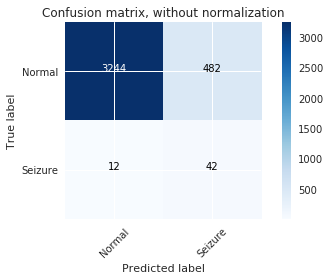

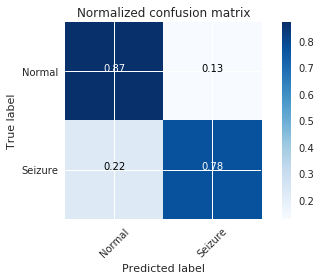

             precision    recall  f1-score   support

     Normal     0.9963    0.8706    0.9292      3726
    Seizure     0.0802    0.7778    0.1453        54

avg / total     0.9832    0.8693    0.9180      3780

....................................................................


sensitivity_specificity None: (array([0.87, 0.78]), array([0.78, 0.87]), array([3726,   54]))
sensitivity_specificity micro: (0.8693121693121693, 0.8693121693121693, None)
sensitivity_specificity macro: (0.8242082662372517, 0.8242082662372517, None)
sensitivity_specificity weighted: (0.8693121693121693, 0.7791043631623341, None)




F1 None: [0.93 0.15]


F1 micro: 0.8693121693121693


F1 macro: 0.5372876769627088


F1 weighted: 0.9180478068525335




precision None: 0.8693121693121693


precision micro: 0.8693121693121693


precision macro: 0.8693121693121693


precision weighted: 0.8693121693121693




recall None: 0.8693121693121693


recall micro: 0.8693121693121693


recall macro: 0.8693121693121693


In [9]:
import itertools

print(grid_sclf.best_estimator_)
print(grid_sclf.best_params_)
print('...................................................................\n\n')

#Prediction
y_predict = grid_sclf.predict(x_test)

print('Accuracy of MLP Model: {}\n\n' .format((accuracy_score(y_test,y_predict))))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
#generate and plot confusion matrix
target_names = ['Normal', 'Seizure']

cnf_matrix = confusion_matrix(y_test,y_predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#Classification Report

print(classification_report(y_test, y_predict, digits=4, target_names=target_names))
#print(classification_report_imbalanced(y_test, y_predict, target_names=target_names, digits=4))

print('....................................................................\n\n')

#micro recall, precesion, specificity
for i in [None, 'micro', 'macro', 'weighted']:
    print('sensitivity_specificity {}: {}'.format(i, sensitivity_specificity_support(y_test, y_predict, average=i)))
print('\n')
for i in [None, 'micro', 'macro', 'weighted']:
    print('\n\nF1 {}: {}'.format(i, f1_score(y_test, y_predict, average=i)))
print('\n')
for i in [None, 'micro', 'macro', 'weighted']:
    print('\n\nprecision {}: {}'.format(i,precision_score(y_test, y_predict, average='micro')))
print('\n')
for i in [None, 'micro', 'macro', 'weighted']:
    print('\n\nrecall {}: {}'.format(i, recall_score(y_test, y_predict, average='micro')))

In [6]:
# Over-sampling using SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE 

x = df.drop(['sz','Unnamed: 0', 'recordingID', 'time',], axis=1)
x = x.drop(a, axis=1)
y = df['sz']

#dissimilar scales of data, normalization (0,1) should be used
sc = MinMaxScaler(feature_range=(0, 1))
sc.fit(x)
x_std = sc.transform(x)

upsampling_rate = (normal*80)/100

sm = SMOTE(random_state=random_state, ratio={2:int(upsampling_rate)})
x_res, y_res = sm.fit_sample(x_std, y)

print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({0: 12371, 2: 9896})


In [7]:
# Apply StratifiedKFold with GridSearchCV on MPL Classifier

# Splitting 
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, train_size=0.7, test_size=0.3, random_state=random_state)

#Cross validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state = random_state)

def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units = 19, kernel_initializer = 'uniform', activation = 'relu', input_dim = 30))
    classifier.add(Dense(units = 19, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn = build_classifier)

params = {'batch_size': [20, 50],
              'epochs': [100],
              'optimizer': ['adam', 'sgd']
         }

grid_sclf = GridSearchCV(estimator = classifier, param_grid = params, cv = cv, n_jobs=-1, scoring='f1_weighted', verbose=4)

grid_sclf.fit(x_train, y_train)


Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] batch_size=20, epochs=100, optimizer=adam .......................
[CV] batch_size=20, epochs=100, optimizer=adam .......................
[CV] batch_size=20, epochs=100, optimizer=adam .......................
[CV] batch_size=20, epochs=100, optimizer=adam .......................
[CV] batch_size=20, epochs=100, optimizer=adam .......................
[CV] batch_size=20, epochs=100, optimizer=adam .......................
[CV] batch_size=20, epochs=100, optimizer=adam .......................
[CV] batch_size=20, epochs=100, optimizer=adam .......................
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
   20/14027 [..............................] - ETA: 1:39 - loss: 0.6930 - acc: 0.8500Epoch 1/100
Epoch 1/100
14027/14027 [==============================] - 2s 147us/step - loss: 0.4300 - acc: 0.8120
Epoch 2/100
14027/14027 [==============================] - 2s 162us/step - loss: 0.4244 - acc: 0.820

14027/14027 [==============================] - 2s 154us/step - loss: 0.3064 - acc: 0.8638
Epoch 16/100
14027/14027 [==============================] - 2s 144us/step - loss: 0.3239 - acc: 0.8570
Epoch 16/100
14027/14027 [==============================] - 2s 146us/step - loss: 0.2939 - acc: 0.8672
Epoch 16/100
14028/14028 [==============================] - 2s 148us/step - loss: 0.3175 - acc: 0.8615
Epoch 16/100
14027/14027 [==============================] - 2s 145us/step - loss: 0.3054 - acc: 0.8678
Epoch 17/100
14028/14028 [==============================] - 2s 152us/step - loss: 0.2925 - acc: 0.8708
Epoch 17/100
14027/14027 [==============================] - 2s 131us/step - loss: 0.3203 - acc: 0.8587
Epoch 17/100
14027/14027 [==============================] - 2s 128us/step - loss: 0.2925 - acc: 0.8669
Epoch 17/100
14027/14027 [==============================] - 2s 143us/step - loss: 0.2527 - acc: 0.8914
Epoch 18/100
14027/14027 [==============================] - 2s 145us/step - loss: 0.29

14027/14027 [==============================] - 2s 154us/step - loss: 0.2212 - acc: 0.9055
Epoch 30/100
14027/14027 [==============================] - 2s 154us/step - loss: 0.2466 - acc: 0.8908
Epoch 30/100
14027/14027 [==============================] - 2s 139us/step - loss: 0.2510 - acc: 0.8876
Epoch 31/100
14027/14027 [==============================] - 2s 153us/step - loss: 0.2195 - acc: 0.9041
Epoch 31/100
14028/14028 [==============================] - 2s 150us/step - loss: 0.2551 - acc: 0.8872
Epoch 31/100
14027/14027 [==============================] - 2s 151us/step - loss: 0.2485 - acc: 0.8901
Epoch 32/100
14027/14027 [==============================] - 2s 153us/step - loss: 0.2394 - acc: 0.8948
Epoch 32/100
14027/14027 [==============================] - 2s 151us/step - loss: 0.2188 - acc: 0.9074
Epoch 32/100
14027/14027 [==============================] - 2s 142us/step - loss: 0.2445 - acc: 0.8906
Epoch 33/100
14027/14027 [==============================] - 2s 141us/step - loss: 0.22

14027/14027 [==============================] - 2s 124us/step - loss: 0.2037 - acc: 0.9120
Epoch 46/100
14027/14027 [==============================] - 2s 158us/step - loss: 0.1993 - acc: 0.9159
Epoch 45/100
14027/14027 [==============================] - 2s 142us/step - loss: 0.2073 - acc: 0.9115
Epoch 46/100
14028/14028 [==============================] - 2s 163us/step - loss: 0.2221 - acc: 0.9025
Epoch 45/100
14027/14027 [==============================] - 2s 149us/step - loss: 0.2005 - acc: 0.9149
Epoch 46/100
14027/14027 [==============================] - 2s 135us/step - loss: 0.2065 - acc: 0.9105
Epoch 47/100
14028/14028 [==============================] - 2s 143us/step - loss: 0.1876 - acc: 0.9229
Epoch 47/100
14027/14027 [==============================] - 2s 135us/step - loss: 0.1875 - acc: 0.9222
Epoch 47/100
14027/14027 [==============================] - 2s 164us/step - loss: 0.2062 - acc: 0.9107
Epoch 46/100
14027/14027 [==============================] - 2s 133us/step - loss: 0.19

14027/14027 [==============================] - 2s 132us/step - loss: 0.1917 - acc: 0.9207
Epoch 59/100
14028/14028 [==============================] - 2s 128us/step - loss: 0.2018 - acc: 0.9117
Epoch 59/100
14027/14027 [==============================] - 2s 150us/step - loss: 0.1928 - acc: 0.9187
Epoch 61/100
14027/14027 [==============================] - 2s 121us/step - loss: 0.1959 - acc: 0.9167
Epoch 60/100
14027/14027 [==============================] - 2s 151us/step - loss: 0.1778 - acc: 0.9275
Epoch 62/100
14027/14027 [==============================] - 2s 151us/step - loss: 0.1920 - acc: 0.9183
Epoch 60/100
Epoch 61/100
14028/14028 [==============================] - 2s 160us/step - loss: 0.2007 - acc: 0.9132
Epoch 60/100
14027/14027 [==============================] - 2s 139us/step - loss: 0.1911 - acc: 0.9206
Epoch 61/100
14028/14028 [==============================] - 2s 147us/step - loss: 0.1998 - acc: 0.9127
Epoch 61/100
14027/14027 [==============================] - 2s 133us/step

14028/14028 [==============================] - 2s 135us/step - loss: 0.1537 - acc: 0.9395
Epoch 74/100
14028/14028 [==============================] - 2s 151us/step - loss: 0.1915 - acc: 0.9167
Epoch 73/100
14027/14027 [==============================] - 2s 143us/step - loss: 0.1496 - acc: 0.9410
Epoch 76/100
14027/14027 [==============================] - 2s 152us/step - loss: 0.1668 - acc: 0.9328
Epoch 76/100
14027/14027 [==============================] - 2s 142us/step - loss: 0.1797 - acc: 0.9260
Epoch 74/100
14028/14028 [==============================] - 2s 171us/step - loss: 0.1502 - acc: 0.9415
Epoch 75/100
14027/14027 [==============================] - 2s 147us/step - loss: 0.1741 - acc: 0.9296
Epoch 76/100
14027/14027 [==============================] - 2s 152us/step - loss: 0.1720 - acc: 0.9296
Epoch 76/100
14027/14027 [==============================] - 2s 143us/step - loss: 0.1489 - acc: 0.9413
Epoch 77/100
14027/14027 [==============================] - 2s 130us/step - loss: 0.18

14027/14027 [==============================] - 2s 146us/step - loss: 0.1612 - acc: 0.9350
Epoch 90/100
14027/14027 [==============================] - 2s 177us/step - loss: 0.1683 - acc: 0.9299
Epoch 88/100
14028/14028 [==============================] - 2s 152us/step - loss: 0.1373 - acc: 0.9472
Epoch 90/100
14027/14027 [==============================] - 2s 139us/step - loss: 0.1554 - acc: 0.9390
Epoch 92/100
14027/14027 [==============================] - 2s 152us/step - loss: 0.1669 - acc: 0.9331
Epoch 89/100
14027/14027 [==============================] - 2s 156us/step - loss: 0.1396 - acc: 0.9460
Epoch 92/100
14028/14028 [==============================] - 2s 171us/step - loss: 0.1852 - acc: 0.9182
Epoch 89/100
14027/14027 [==============================] - 2s 110us/step - loss: 0.1592 - acc: 0.9367
Epoch 92/100
14028/14028 [==============================] - 2s 156us/step - loss: 0.1384 - acc: 0.9458
Epoch 91/100
14027/14027 [==============================] - 2s 147us/step - loss: 0.15

 7780/14027 [===============>..............] - ETA: 0s - loss: 0.6893 - acc: 0.5590[CV]  batch_size=20, epochs=100, optimizer=adam, score=0.9365454162978752, total= 3.6min
[CV] batch_size=20, epochs=100, optimizer=sgd ........................
14027/14027 [==============================] - 2s 151us/step - loss: 0.6886 - acc: 0.5554
Epoch 2/100
14027/14027 [==============================] - 2s 161us/step - loss: 0.6887 - acc: 0.5556
Epoch 2/100
14028/14028 [==============================] - 2s 131us/step - loss: 0.3475 - acc: 0.8544
Epoch 4/100
14027/14027 [==============================] - 2s 134us/step - loss: 0.6868 - acc: 0.5560
Epoch 4/100
14027/14027 [==============================] - 2s 150us/step - loss: 0.6888 - acc: 0.5553
Epoch 2/100
14027/14027 [==============================] - 2s 152us/step - loss: 0.6885 - acc: 0.5554
Epoch 2/100
14028/14028 [==============================] - 2s 133us/step - loss: 0.3450 - acc: 0.8522
Epoch 6/100
14027/14027 [==============================

14027/14027 [==============================] - 2s 128us/step - loss: 0.5979 - acc: 0.8051
Epoch 16/100
14027/14027 [==============================] - 2s 127us/step - loss: 0.3938 - acc: 0.8454
Epoch 18/100
14027/14027 [==============================] - 2s 129us/step - loss: 0.6591 - acc: 0.5876
Epoch 15/100
14027/14027 [==============================] - 2s 114us/step - loss: 0.4675 - acc: 0.8347
Epoch 17/100
14027/14027 [==============================] - 2s 138us/step - loss: 0.6822 - acc: 0.5560
Epoch 15/100
14027/14027 [==============================] - 2s 155us/step - loss: 0.6568 - acc: 0.5731
Epoch 17/100
14027/14027 [==============================] - 2s 133us/step - loss: 0.4744 - acc: 0.8345
Epoch 17/100
14027/14027 [==============================] - 2s 137us/step - loss: 0.3686 - acc: 0.8481
Epoch 19/100
14027/14027 [==============================] - 2s 126us/step - loss: 0.3922 - acc: 0.8452
Epoch 18/100
14027/14027 [==============================] - 2s 118us/step - loss: 0.39

 2720/14027 [====>.........................] - ETA: 1s - loss: 0.3443 - acc: 0.8566Epoch 31/100
Epoch 30/100
11100/14027 [======================>.......] - ETA: 0s - loss: 0.3488 - acc: 0.8509Epoch 31/100
Epoch 32/100
14028/14028 [==============================] - 2s 146us/step - loss: 0.2433 - acc: 0.8888
Epoch 31/100
14027/14027 [==============================] - 2s 145us/step - loss: 0.3446 - acc: 0.8531
Epoch 30/100
14027/14027 [==============================] - 1s 104us/step - loss: 0.3461 - acc: 0.8511
Epoch 31/100
14027/14027 [==============================] - 2s 111us/step - loss: 0.3472 - acc: 0.8516
Epoch 34/100
14027/14027 [==============================] - 2s 129us/step - loss: 0.3441 - acc: 0.8529
Epoch 31/100
14027/14027 [==============================] - 2s 135us/step - loss: 0.3464 - acc: 0.8515
Epoch 33/100
14027/14027 [==============================] - 2s 128us/step - loss: 0.3472 - acc: 0.8528
Epoch 35/100
14027/14027 [==============================] - 2s 131us/step 

14027/14027 [==============================] - 2s 124us/step - loss: 0.3430 - acc: 0.8521
Epoch 45/100
14027/14027 [==============================] - 2s 131us/step - loss: 0.3366 - acc: 0.8542
Epoch 45/100
14028/14028 [==============================] - 2s 143us/step - loss: 0.2412 - acc: 0.8935
Epoch 45/100
14027/14027 [==============================] - 2s 125us/step - loss: 0.3431 - acc: 0.8501
Epoch 46/100
14027/14027 [==============================] - 2s 126us/step - loss: 0.3419 - acc: 0.8524
Epoch 45/100
14027/14027 [==============================] - 2s 125us/step - loss: 0.3431 - acc: 0.8511
Epoch 49/100
14027/14027 [==============================] - 2s 134us/step - loss: 0.3355 - acc: 0.8534
Epoch 46/100
14027/14027 [==============================] - 2s 124us/step - loss: 0.3427 - acc: 0.8498
Epoch 47/100
14028/14028 [==============================] - 2s 143us/step - loss: 0.2388 - acc: 0.8965
Epoch 46/100
14027/14027 [==============================] - 2s 153us/step - loss: 0.34

14028/14028 [==============================] - 2s 150us/step - loss: 0.2135 - acc: 0.9060
Epoch 58/100
14028/14028 [==============================] - 2s 137us/step - loss: 0.1930 - acc: 0.9122
Epoch 57/100
14027/14027 [==============================] - 2s 142us/step - loss: 0.3387 - acc: 0.8505
Epoch 62/100
14027/14027 [==============================] - 2s 120us/step - loss: 0.3169 - acc: 0.8621
Epoch 60/100
14028/14028 [==============================] - 2s 158us/step - loss: 0.2117 - acc: 0.9091
Epoch 59/100
14027/14027 [==============================] - 2s 136us/step - loss: 0.3396 - acc: 0.8515
Epoch 61/100
14027/14027 [==============================] - 2s 130us/step - loss: 0.3378 - acc: 0.8517
Epoch 60/100
14027/14027 [==============================] - 2s 136us/step - loss: 0.3377 - acc: 0.8514
Epoch 64/100
14027/14027 [==============================] - 2s 119us/step - loss: 0.3147 - acc: 0.8628
Epoch 61/100
14028/14028 [==============================] - 2s 150us/step - loss: 0.18

14027/14027 [==============================] - 2s 121us/step - loss: 0.3262 - acc: 0.8572
Epoch 76/100
14027/14027 [==============================] - 2s 116us/step - loss: 0.3305 - acc: 0.8539
Epoch 74/100
Epoch 73/100
14028/14028 [==============================] - 2s 143us/step - loss: 0.1759 - acc: 0.9229
Epoch 70/100
14027/14027 [==============================] - 2s 115us/step - loss: 0.2895 - acc: 0.8719
Epoch 75/100
14027/14027 [==============================] - 2s 115us/step - loss: 0.3250 - acc: 0.8561
Epoch 77/100
14027/14027 [==============================] - 2s 133us/step - loss: 0.3273 - acc: 0.8563
Epoch 75/100
14027/14027 [==============================] - 2s 128us/step - loss: 0.3294 - acc: 0.8539
Epoch 74/100
14027/14027 [==============================] - 2s 149us/step - loss: 0.2874 - acc: 0.8737
Epoch 74/100
14027/14027 [==============================] - 2s 131us/step - loss: 0.2874 - acc: 0.8733
Epoch 76/100
14027/14027 [==============================] - 2s 126us/step

14027/14027 [==============================] - 2s 136us/step - loss: 0.3062 - acc: 0.8630
Epoch 88/100
14027/14027 [==============================] - 2s 130us/step - loss: 0.2641 - acc: 0.8877
Epoch 89/100
14028/14028 [==============================] - 2s 143us/step - loss: 0.1978 - acc: 0.9143
Epoch 85/100
13720/14027 [============================>.] - ETA: 0s - loss: 0.3035 - acc: 0.8649Epoch 88/100
Epoch 89/100
14028/14028 [==============================] - 2s 133us/step - loss: 0.1638 - acc: 0.9307
Epoch 84/100
14027/14027 [==============================] - 2s 152us/step - loss: 0.3042 - acc: 0.8634
Epoch 89/100
14027/14027 [==============================] - 2s 119us/step - loss: 0.2611 - acc: 0.8889
Epoch 90/100
14027/14027 [==============================] - 2s 109us/step - loss: 0.3027 - acc: 0.8638
Epoch 92/100
14027/14027 [==============================] - 2s 114us/step - loss: 0.3082 - acc: 0.8626
Epoch 89/100
14027/14027 [==============================] - 2s 140us/step - loss

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  6.6min


14027/14027 [==============================] - 2s 124us/step - loss: 0.2423 - acc: 0.8990
Epoch 100/100
14028/14028 [==============================] - 2s 136us/step - loss: 0.1923 - acc: 0.9177
Epoch 96/100
14027/14027 [==============================] - 2s 137us/step - loss: 0.2918 - acc: 0.8700
Epoch 100/100
14027/14027 [==============================] - 2s 129us/step - loss: 0.2883 - acc: 0.8703
Epoch 100/100
14027/14027 [==============================] - 2s 139us/step - loss: 0.2408 - acc: 0.8975
Epoch 99/100
14027/14027 [==============================] - 2s 135us/step - loss: 0.2922 - acc: 0.8695
Epoch 100/100
14027/14027 [==============================] - 2s 117us/step - loss: 0.2393 - acc: 0.9003
Epoch 100/100
11620/14027 [=======================>......] - ETA: 0s - loss: 0.2892 - acc: 0.8707[CV]  batch_size=20, epochs=100, optimizer=sgd, score=0.8750594849115612, total= 3.1min
Epoch 3/100
14028/14028 [==============================] - 2s 126us/step - loss: 0.1570 - acc: 0.9321
E

14027/14027 [==============================] - 1s 68us/step - loss: 0.3389 - acc: 0.8508
Epoch 17/100
Epoch 6/100
14028/14028 [==============================] - 2s 131us/step - loss: 0.6865 - acc: 0.5560
Epoch 10/100
14028/14028 [==============================] - 2s 134us/step - loss: 0.6862 - acc: 0.5560
Epoch 10/100
14027/14027 [==============================] - 1s 59us/step - loss: 0.3420 - acc: 0.8524
Epoch 11/100
14027/14027 [==============================] - 1s 50us/step - loss: 0.3250 - acc: 0.8570
Epoch 18/100
14027/14027 [==============================] - 1s 54us/step - loss: 0.3482 - acc: 0.8526
Epoch 7/100
14027/14027 [==============================] - 1s 55us/step - loss: 0.3381 - acc: 0.8515
Epoch 18/100
14027/14027 [==============================] - 1s 56us/step - loss: 0.3223 - acc: 0.8581
Epoch 19/100
14027/14027 [==============================] - 1s 65us/step - loss: 0.3409 - acc: 0.8496
Epoch 12/100
14027/14027 [==============================] - 1s 62us/step - loss: 0

14027/14027 [==============================] - 1s 62us/step - loss: 0.2582 - acc: 0.8862
Epoch 37/100
14027/14027 [==============================] - 1s 55us/step - loss: 0.3153 - acc: 0.8591
Epoch 27/100
14028/14028 [==============================] - 2s 145us/step - loss: 0.3666 - acc: 0.8489
Epoch 19/100
14028/14028 [==============================] - 2s 136us/step - loss: 0.3691 - acc: 0.8474
Epoch 19/100
14027/14027 [==============================] - 1s 53us/step - loss: 0.2873 - acc: 0.8678
Epoch 37/100
14027/14027 [==============================] - 1s 57us/step - loss: 0.3057 - acc: 0.8632
Epoch 31/100
14027/14027 [==============================] - 1s 62us/step - loss: 0.3120 - acc: 0.8613
Epoch 28/100
14028/14028 [==============================] - 2s 120us/step - loss: 0.3684 - acc: 0.8462
Epoch 20/100
14027/14027 [==============================] - 1s 63us/step - loss: 0.2842 - acc: 0.8675
Epoch 38/100
14027/14027 [==============================] - 1s 71us/step - loss: 0.2528 - ac

14027/14027 [==============================] - 1s 59us/step - loss: 0.2479 - acc: 0.8887
Epoch 50/100
14027/14027 [==============================] - 1s 56us/step - loss: 0.2388 - acc: 0.8938
Epoch 57/100
14028/14028 [==============================] - 2s 141us/step - loss: 0.3464 - acc: 0.8517
Epoch 28/100
14028/14028 [==============================] - 2s 119us/step - loss: 0.3452 - acc: 0.8520
Epoch 28/100
14027/14027 [==============================] - 1s 54us/step - loss: 0.2559 - acc: 0.8856
Epoch 48/100
14028/14028 [==============================] - 2s 117us/step - loss: 0.3465 - acc: 0.8516
Epoch 29/100
14027/14027 [==============================] - 1s 69us/step - loss: 0.2346 - acc: 0.8972
Epoch 58/100
14028/14028 [==============================] - 2s 163us/step - loss: 0.3454 - acc: 0.8517
Epoch 31/100
14027/14027 [==============================] - 1s 57us/step - loss: 0.2230 - acc: 0.9049
Epoch 60/100
14027/14027 [==============================] - 1s 62us/step - loss: 0.2328 - a

14027/14027 [==============================] - 1s 60us/step - loss: 0.2254 - acc: 0.9003
Epoch 71/100
14027/14027 [==============================] - 1s 59us/step - loss: 0.2036 - acc: 0.9115
Epoch 78/100
14027/14027 [==============================] - 1s 55us/step - loss: 0.2224 - acc: 0.9025
Epoch 72/100
14027/14027 [==============================] - 1s 59us/step - loss: 0.1988 - acc: 0.9158
Epoch 79/100
14027/14027 [==============================] - 1s 55us/step - loss: 0.2015 - acc: 0.9133
Epoch 79/100
14028/14028 [==============================] - 2s 150us/step - loss: 0.3432 - acc: 0.8499
Epoch 38/100
14027/14027 [==============================] - 1s 47us/step - loss: 0.2244 - acc: 0.9023
Epoch 38/100
Epoch 70/100
14027/14027 [==============================] - 1s 68us/step - loss: 0.2219 - acc: 0.9038
Epoch 73/100
14027/14027 [==============================] - 1s 63us/step - loss: 0.1987 - acc: 0.9169
Epoch 80/100
14027/14027 [==============================] - 1s 57us/step - loss: 

14027/14027 [==============================] - 1s 62us/step - loss: 0.1897 - acc: 0.9203
Epoch 88/100
14028/14028 [==============================] - 2s 120us/step - loss: 0.3358 - acc: 0.8559
Epoch 42/100
14028/14028 [==============================] - 2s 143us/step - loss: 0.3410 - acc: 0.8514
Epoch 42/100
14027/14027 [==============================] - 1s 49us/step - loss: 0.2119 - acc: 0.9116
Epoch 79/100
14028/14028 [==============================] - 2s 136us/step - loss: 0.3399 - acc: 0.8534
Epoch 44/100
14027/14027 [==============================] - 1s 63us/step - loss: 0.1891 - acc: 0.9206
Epoch 89/100
14027/14027 [==============================] - 1s 59us/step - loss: 0.1886 - acc: 0.9224
Epoch 89/100
14027/14027 [==============================] - 1s 47us/step - loss: 0.2117 - acc: 0.9116
Epoch 80/100
14027/14027 [==============================] - 1s 64us/step - loss: 0.2162 - acc: 0.9059
Epoch 83/100
14027/14027 [==============================] - 1s 53us/step - loss: 0.1891 - ac

14027/14027 [==============================] - 1s 67us/step - loss: 0.3383 - acc: 0.8563
Epoch 6/100
14027/14027 [==============================] - 1s 55us/step - loss: 0.3355 - acc: 0.8543
Epoch 7/100
14028/14028 [==============================] - 2s 125us/step - loss: 0.3344 - acc: 0.8545
Epoch 52/100
14027/14027 [==============================] - 1s 67us/step - loss: 0.3336 - acc: 0.8558
Epoch 7/100
14028/14028 [==============================] - 2s 139us/step - loss: 0.3241 - acc: 0.8586
Epoch 52/100
14028/14028 [==============================] - 1s 71us/step - loss: 0.4961 - acc: 0.7794
Epoch 2/100
14028/14028 [==============================] - 2s 153us/step - loss: 0.3342 - acc: 0.8536
Epoch 52/100
14027/14027 [==============================] - 1s 65us/step - loss: 0.3303 - acc: 0.8547
Epoch 8/100
14027/14027 [==============================] - 1s 57us/step - loss: 0.3291 - acc: 0.8565
Epoch 9/100
14028/14028 [==============================] - 2s 118us/step - loss: 0.3323 - acc: 0.

14028/14028 [==============================] - 2s 135us/step - loss: 0.3119 - acc: 0.8644
Epoch 61/100
14028/14028 [==============================] - 2s 139us/step - loss: 0.3218 - acc: 0.8614
Epoch 62/100
14028/14028 [==============================] - 1s 58us/step - loss: 0.3074 - acc: 0.8643
Epoch 23/100
14028/14028 [==============================] - 2s 128us/step - loss: 0.3235 - acc: 0.8601
Epoch 61/100
14027/14027 [==============================] - 1s 62us/step - loss: 0.2761 - acc: 0.8727
Epoch 28/100
14028/14028 [==============================] - 1s 65us/step - loss: 0.3116 - acc: 0.8601
Epoch 19/100
14028/14028 [==============================] - 1s 57us/step - loss: 0.3055 - acc: 0.8660
Epoch 24/100
14028/14028 [==============================] - 2s 124us/step - loss: 0.3159 - acc: 0.8631
Epoch 62/100
14028/14028 [==============================] - 2s 117us/step - loss: 0.3094 - acc: 0.8638
Epoch 62/100
14027/14027 [==============================] - 1s 58us/step - loss: 0.2919 - 

14028/14028 [==============================] - 2s 129us/step - loss: 0.3015 - acc: 0.8690
Epoch 70/100
14028/14028 [==============================] - 1s 58us/step - loss: 0.2714 - acc: 0.8781
Epoch 38/100
14028/14028 [==============================] - 1s 57us/step - loss: 0.2566 - acc: 0.8843
Epoch 43/100
14027/14027 [==============================] - 1s 54us/step - loss: 0.2325 - acc: 0.9010
Epoch 48/100
14028/14028 [==============================] - 1s 55us/step - loss: 0.2690 - acc: 0.8792
Epoch 39/100
14028/14028 [==============================] - 1s 51us/step - loss: 0.2539 - acc: 0.8870
Epoch 44/100
14028/14028 [==============================] - 2s 130us/step - loss: 0.2893 - acc: 0.8738
Epoch 71/100
14027/14027 [==============================] - 1s 62us/step - loss: 0.2309 - acc: 0.9015
Epoch 49/100
14027/14027 [==============================] - 1s 50us/step - loss: 0.2392 - acc: 0.8962
Epoch 49/100
14028/14028 [==============================] - 2s 115us/step - loss: 0.3006 - ac

14028/14028 [==============================] - 1s 77us/step - loss: 0.2191 - acc: 0.9052
Epoch 63/100
14028/14028 [==============================] - 2s 115us/step - loss: 0.2928 - acc: 0.8699
Epoch 79/100
14028/14028 [==============================] - 2s 147us/step - loss: 0.2662 - acc: 0.8834
Epoch 80/100
14028/14028 [==============================] - 1s 63us/step - loss: 0.2058 - acc: 0.9132
Epoch 60/100
14027/14027 [==============================] - 1s 67us/step - loss: 0.2016 - acc: 0.9125
Epoch 70/100
14027/14027 [==============================] - 1s 58us/step - loss: 0.2053 - acc: 0.9114
Epoch 70/100
14028/14028 [==============================] - 2s 137us/step - loss: 0.2856 - acc: 0.8741
Epoch 61/100
Epoch 80/100
14027/14027 [==============================] - 1s 60us/step - loss: 0.2011 - acc: 0.9140
Epoch 71/100
14027/14027 [==============================] - 1s 60us/step - loss: 0.2047 - acc: 0.9115
Epoch 71/100
14028/14028 [==============================] - 2s 133us/step - los

14028/14028 [==============================] - 2s 132us/step - loss: 0.2739 - acc: 0.8795
Epoch 88/100
14028/14028 [==============================] - 2s 117us/step - loss: 0.2727 - acc: 0.8808
Epoch 90/100
14028/14028 [==============================] - 2s 142us/step - loss: 0.2501 - acc: 0.8962
Epoch 89/100
14028/14028 [==============================] - 1s 71us/step - loss: 0.1767 - acc: 0.9279
Epoch 80/100
14027/14027 [==============================] - 1s 61us/step - loss: 0.1790 - acc: 0.9240
Epoch 91/100
14027/14027 [==============================] - 1s 59us/step - loss: 0.1777 - acc: 0.9271
Epoch 82/100
Epoch 92/100
14028/14028 [==============================] - 1s 65us/step - loss: 0.1969 - acc: 0.9140
Epoch 85/100
14028/14028 [==============================] - 1s 70us/step - loss: 0.1749 - acc: 0.9291
Epoch 83/100
14028/14028 [==============================] - 1s 72us/step - loss: 0.1972 - acc: 0.9161
Epoch 92/100
Epoch 86/100
14028/14028 [==============================] - 2s 128

14028/14028 [==============================] - 2s 126us/step - loss: 0.2377 - acc: 0.9001
Epoch 98/100
14028/14028 [==============================] - 1s 57us/step - loss: 0.3461 - acc: 0.8549
Epoch 6/100
14028/14028 [==============================] - 2s 138us/step - loss: 0.2598 - acc: 0.8848
Epoch 99/100
14028/14028 [==============================] - 2s 148us/step - loss: 0.2618 - acc: 0.8854
Epoch 97/100
14027/14027 [==============================] - 1s 66us/step - loss: 0.6902 - acc: 0.5556
Epoch 2/100
14028/14028 [==============================] - 1s 64us/step - loss: 0.3446 - acc: 0.8514
Epoch 9/100
14028/14028 [==============================] - 1s 61us/step - loss: 0.1625 - acc: 0.9342
Epoch 100/100
14028/14028 [==============================] - 1s 54us/step - loss: 0.3435 - acc: 0.8544
Epoch 7/100
14028/14028 [==============================] - 1s 58us/step - loss: 0.1605 - acc: 0.9360
Epoch 10/100
14028/14028 [==============================] - 2s 145us/step - loss: 0.2356 - acc:

14027/14027 [==============================] - 1s 49us/step - loss: 0.6868 - acc: 0.5560
Epoch 8/100
14027/14027 [==============================] - 1s 54us/step - loss: 0.6868 - acc: 0.5560
Epoch 12/100
14027/14027 [==============================] - 1s 52us/step - loss: 0.6871 - acc: 0.5560
Epoch 4/100
12700/14028 [==========================>...] - ETA: 0s - loss: 0.3403 - acc: 0.8498[CV]  batch_size=20, epochs=100, optimizer=sgd, score=0.8716717528655911, total= 3.1min
[CV] batch_size=50, epochs=100, optimizer=sgd ........................
 6600/14027 [=============>................] - ETA: 0s - loss: 0.6875 - acc: 0.5541[CV]  batch_size=20, epochs=100, optimizer=sgd, score=0.8894617056492135, total= 3.1min
[CV] batch_size=50, epochs=100, optimizer=sgd ........................
14027/14027 [==============================] - 1s 40us/step - loss: 0.6868 - acc: 0.5560
Epoch 9/100
14028/14028 [==============================] - 1s 61us/step - loss: 0.3380 - acc: 0.8516
Epoch 17/100
14027/140

14028/14028 [==============================] - 1s 54us/step - loss: 0.3300 - acc: 0.8524
Epoch 29/100
14027/14027 [==============================] - 1s 42us/step - loss: 0.6867 - acc: 0.5560
Epoch 14/100
14027/14027 [==============================] - 1s 49us/step - loss: 0.6867 - acc: 0.5560
Epoch 14/100
14027/14027 [==============================] - 1s 56us/step - loss: 0.6863 - acc: 0.5560
Epoch 23/100
14028/14028 [==============================] - 1s 57us/step - loss: 0.3148 - acc: 0.8579
Epoch 31/100
14027/14027 [==============================] - 1s 60us/step - loss: 0.6866 - acc: 0.5560
Epoch 17/100
14027/14027 [==============================] - 1s 54us/step - loss: 0.6867 - acc: 0.5560
Epoch 15/100
14027/14027 [==============================] - 1s 42us/step - loss: 0.6866 - acc: 0.5560
Epoch 18/100
14028/14028 [==============================] - 1s 59us/step - loss: 0.3123 - acc: 0.8605
Epoch 32/100
14027/14027 [==============================] - 1s 65us/step - loss: 0.6865 - acc: 

14027/14027 [==============================] - 1s 45us/step - loss: 0.6655 - acc: 0.5560
Epoch 37/100
14027/14027 [==============================] - 1s 53us/step - loss: 0.6810 - acc: 0.5560
Epoch 32/100
14027/14027 [==============================] - 1s 53us/step - loss: 0.6843 - acc: 0.5560
Epoch 29/100
14027/14027 [==============================] - 1s 56us/step - loss: 0.6843 - acc: 0.5560
Epoch 29/100
14027/14027 [==============================] - 1s 46us/step - loss: 0.6526 - acc: 0.6048
Epoch 38/100
14028/14028 [==============================] - 1s 61us/step - loss: 0.2643 - acc: 0.8819
Epoch 45/100
14027/14027 [==============================] - 1s 54us/step - loss: 0.6835 - acc: 0.5560
Epoch 30/100
14028/14028 [==============================] - 1s 57us/step - loss: 0.2871 - acc: 0.8715
Epoch 44/100
14027/14027 [==============================] - 1s 47us/step - loss: 0.6705 - acc: 0.5560
Epoch 35/100
14027/14027 [==============================] - 1s 58us/step - loss: 0.6301 - acc: 

14028/14028 [==============================] - 1s 58us/step - loss: 0.2381 - acc: 0.8956
Epoch 59/100
14027/14027 [==============================] - 1s 49us/step - loss: 0.3541 - acc: 0.8514
Epoch 49/100
14027/14027 [==============================] - 1s 47us/step - loss: 0.3654 - acc: 0.8472
Epoch 45/100
14027/14027 [==============================] - 1s 53us/step - loss: 0.3635 - acc: 0.8491
Epoch 45/100
14027/14027 [==============================] - 1s 61us/step - loss: 0.3544 - acc: 0.8509
Epoch 52/100
14028/14028 [==============================] - 1s 65us/step - loss: 0.2361 - acc: 0.8986
Epoch 60/100
14027/14027 [==============================] - 1s 59us/step - loss: 0.3603 - acc: 0.8477
Epoch 46/100
14027/14027 [==============================] - 1s 64us/step - loss: 0.3516 - acc: 0.8519
Epoch 57/100
14027/14027 [==============================] - 1s 57us/step - loss: 0.3534 - acc: 0.8521
Epoch 59/100
14027/14027 [==============================] - 1s 46us/step - loss: 0.3550 - acc: 

14027/14027 [==============================] - 1s 50us/step - loss: 0.3456 - acc: 0.8517
Epoch 60/100
14027/14027 [==============================] - 1s 45us/step - loss: 0.3480 - acc: 0.8521
Epoch 67/100
14027/14027 [==============================] - 1s 67us/step - loss: 0.3477 - acc: 0.8521
Epoch 72/100
14028/14028 [==============================] - 1s 59us/step - loss: 0.2048 - acc: 0.9137
Epoch 74/100
14027/14027 [==============================] - 1s 43us/step - loss: 0.3474 - acc: 0.8507
Epoch 64/100
14028/14028 [==============================] - 1s 48us/step - loss: 0.2279 - acc: 0.9011
Epoch 73/100
14027/14027 [==============================] - 1s 56us/step - loss: 0.3473 - acc: 0.8524
Epoch 73/100
14027/14027 [==============================] - 1s 43us/step - loss: 0.3472 - acc: 0.8521
Epoch 65/100
14028/14028 [==============================] - 1s 56us/step - loss: 0.2027 - acc: 0.9142
Epoch 75/100
14027/14027 [==============================] - 1s 42us/step - loss: 0.3450 - acc: 

14027/14027 [==============================] - 1s 49us/step - loss: 0.3444 - acc: 0.8523
Epoch 87/100
14027/14027 [==============================] - 1s 45us/step - loss: 0.3457 - acc: 0.8501
Epoch 79/100
14028/14028 [==============================] - 1s 60us/step - loss: 0.1879 - acc: 0.9221
Epoch 87/100
14027/14027 [==============================] - 1s 58us/step - loss: 0.3451 - acc: 0.8517
Epoch 82/100
14027/14027 [==============================] - 1s 56us/step - loss: 0.3438 - acc: 0.8511
Epoch 81/100
14028/14028 [==============================] - 1s 65us/step - loss: 0.2028 - acc: 0.9144
Epoch 87/100
14027/14027 [==============================] - 1s 52us/step - loss: 0.3428 - acc: 0.8515
Epoch 76/100
14027/14027 [==============================] - 1s 53us/step - loss: 0.3442 - acc: 0.8526
Epoch 88/100
14027/14027 [==============================] - 1s 54us/step - loss: 0.3453 - acc: 0.8509
Epoch 80/100
14028/14028 [==============================] - 1s 60us/step - loss: 0.1889 - acc: 

14027/14027 [==============================] - 1s 53us/step - loss: 0.3444 - acc: 0.8499
Epoch 95/100
14027/14027 [==============================] - 1s 54us/step - loss: 0.3424 - acc: 0.8514
Epoch 97/100
14027/14027 [==============================] - 1s 59us/step - loss: 0.3413 - acc: 0.8524
Epoch 92/100
14027/14027 [==============================] - 1s 50us/step - loss: 0.3406 - acc: 0.8526
Epoch 99/100
14027/14027 [==============================] - 1s 39us/step - loss: 0.3440 - acc: 0.8504
Epoch 96/100
14027/14027 [==============================] - 1s 50us/step - loss: 0.3417 - acc: 0.8506
Epoch 93/100
14027/14027 [==============================] - 1s 54us/step - loss: 0.3420 - acc: 0.8516
[CV]  batch_size=50, epochs=100, optimizer=adam, score=0.9217859821159357, total= 1.4min
Epoch 98/100
14027/14027 [==============================] - 1s 50us/step - loss: 0.3409 - acc: 0.8517
Epoch 93/100
14027/14027 [==============================] - 1s 51us/step - loss: 0.3400 - acc: 0.8517
Epoch 

[Parallel(n_jobs=-1)]: Done  36 out of  40 | elapsed: 11.1min remaining:  1.2min


14028/14028 [==============================] - 1s 36us/step - loss: 0.6868 - acc: 0.5560
Epoch 11/100
14028/14028 [==============================] - 0s 35us/step - loss: 0.6868 - acc: 0.5560
Epoch 13/100
14028/14028 [==============================] - 1s 38us/step - loss: 0.6869 - acc: 0.5560
Epoch 8/100
14028/14028 [==============================] - 0s 33us/step - loss: 0.6868 - acc: 0.5560
Epoch 12/100
14028/14028 [==============================] - 1s 37us/step - loss: 0.6868 - acc: 0.5560
Epoch 14/100
14028/14028 [==============================] - 0s 29us/step - loss: 0.6868 - acc: 0.5560
Epoch 11/100
14028/14028 [==============================] - 0s 33us/step - loss: 0.6868 - acc: 0.5560
Epoch 13/100
14028/14028 [==============================] - 1s 39us/step - loss: 0.6869 - acc: 0.5560
Epoch 9/100
14028/14028 [==============================] - 1s 37us/step - loss: 0.6868 - acc: 0.5560
Epoch 15/100
14028/14028 [==============================] - 0s 34us/step - loss: 0.6868 - acc: 0.

14028/14028 [==============================] - 0s 30us/step - loss: 0.6430 - acc: 0.5617
Epoch 50/100
14028/14028 [==============================] - 0s 30us/step - loss: 0.6807 - acc: 0.5560
Epoch 45/100
14028/14028 [==============================] - 0s 27us/step - loss: 0.6687 - acc: 0.5560
Epoch 48/100
14028/14028 [==============================] - 1s 36us/step - loss: 0.6565 - acc: 0.5560
Epoch 49/100
14028/14028 [==============================] - 0s 29us/step - loss: 0.6156 - acc: 0.6894
Epoch 51/100
14028/14028 [==============================] - 0s 31us/step - loss: 0.6783 - acc: 0.5560
Epoch 46/100
14028/14028 [==============================] - 0s 26us/step - loss: 0.6589 - acc: 0.5560
Epoch 49/100
14028/14028 [==============================] - 1s 38us/step - loss: 0.6381 - acc: 0.5820
Epoch 50/100
14028/14028 [==============================] - 0s 29us/step - loss: 0.5736 - acc: 0.7817
Epoch 52/100
14028/14028 [==============================] - 0s 31us/step - loss: 0.6746 - acc: 

14028/14028 [==============================] - 1s 40us/step - loss: 0.3447 - acc: 0.8510
Epoch 85/100
14028/14028 [==============================] - 0s 27us/step - loss: 0.3436 - acc: 0.8513
Epoch 84/100
14028/14028 [==============================] - 0s 35us/step - loss: 0.3429 - acc: 0.8515
Epoch 89/100
14028/14028 [==============================] - 0s 31us/step - loss: 0.3449 - acc: 0.8517
Epoch 83/100
14028/14028 [==============================] - 0s 32us/step - loss: 0.3445 - acc: 0.8510
Epoch 86/100
14028/14028 [==============================] - 0s 30us/step - loss: 0.3437 - acc: 0.8519
Epoch 85/100
14028/14028 [==============================] - 1s 38us/step - loss: 0.3428 - acc: 0.8506
Epoch 90/100
14028/14028 [==============================] - 0s 30us/step - loss: 0.3444 - acc: 0.8508
Epoch 87/100
14028/14028 [==============================] - 1s 38us/step - loss: 0.3448 - acc: 0.8511
Epoch 84/100
14028/14028 [==============================] - 1s 39us/step - loss: 0.3434 - acc: 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 11.8min finished


Epoch 1/100
15586/15586 [==============================] - 1s 65us/step - loss: 0.4235 - acc: 0.8170
Epoch 2/100
15586/15586 [==============================] - 1s 56us/step - loss: 0.3537 - acc: 0.8529
Epoch 3/100
15586/15586 [==============================] - 1s 56us/step - loss: 0.3476 - acc: 0.8531
Epoch 4/100
15586/15586 [==============================] - 1s 56us/step - loss: 0.3444 - acc: 0.8521
Epoch 5/100
15586/15586 [==============================] - 1s 56us/step - loss: 0.3426 - acc: 0.8502
Epoch 6/100
15586/15586 [==============================] - 1s 56us/step - loss: 0.3393 - acc: 0.8530
Epoch 7/100
15586/15586 [==============================] - 1s 56us/step - loss: 0.3370 - acc: 0.8515
Epoch 8/100
15586/15586 [==============================] - 1s 56us/step - loss: 0.3347 - acc: 0.8545
Epoch 9/100
15586/15586 [==============================] - 1s 56us/step - loss: 0.3316 - acc: 0.8551
Epoch 10/100
15586/15586 [==============================] - 1s 57us/step - loss: 0.3280 - a

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2018, shuffle=True),
       error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fb34deccba8>,
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'batch_size': [20, 50], 'epochs': [100], 'optimizer': ['adam', 'sgd']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=4)

{'batch_size': 20, 'epochs': 100, 'optimizer': 'adam'}
...................................................................


Accuracy of MLP Model: 0.9408771142044604


Confusion matrix, without normalization
[[3408  297]
 [  98 2878]]
Normalized confusion matrix
[[0.92 0.08]
 [0.03 0.97]]


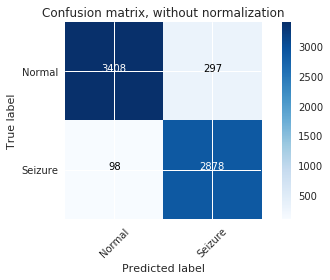

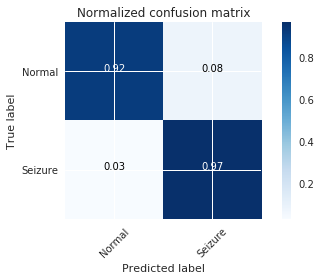

             precision    recall  f1-score   support

     Normal     0.9720    0.9198    0.9452      3705
    Seizure     0.9065    0.9671    0.9358      2976

avg / total     0.9428    0.9409    0.9410      6681

....................................................................


sensitivity_specificity None: (array([0.92, 0.97]), array([0.97, 0.92]), array([3705, 2976]))
sensitivity_specificity micro: (0.9408771142044604, 0.9408771142044604, None)
sensitivity_specificity macro: (0.9434539745766402, 0.9434539745766402, None)
sensitivity_specificity weighted: (0.9408771142044604, 0.9460308349488197, None)




F1 None: [0.95 0.94]


F1 micro: 0.9408771142044604


F1 macro: 0.9405026880819218


F1 weighted: 0.9410177006165079




precision None: 0.9408771142044604


precision micro: 0.9408771142044604


precision macro: 0.9408771142044604


precision weighted: 0.9408771142044604




recall None: 0.9408771142044604


recall micro: 0.9408771142044604


recall macro: 0.9408771142044604


In [8]:
import itertools

print(grid_sclf.best_estimator_)
print(grid_sclf.best_params_)
print('...................................................................\n\n')

#Prediction
y_predict = grid_sclf.predict(x_test)

print('Accuracy of MLP Model: {}\n\n' .format((accuracy_score(y_test,y_predict))))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
#generate and plot confusion matrix
target_names = ['Normal', 'Seizure']

cnf_matrix = confusion_matrix(y_test,y_predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#Classification Report

print(classification_report(y_test, y_predict, digits=4, target_names=target_names))
#print(classification_report_imbalanced(y_test, y_predict, target_names=target_names, digits=4))

print('....................................................................\n\n')

#micro recall, precesion, specificity
for i in [None, 'micro', 'macro', 'weighted']:
    print('sensitivity_specificity {}: {}'.format(i, sensitivity_specificity_support(y_test, y_predict, average=i)))
print('\n')
for i in [None, 'micro', 'macro', 'weighted']:
    print('\n\nF1 {}: {}'.format(i, f1_score(y_test, y_predict, average=i)))
print('\n')
for i in [None, 'micro', 'macro', 'weighted']:
    print('\n\nprecision {}: {}'.format(i,precision_score(y_test, y_predict, average='micro')))
print('\n')
for i in [None, 'micro', 'macro', 'weighted']:
    print('\n\nrecall {}: {}'.format(i, recall_score(y_test, y_predict, average='micro')))